# 4. CNN and AutoEncoder

#### Loading the MNIST dataset using PyTorch’s torchvision

In [10]:
import os
import random
import wandb
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset



In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = datasets.MNIST('mnist_data/', download=True, train=True, transform=transform, target_transform=None)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True) 


## 4.1 Data visualization and Preprocessing

#### 1. Draw a graph that shows the distribution of the various labels across the entire dataset.

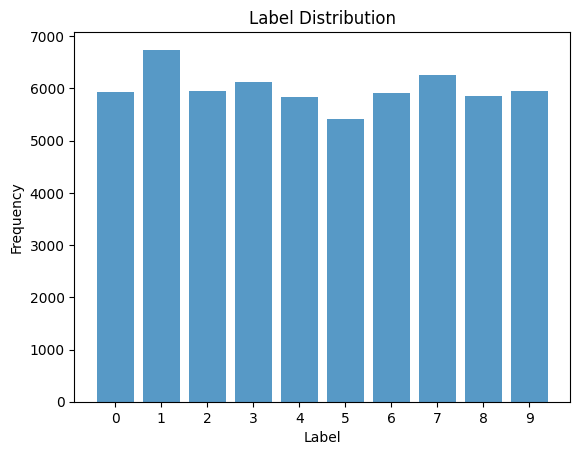

In [9]:

def plot_label_distribution(dataset):
    labels = [label for _, label in dataset]
    plt.hist(labels, bins=range(11), rwidth=0.8, align='left', alpha=0.75)
    plt.xticks(range(10))
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Label Distribution')
    plt.show()

plot_label_distribution(dataset)


#### 2. Visualize several samples (say 5) of images from each class.

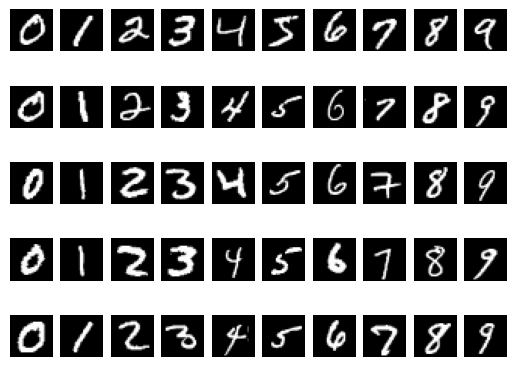

In [4]:

torch.manual_seed(42)

def show_samples(dataset, num_samples=5):
    classes = [i for i in range(10)] 
    
    for class_label in classes:
        samples = []
        for i, (image, label) in enumerate(dataset):
            if label == class_label:
                samples.append(image)
            if len(samples) == num_samples:
                break

        for i in range(num_samples):
            plt.subplot(num_samples, len(classes), i * len(classes) + class_label + 1)
            plt.axis('off')
            plt.imshow(samples[i].squeeze(), cmap='gray')
    
    plt.show()

show_samples(dataset, num_samples=5)


#### 3. Check for any class imbalance

Class imbalance refers to a situation in a dataset where the distribution of classes or categories is highly uneven. <br> 
In such cases, one or more classes have significantly fewer instances compared to others.

In [5]:
labels = [label for _, label in dataset]
label_counts = [labels.count(label) for label in range(10)]
for i, count in enumerate(label_counts):
    print("Count for {}: {}".format(i, count))
class_imbalance = max(label_counts) / min(label_counts)
print(f"Class Imbalance Ratio: {class_imbalance}")

Count for 0: 5923
Count for 1: 6742
Count for 2: 5958
Count for 3: 6131
Count for 4: 5842
Count for 5: 5421
Count for 6: 5918
Count for 7: 6265
Count for 8: 5851
Count for 9: 5949
Class Imbalance Ratio: 1.243681977494927


#### 4. Partition the dataset into train, validation, and test sets.

In [4]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

#### 5. Write a function to visualize the feature maps. Your code should be able to visualize feature maps of a trained model for any layer of the given image.

In [11]:

def visualize_feature_maps(model, layer_idx, input_image):
    activations = []
    def hook_fn(module, input, output):
        activations.append(output)
    handle = model[layer_idx].register_forward_hook(hook_fn)
    
    with torch.no_grad():
        model(input_image)
    
    feature_maps = activations[0][0] 
    handle.remove()  
    
    # Visualize the feature maps
    num_feature_maps = feature_maps.size(0)
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i+1)
        plt.imshow(feature_maps[i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.show()


## 4.2 Model Building

#### Constructing CNN
1. Construct a CNN model for Image classification using pytorch.
2. Your network should include convolutional layers, pooling layers, dropout
layers, and fully connected layers.
3. Construct and train a baseline CNN using the following architecture: 2
convolutional layers each with ReLU activation and subsequent max poolling, followed by a dropout and a fully-connected layer with softmax activation, optimized using the Adam optimizer and trained with the cross-entropy loss function. 
5. Report the training and validation loss and accuracy at each epoch.

In [17]:
project_name = 'question-4'
group_name = 'cnn_mnist'
experiment_name = 'mnist'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "Adam",
        "loss": "crossentropy",  # sparse_categorical_
        "metric": "accuracy",
        "epoch": 10, 
        "learning rate": 0.001
    })
config = wandb.config

In [16]:
# ChatGPT generated

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)
        self.dropout = nn.Dropout(0.5)
        self.activationlayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activationlayer(x)
        return x

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

net = BaselineCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train() 

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(trainloader)

    # Validation
    net.eval() 
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(valloader)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    wandb.log({"train loss":avg_train_loss})
    wandb.log({"train accuracy":train_accuracy})

    wandb.log({"val loss":avg_val_loss})
    wandb.log({"val accuracy":val_accuracy})

Epoch 1/10
Training Loss: 1.5737, Training Accuracy: 89.82%
Validation Loss: 1.4961, Validation Accuracy: 96.85%
Epoch 2/10
Training Loss: 1.4984, Training Accuracy: 96.46%
Validation Loss: 1.4848, Validation Accuracy: 97.83%
Epoch 3/10
Training Loss: 1.4909, Training Accuracy: 97.13%
Validation Loss: 1.4823, Validation Accuracy: 98.01%
Epoch 4/10
Training Loss: 1.4869, Training Accuracy: 97.52%
Validation Loss: 1.4815, Validation Accuracy: 98.02%
Epoch 5/10
Training Loss: 1.4849, Training Accuracy: 97.70%
Validation Loss: 1.4811, Validation Accuracy: 98.05%
Epoch 6/10
Training Loss: 1.4842, Training Accuracy: 97.73%
Validation Loss: 1.4757, Validation Accuracy: 98.60%
Epoch 7/10
Training Loss: 1.4822, Training Accuracy: 97.94%
Validation Loss: 1.4767, Validation Accuracy: 98.47%
Epoch 8/10
Training Loss: 1.4817, Training Accuracy: 97.96%
Validation Loss: 1.4743, Validation Accuracy: 98.71%
Epoch 9/10
Training Loss: 1.4803, Training Accuracy: 98.09%
Validation Loss: 1.4739, Validation 

In [21]:
project_name = 'question-4-3-tuning'
group_name = 'cnn_mnist'
experiment_name = 'mnist'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "Adam",
        "loss": "crossentropy",  
        "metric": "accuracy",
        "epoch": 10, 
        "learning rate": 0.001
    })
config = wandb.config

wandb: Currently logged in as: pronoy-patra. Use `wandb login --relogin` to force relogin


In [24]:
# Class used previously was adopted for varying parameters

class BaselineCNN(nn.Module):
    def __init__(self, k_size, stride_val, rate):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=k_size, padding=k_size//2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=stride_val)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=k_size, padding=k_size//2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=stride_val)
        self.fc = nn.Linear(64 * 7 * 7, 10)
        self.dropout = nn.Dropout(rate)
        self.activationlayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activationlayer(x)
        return x

# function_cnn(learning_rate, batch_size, kernel_size, strides, num_epochs, dropout_rate)

def function_cnn(learning_rate, batch_size, kernel_size, strides, number_of_epochs, dropout_rate):
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    net = BaselineCNN(kernel_size, strides, dropout_rate)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    num_epochs = number_of_epochs
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train() 
    
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    
        train_accuracy = 100 * correct_train / total_train
        avg_train_loss = running_loss / len(trainloader)
    
        # Validation
        net.eval()  
        correct_val = 0
        total_val = 0
        val_loss = 0.0
    
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
    
        val_accuracy = 100 * correct_val / total_val
        avg_val_loss = val_loss / len(valloader)

        # confmat = ConfusionMatrix(task="multiclass", num_classes=10)
        # conf_matrix = confmat(outputs, inputs)

        # from torchmetrics.classification import MulticlassConfusionMatrix
        # metric = MulticlassConfusionMatrix(num_classes=5)
    
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
        wandb.log({"train loss":avg_train_loss})
        wandb.log({"train accuracy":train_accuracy})
    
        wandb.log({"val loss":avg_val_loss})
        wandb.log({"val accuracy":val_accuracy})

        wandb.log({"learning_rate": learning_rate,
               "batch_size": batch_size,
               "kernel_size": kernel_size,
               "strides": strides,
               "num_epochs": num_epochs,
               "dropout_rate": dropout_rate})

# Define the hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
kernel_sizes = [3, 5, 7, 9]
strides_values = [2, 4, 6, 8]
num_epochs_values = [5, 10, 15, 20]
dropout_rates = [0, 0.25, 0.5, 1]

# Hyperparameter tuning loop
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for kernel_size in kernel_sizes:
            for strides in strides_values:
                for num_epochs in num_epochs_values:
                    for dropout_rate in dropout_rates:
                        function_cnn(learning_rate, batch_size, kernel_size, strides, num_epochs, dropout_rate)

wandb.finish()

Epoch 1/5
Training Loss: 1.5666, Training Accuracy: 90.24%
Validation Loss: 1.4944, Validation Accuracy: 96.86%
Epoch 2/5
Training Loss: 1.4873, Training Accuracy: 97.56%
Validation Loss: 1.4885, Validation Accuracy: 97.37%
Epoch 3/5
Training Loss: 1.4818, Training Accuracy: 98.05%
Validation Loss: 1.4800, Validation Accuracy: 98.20%
Epoch 4/5
Training Loss: 1.4781, Training Accuracy: 98.37%
Validation Loss: 1.4783, Validation Accuracy: 98.40%
Epoch 5/5
Training Loss: 1.4767, Training Accuracy: 98.51%
Validation Loss: 1.4815, Validation Accuracy: 98.00%
Epoch 1/5
Training Loss: 1.5789, Training Accuracy: 88.91%
Validation Loss: 1.4888, Validation Accuracy: 97.34%
Epoch 2/5
Training Loss: 1.4905, Training Accuracy: 97.27%
Validation Loss: 1.4847, Validation Accuracy: 97.78%
Epoch 3/5
Training Loss: 1.4844, Training Accuracy: 97.76%
Validation Loss: 1.4835, Validation Accuracy: 97.83%
Epoch 4/5
Training Loss: 1.4804, Training Accuracy: 98.14%
Validation Loss: 1.4809, Validation Accuracy:

RuntimeError: shape '[-1, 3136]' is invalid for input of size 16384

The error at last was deliberate as the dropout value was chosen as such 

#### 4. Display feature maps after applying convolution and pooling layers for any one class and provide a brief analysis.

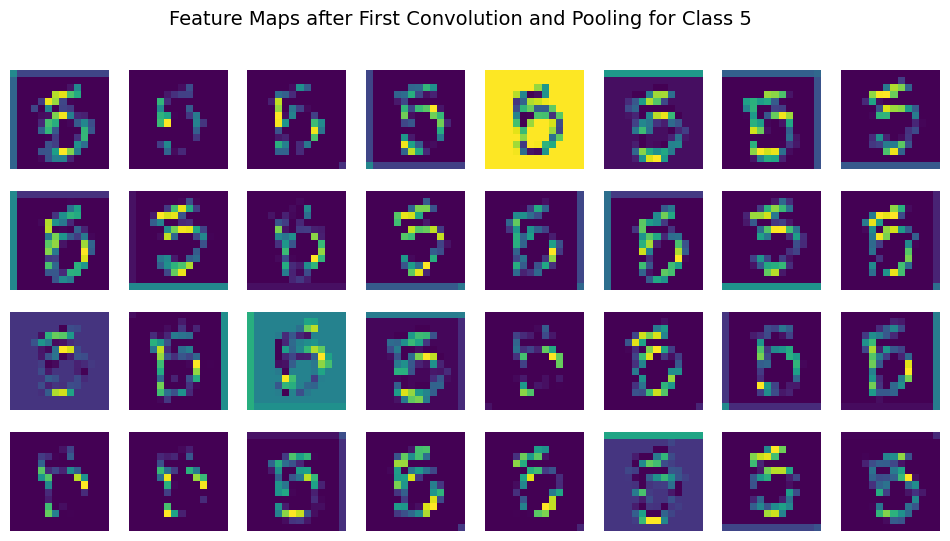

In [12]:

class_idx = 5 
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for image, label in sample_loader:
    if label.item() == class_idx:
        break

# Displaying feature maps after the first convolution and pooling layers
conv1 = net.conv1(image)
conv1 = net.relu1(conv1)
conv1 = net.pool1(conv1)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(conv1[0, i].detach().numpy(), cmap='viridis')
    plt.axis('off')
plt.suptitle(f'Feature Maps after First Convolution and Pooling for Class {class_idx}', fontsize=14)
plt.show()


## 4.3 Hyperparameter Tuning and Evaluation

In [ ]:
project_name = 'question-4'
group_name = 'cnn_mnist'
experiment_name = 'mnist'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "Adam",
        "loss": "crossentropy", 
        "metric": "accuracy",
        "epoch": 10, 
        "earning rate": 0.001
    })
config = wandb.config

## 4.4 Model Evaluation and Analysis

#### Training the best model 

In [5]:
# Best Model 
# learning_rates = 0.001
# batch_sizes = 32
# kernel_sizes = 3
# strides_values = 2
# num_epochs_values = 10
# dropout_rates = 0

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)
        self.dropout = nn.Dropout(0)
        self.activationlayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activationlayer(x)
        return x

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

net = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(trainloader)

    net.eval() 
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(valloader)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/10
Training Loss: 1.5286, Training Accuracy: 93.83%
Validation Loss: 1.4874, Validation Accuracy: 97.53%
Epoch 2/10
Training Loss: 1.4853, Training Accuracy: 97.67%
Validation Loss: 1.4854, Validation Accuracy: 97.62%
Epoch 3/10
Training Loss: 1.4795, Training Accuracy: 98.22%
Validation Loss: 1.4820, Validation Accuracy: 97.96%
Epoch 4/10
Training Loss: 1.4776, Training Accuracy: 98.40%
Validation Loss: 1.4793, Validation Accuracy: 98.20%
Epoch 5/10
Training Loss: 1.4751, Training Accuracy: 98.65%
Validation Loss: 1.4785, Validation Accuracy: 98.28%
Epoch 6/10
Training Loss: 1.4738, Training Accuracy: 98.75%
Validation Loss: 1.4784, Validation Accuracy: 98.31%
Epoch 7/10
Training Loss: 1.4722, Training Accuracy: 98.90%
Validation Loss: 1.4817, Validation Accuracy: 97.97%
Epoch 8/10
Training Loss: 1.4725, Training Accuracy: 98.89%
Validation Loss: 1.4756, Validation Accuracy: 98.57%
Epoch 9/10
Training Loss: 1.4707, Training Accuracy: 99.05%
Validation Loss: 1.4763, Validation 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



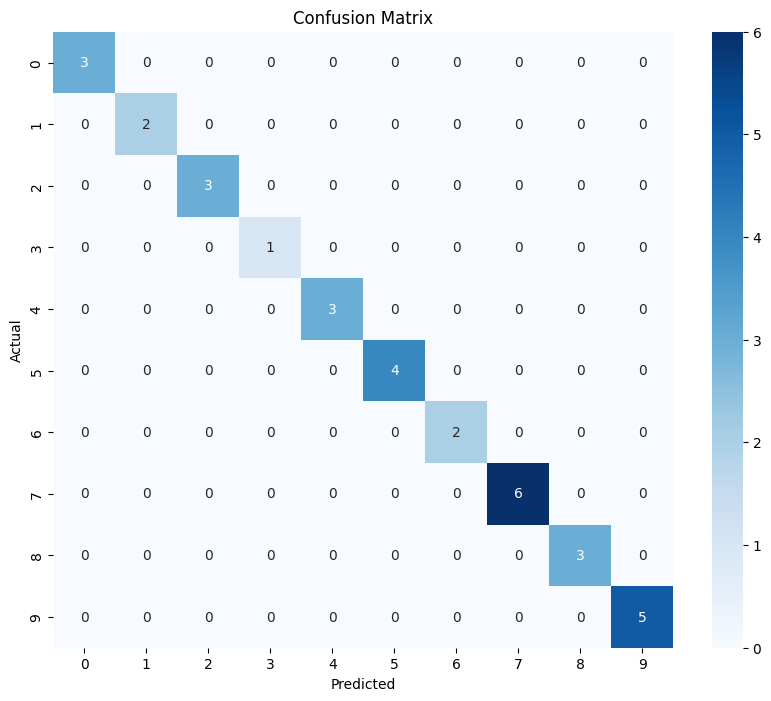

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       0.88      1.00      0.93         7
           7       1.00      1.00      1.00         2
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.99      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



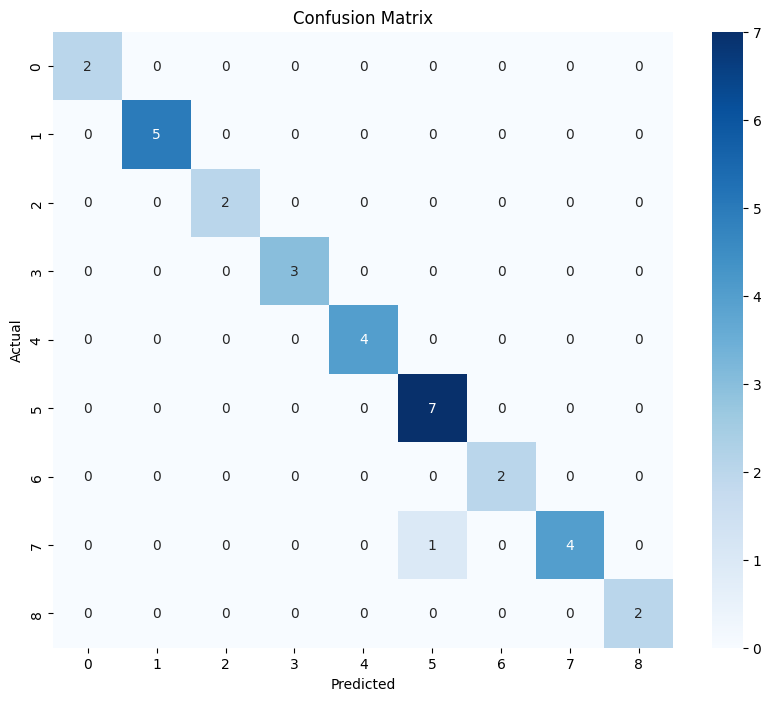

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



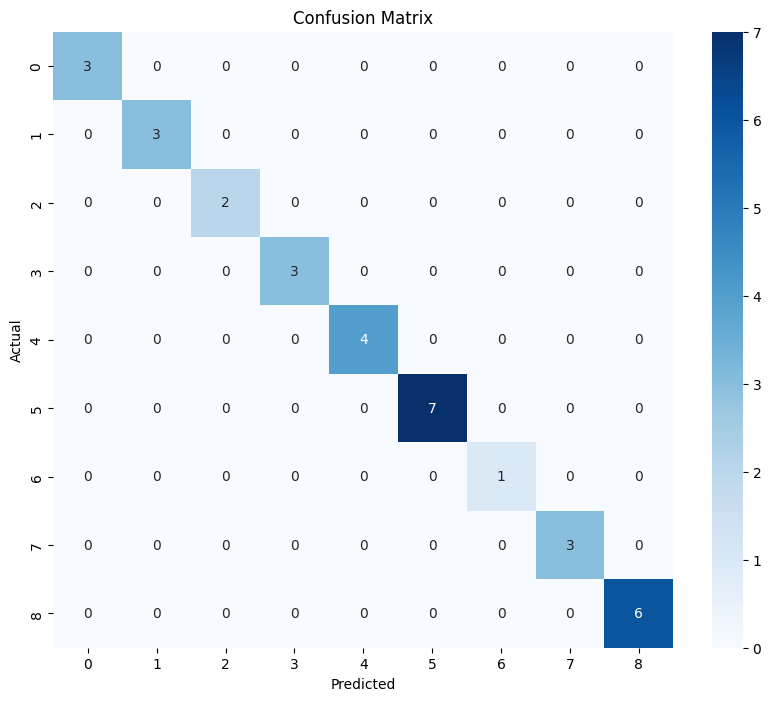

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



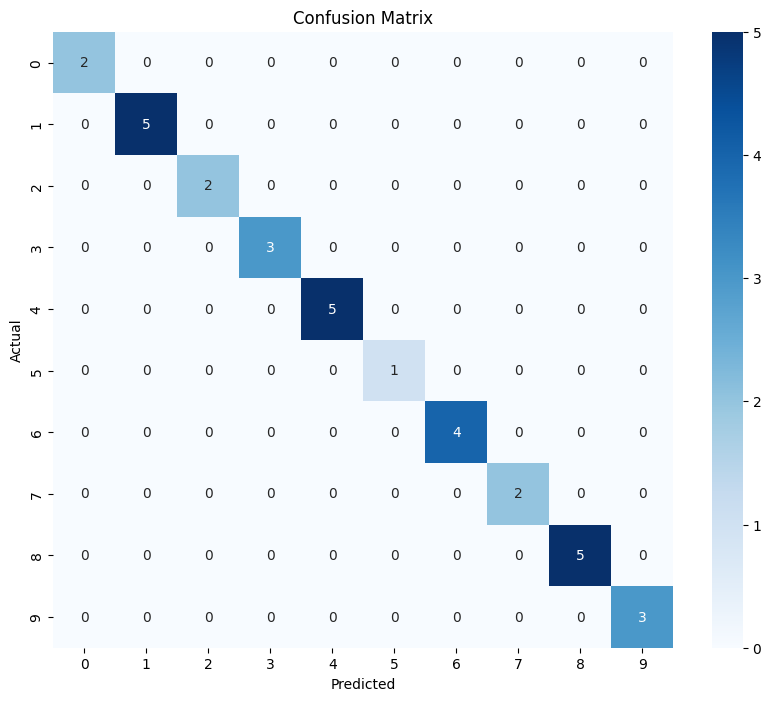

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       0.88      1.00      0.93         7
           5       0.86      1.00      0.92         6
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         4

    accuracy                           0.94        32
   macro avg       0.87      0.88      0.87        32
weighted avg       0.91      0.94      0.92        32



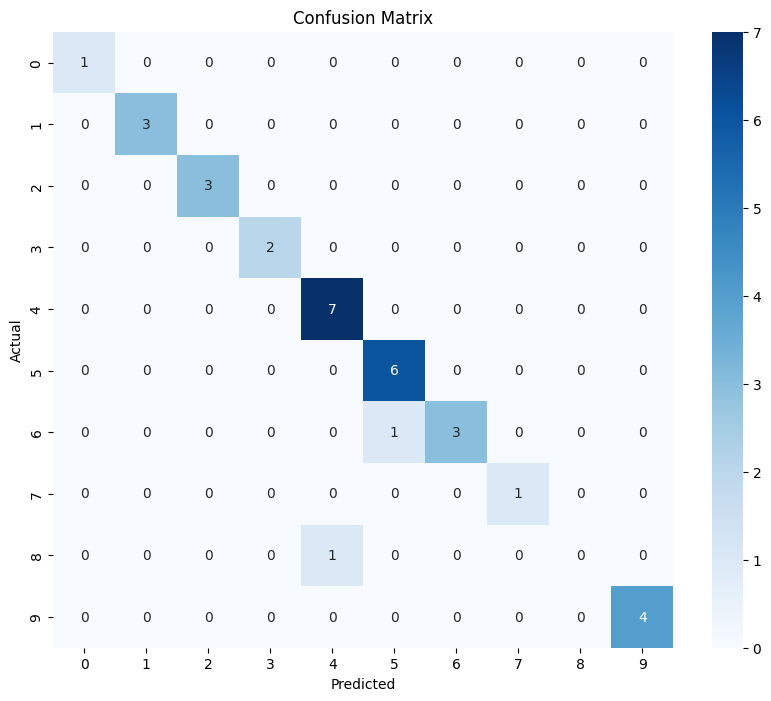

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



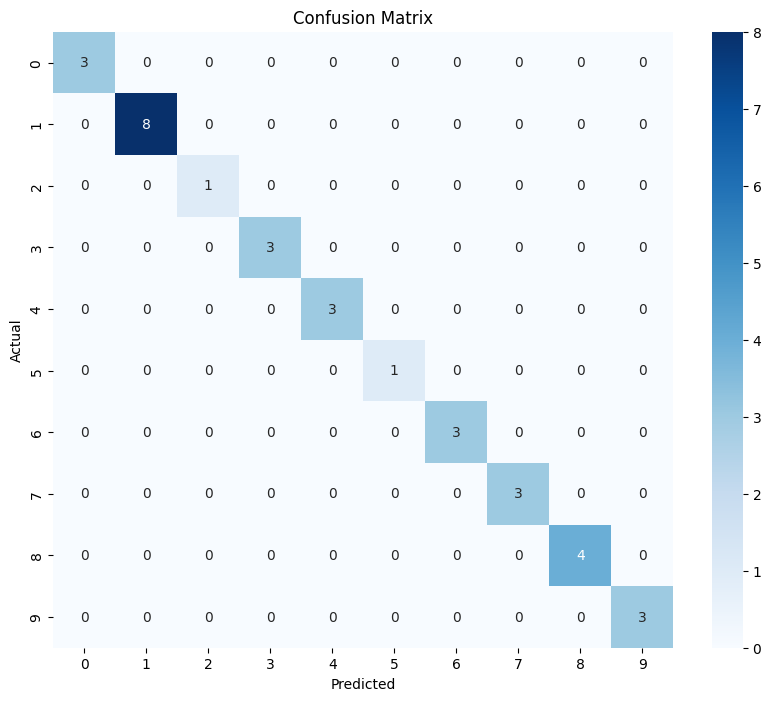

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



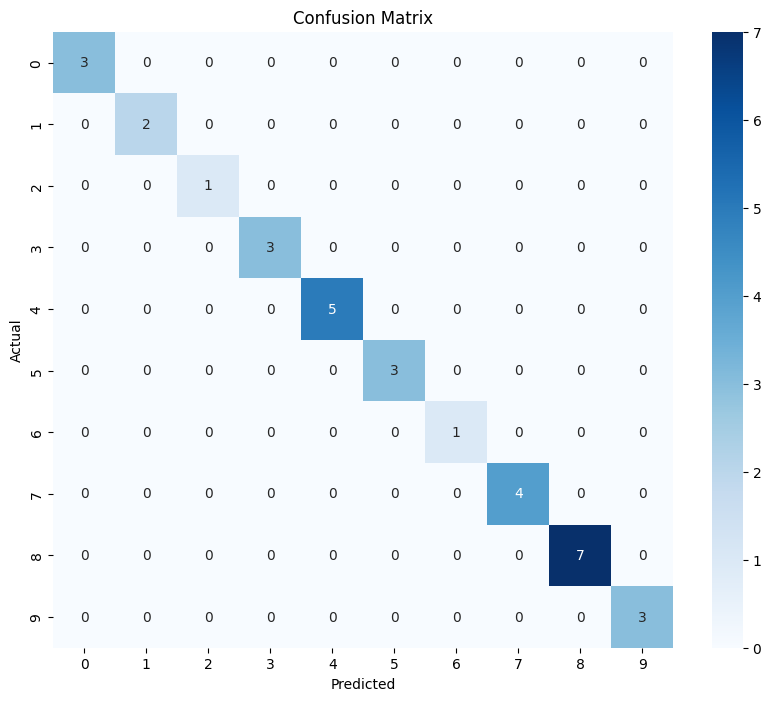

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



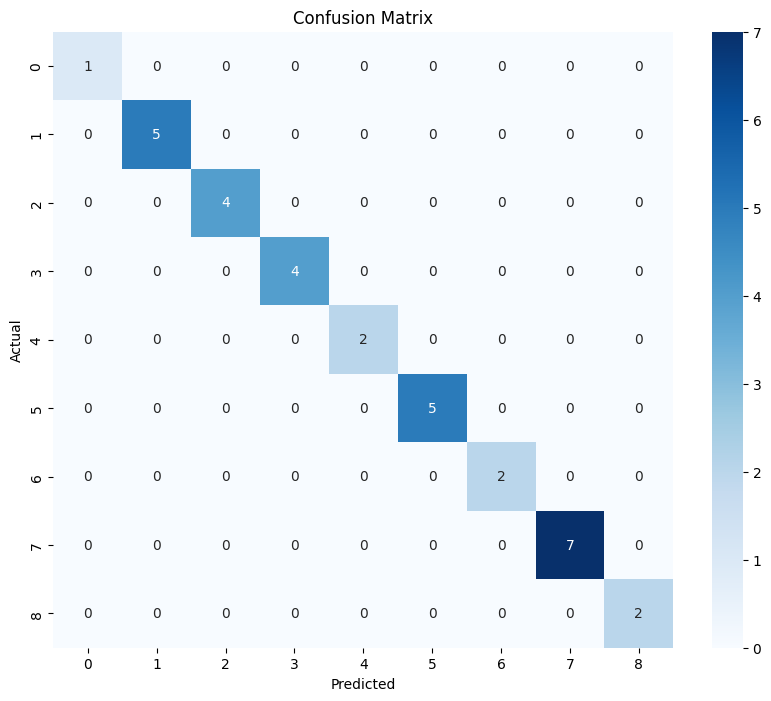

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



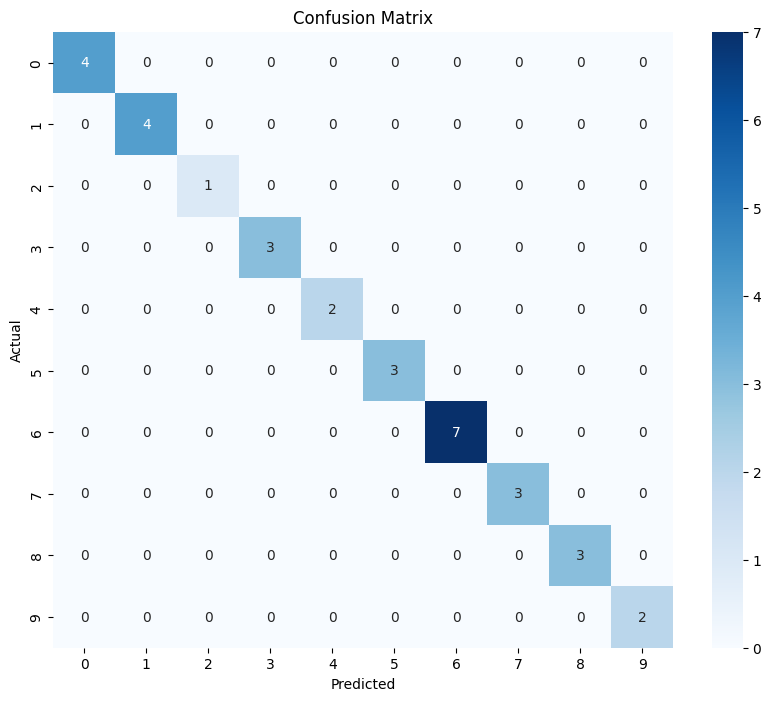

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



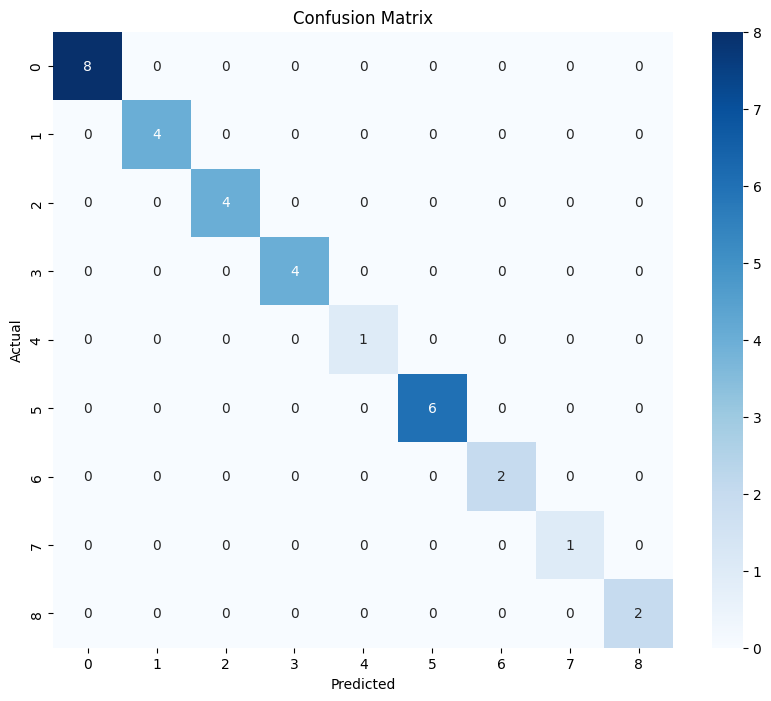

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



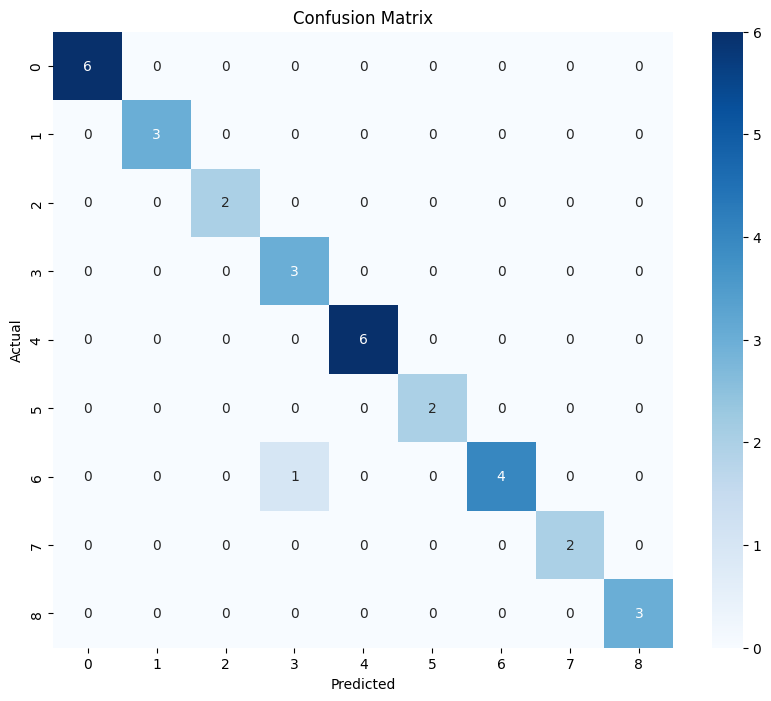

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         2
           8       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.94      0.97      0.95        32
weighted avg       0.98      0.97      0.97        32



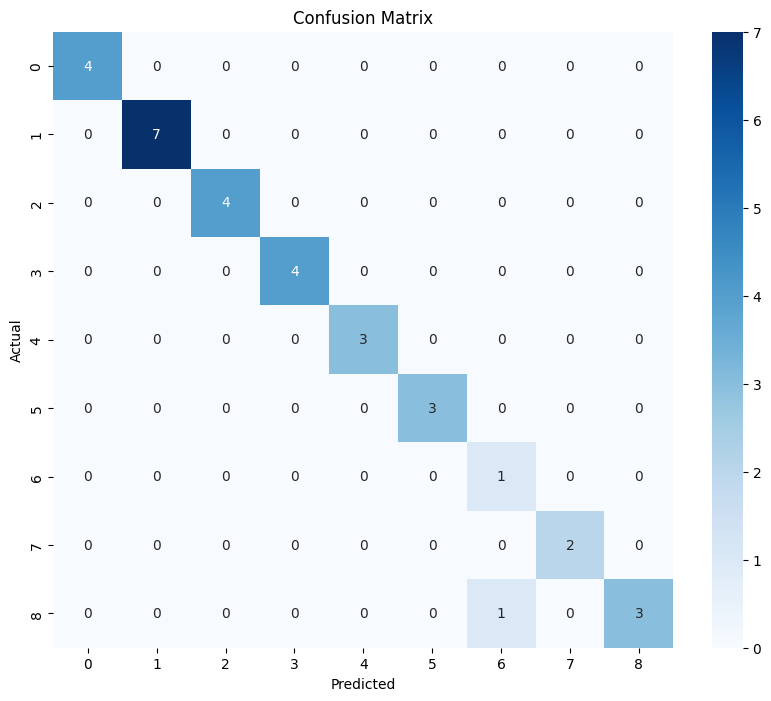

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



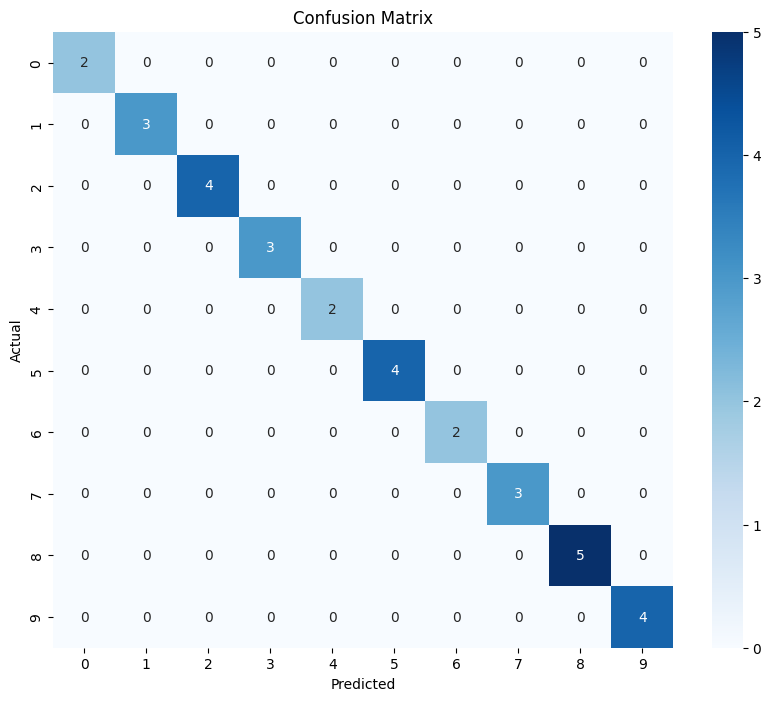

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



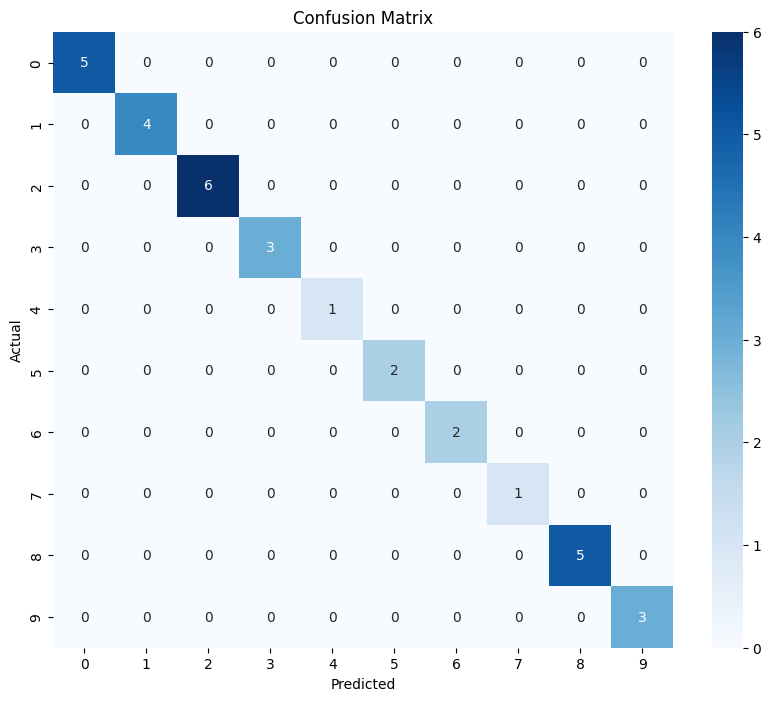

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.96      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



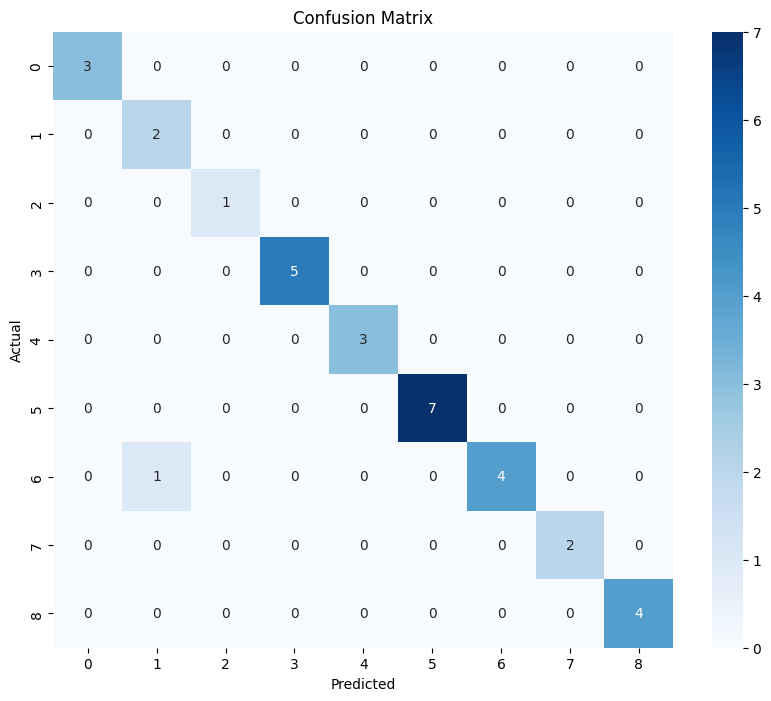

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



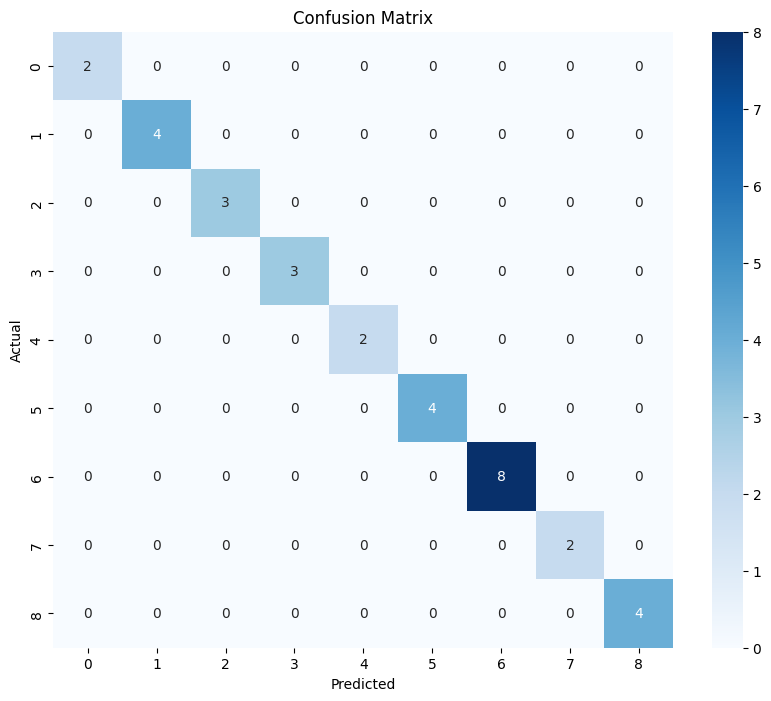

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



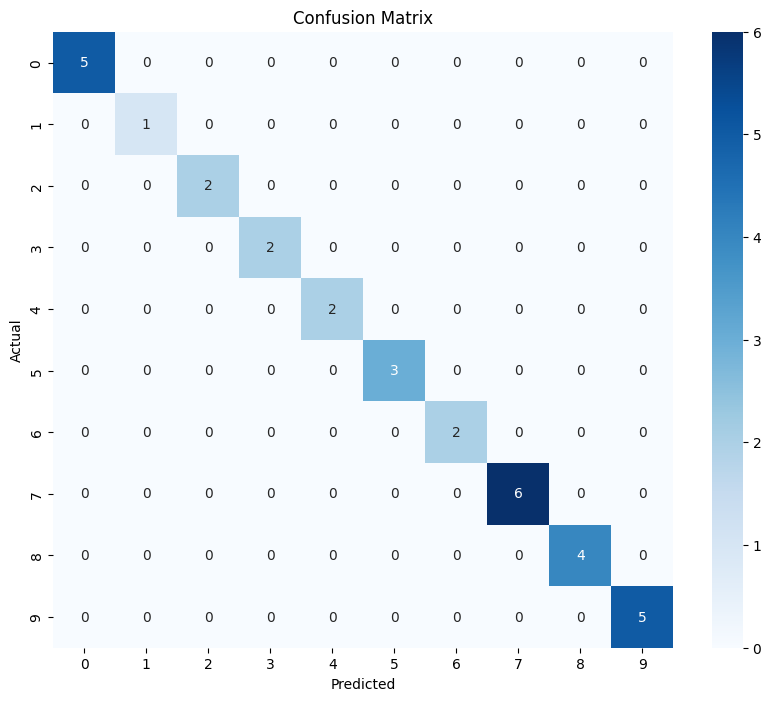

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



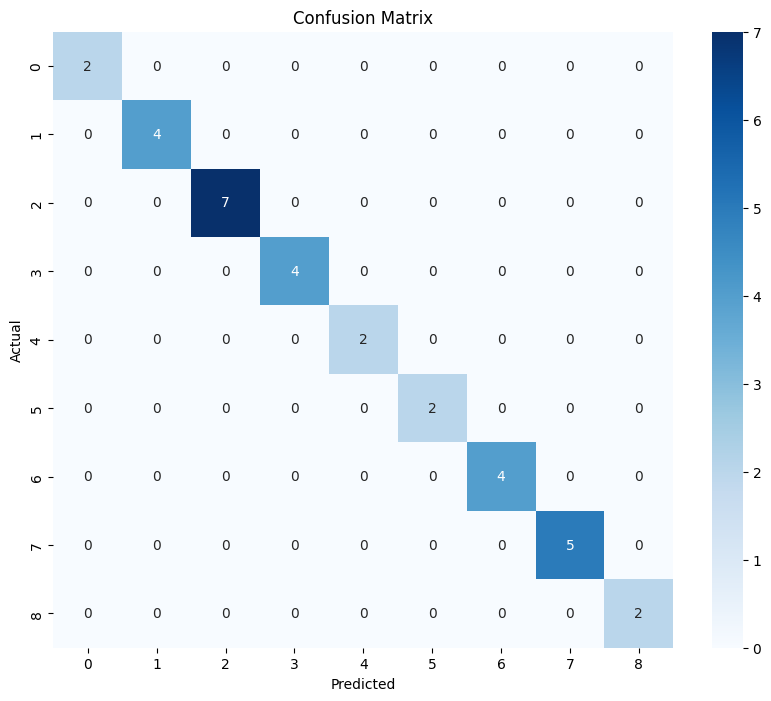

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



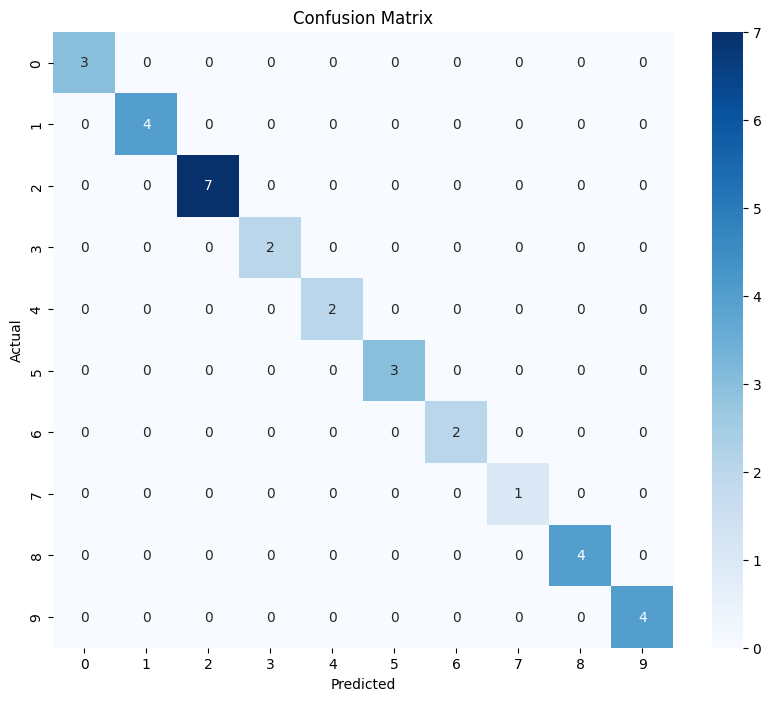

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



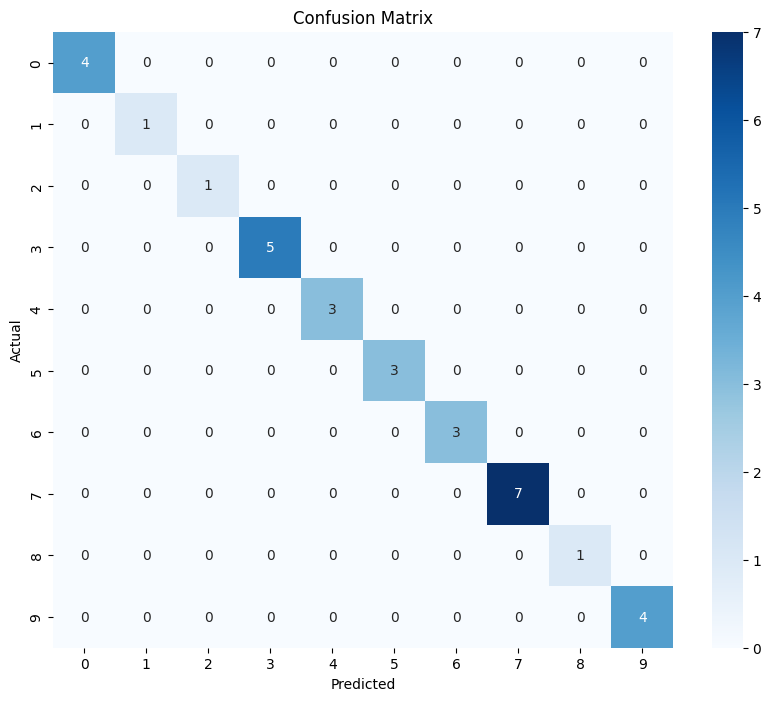

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



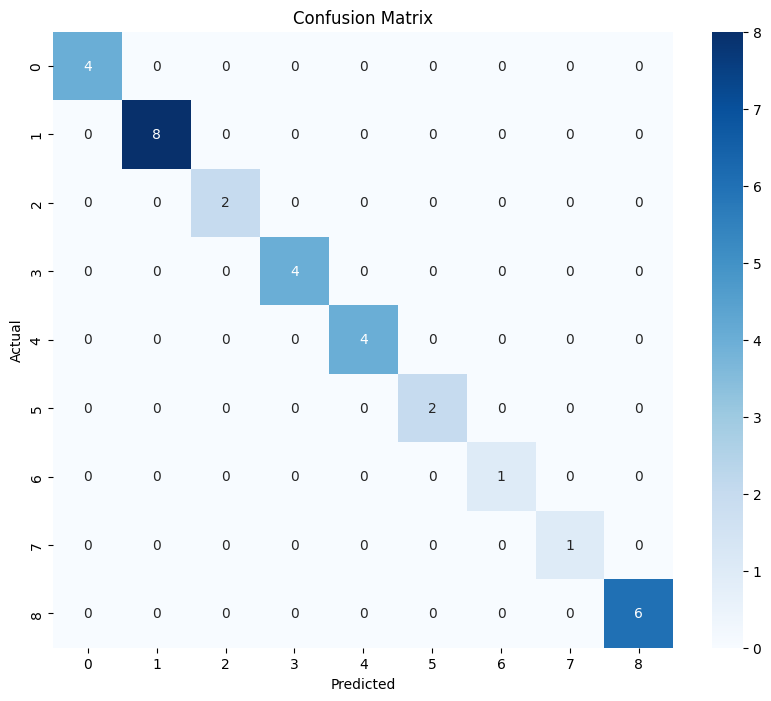

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      0.83      0.91         6
           8       1.00      1.00      1.00         2
           9       0.50      1.00      0.67         1

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.98      0.97      0.97        32



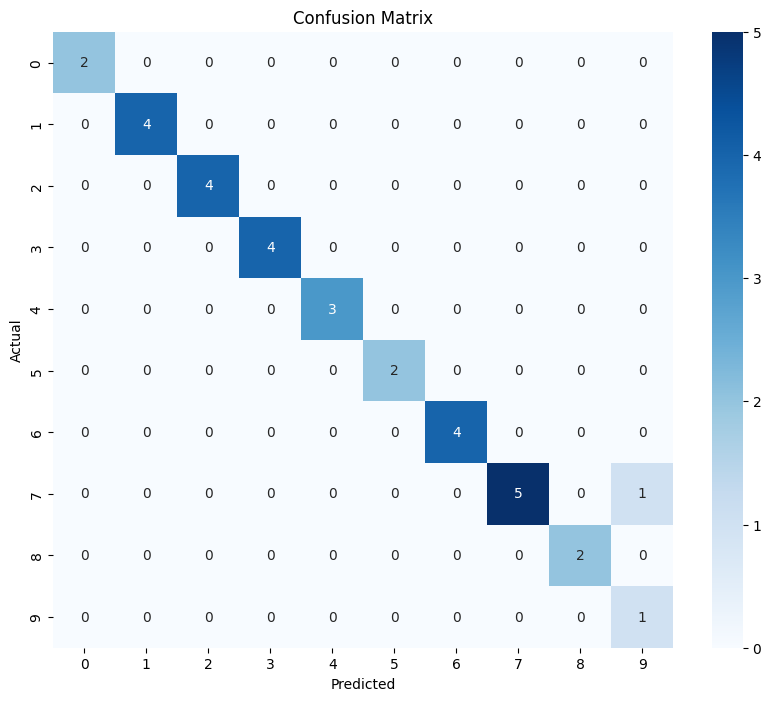

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



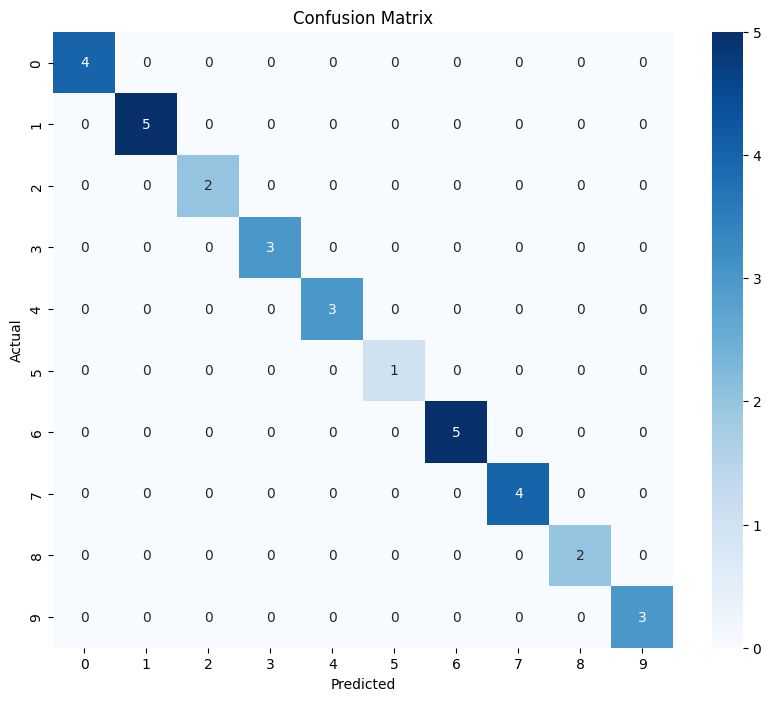

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         4
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.92        32
weighted avg       0.96      0.94      0.93        32



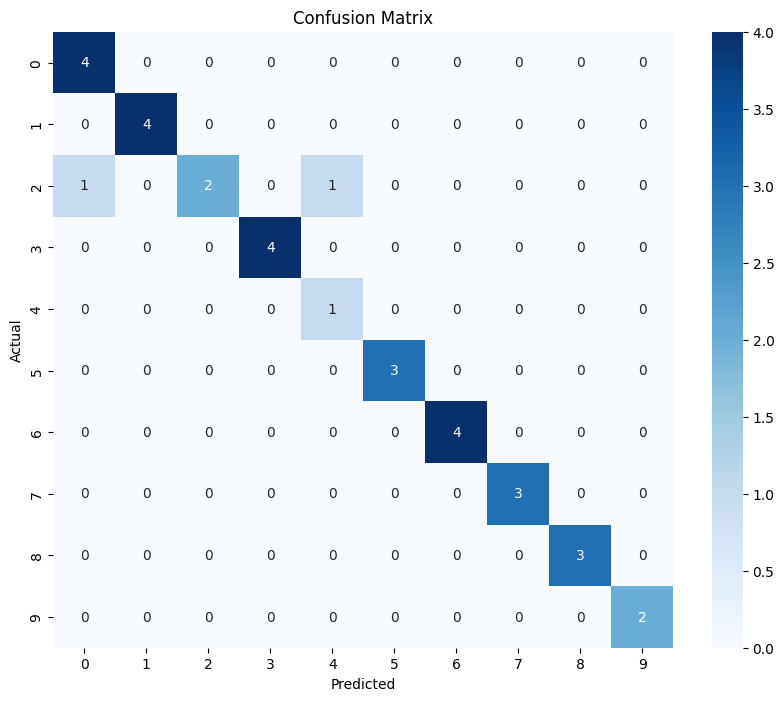

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



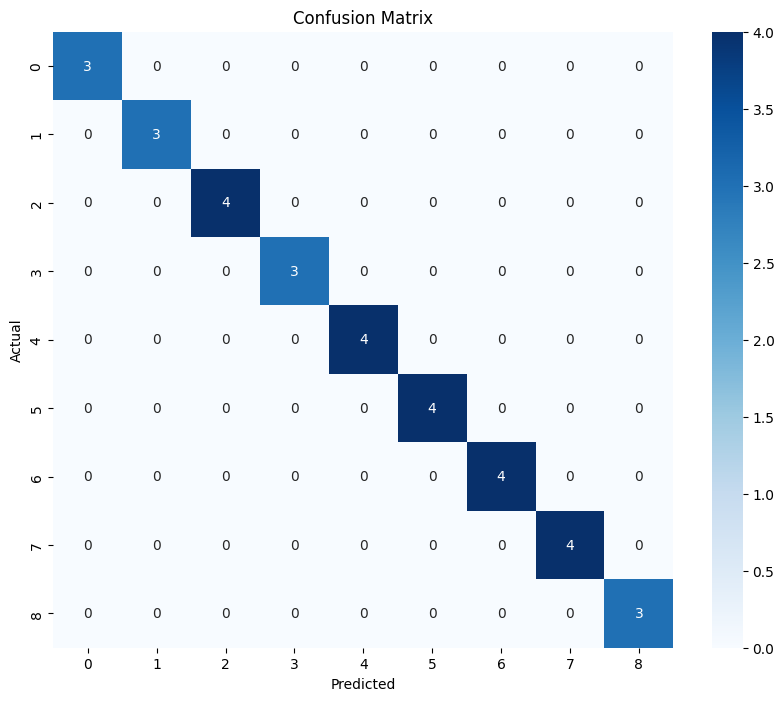

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.96        32
weighted avg       0.98      0.97      0.97        32



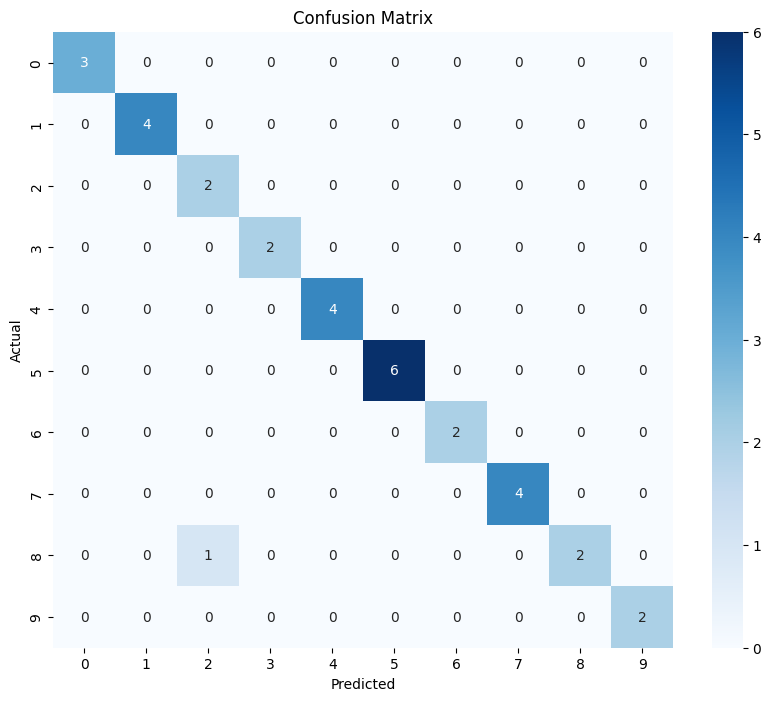

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



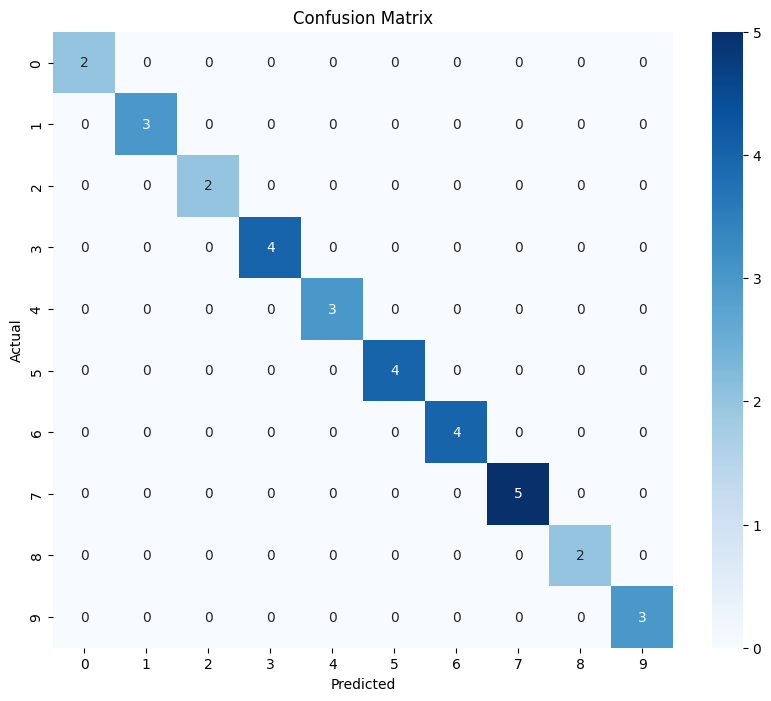

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



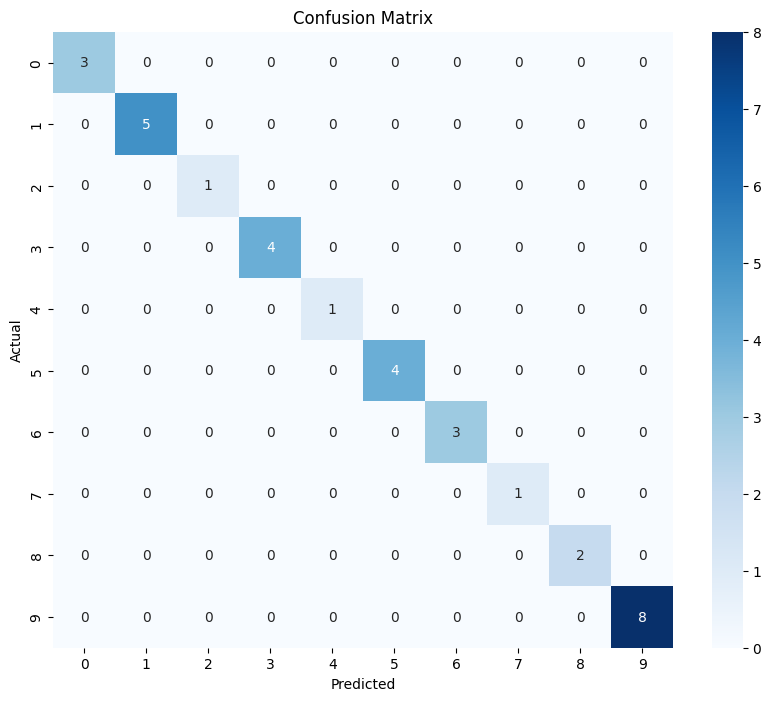

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5

    accuracy                           0.97        32
   macro avg       0.98      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



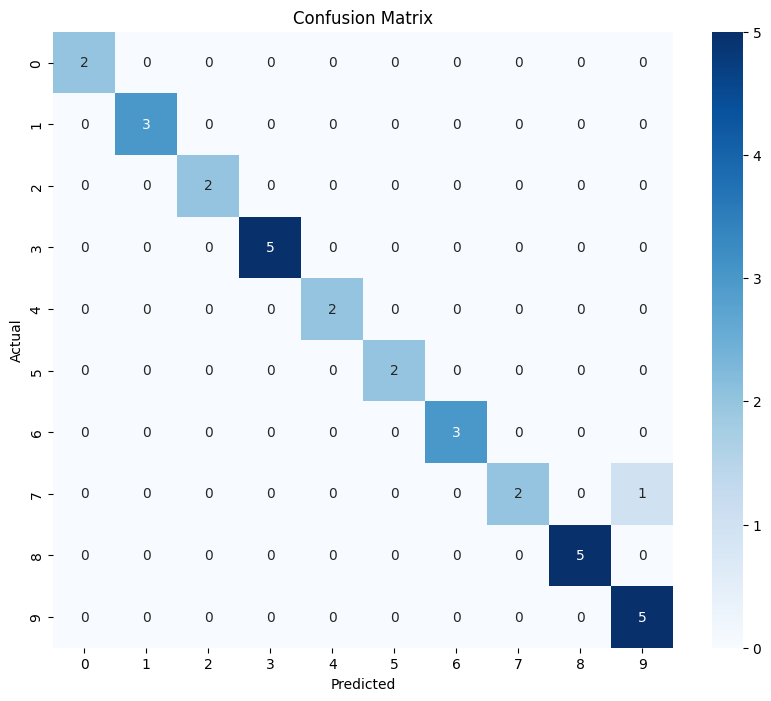

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



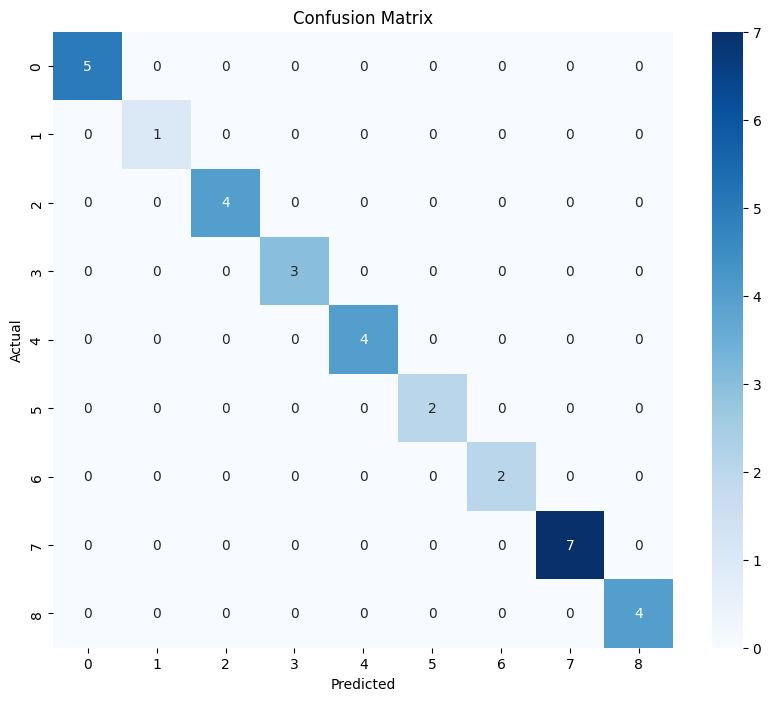

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      0.50      0.67         4
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         1
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.92        32
weighted avg       0.96      0.94      0.93        32



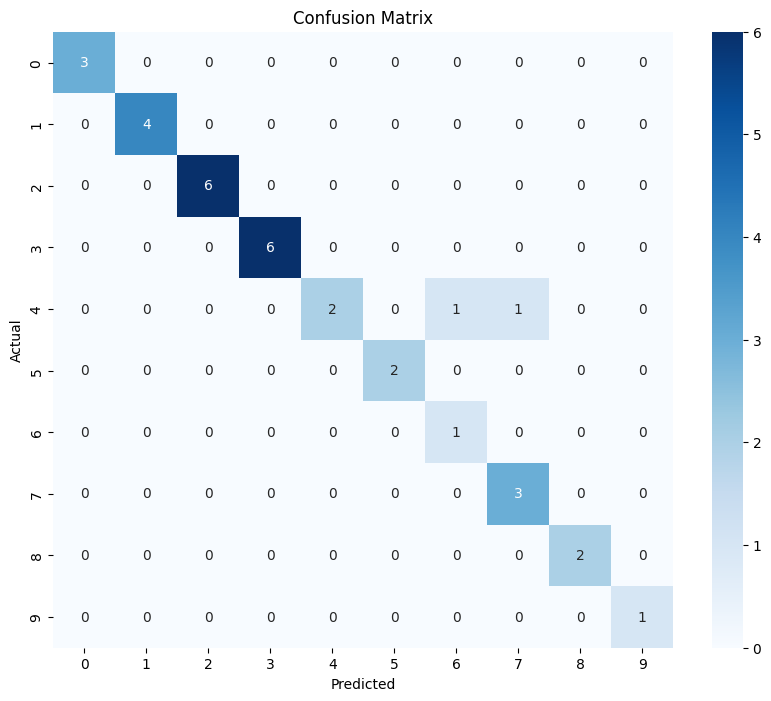

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



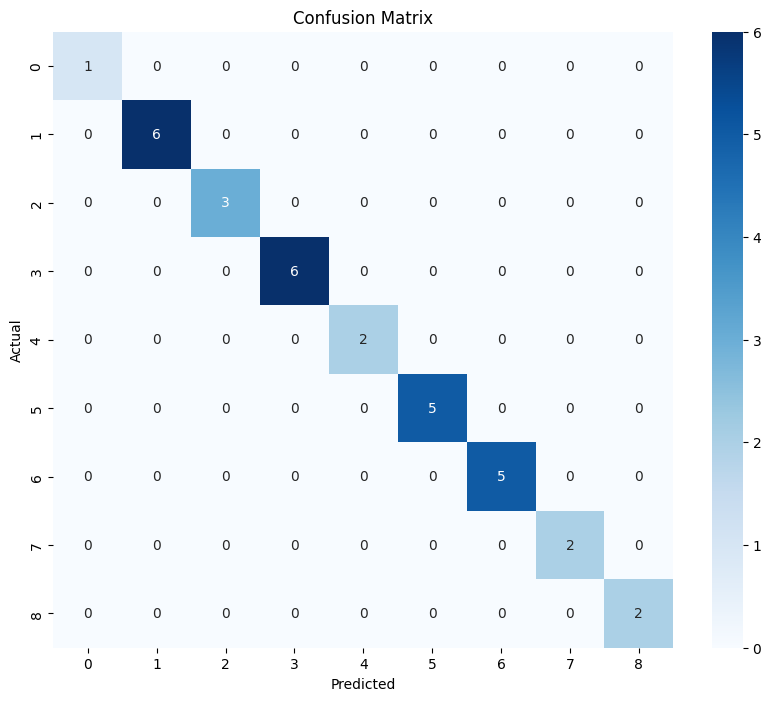

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



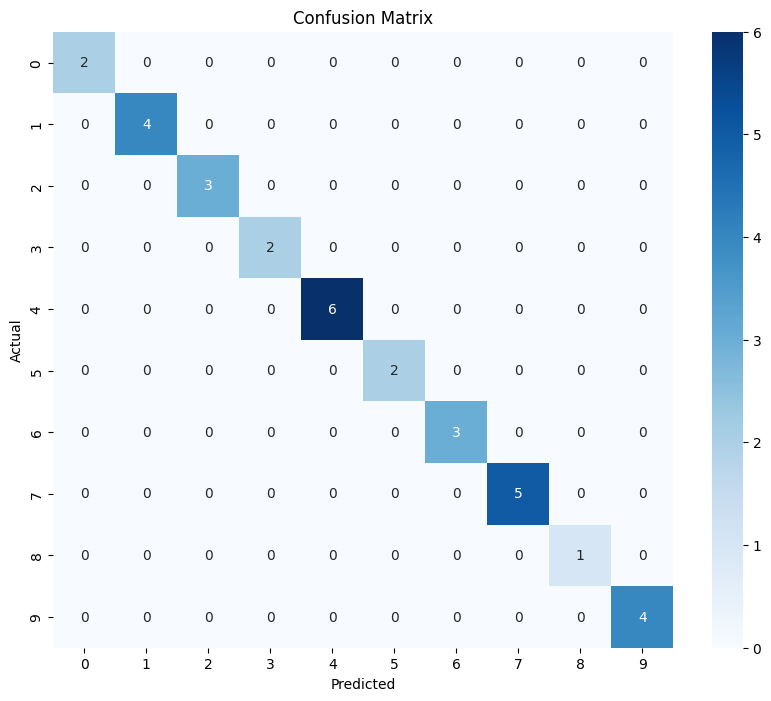

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



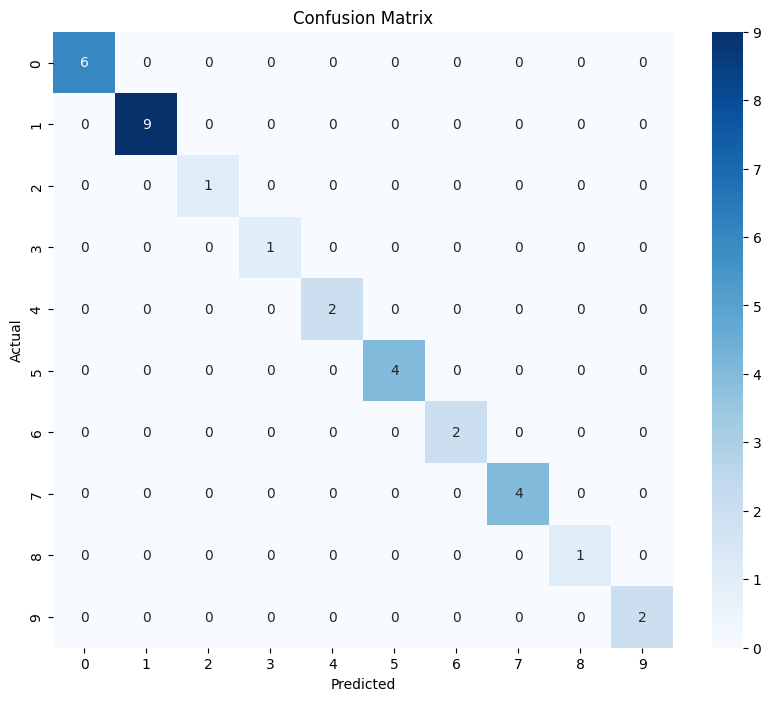

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



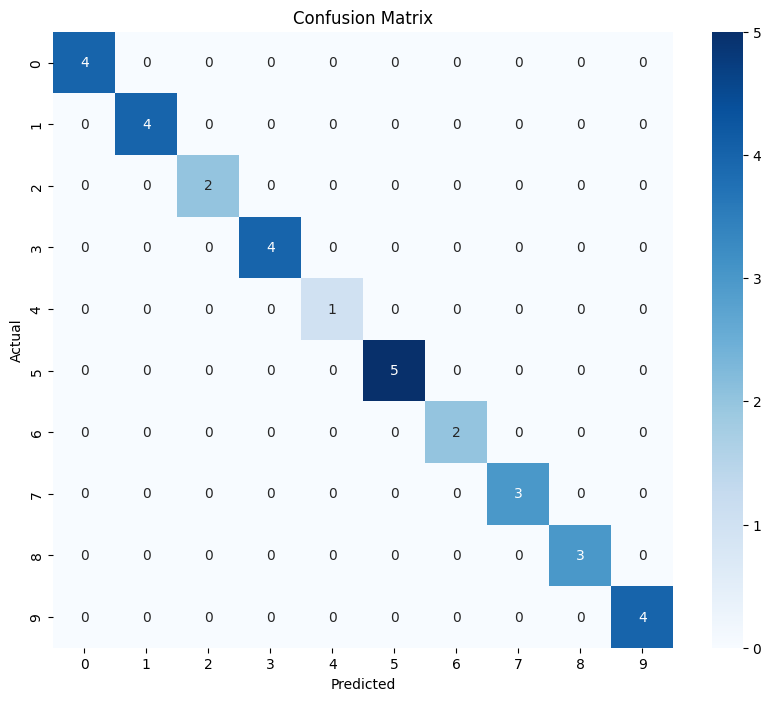

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.98      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



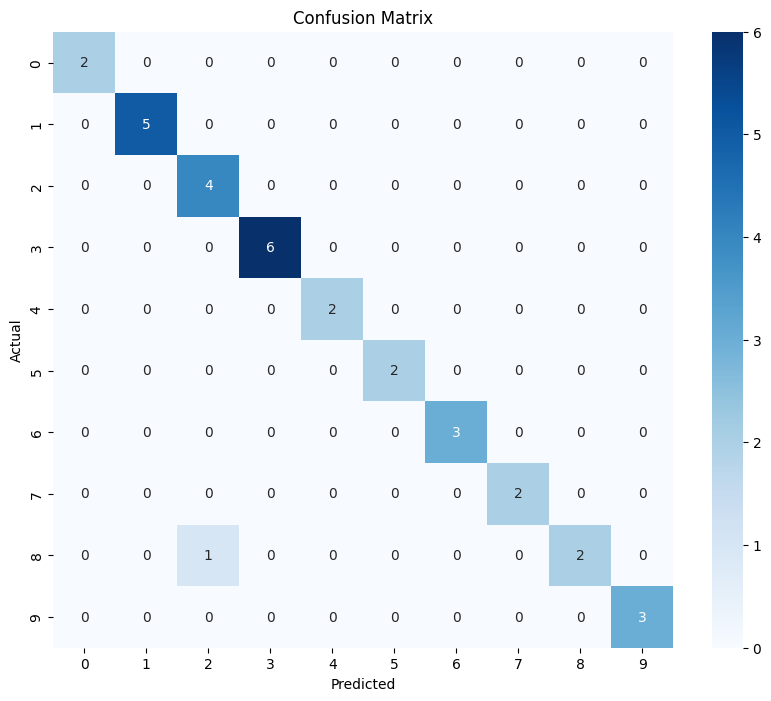

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



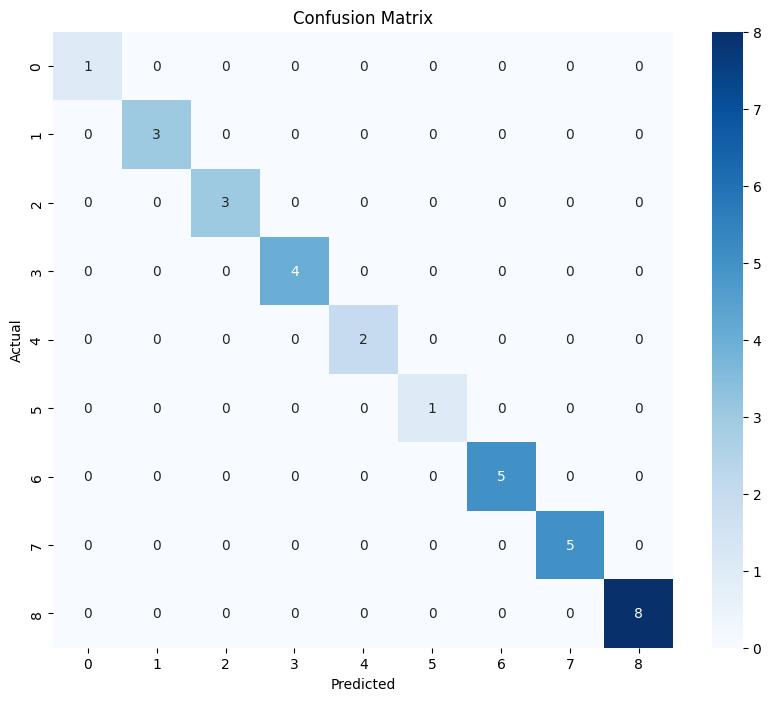

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



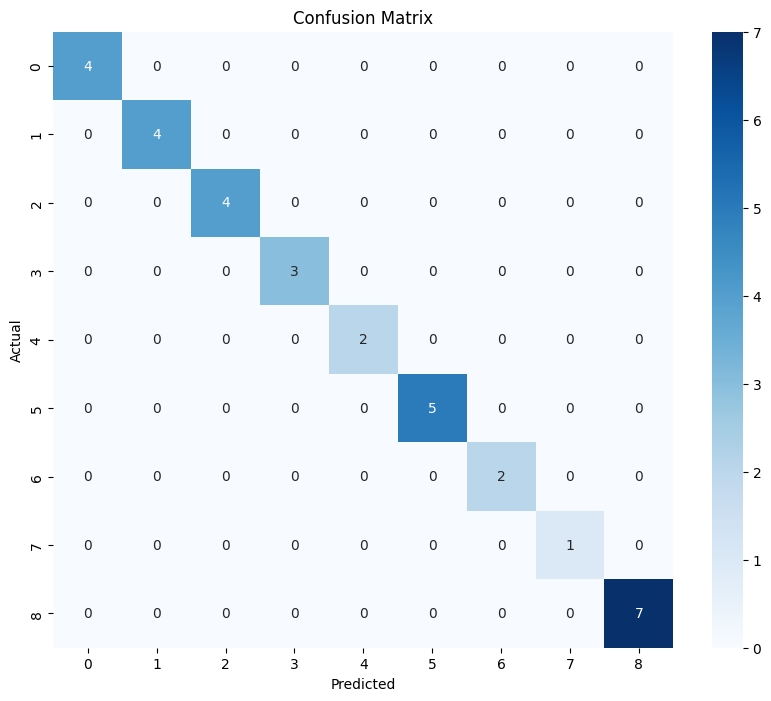

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.96      0.94      0.94        32
weighted avg       0.98      0.97      0.97        32



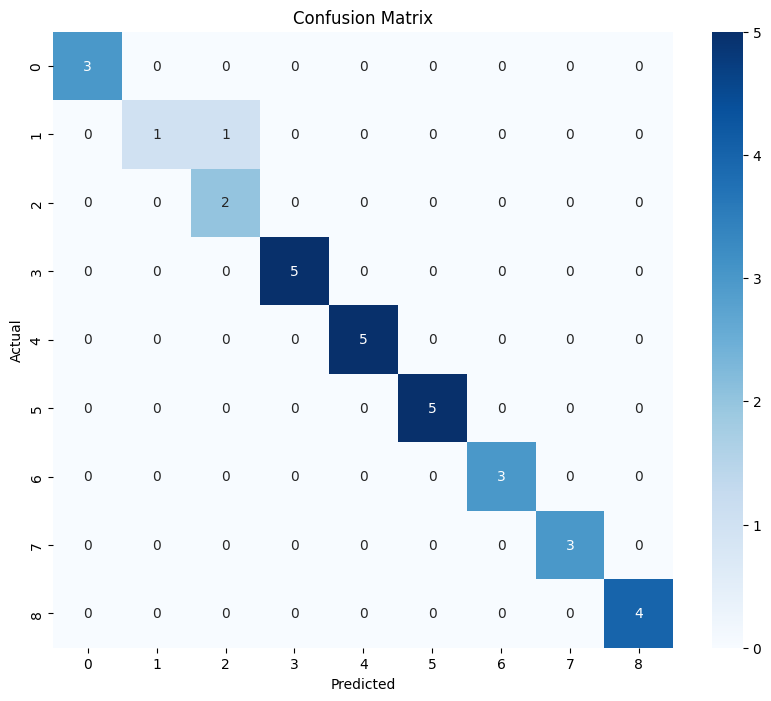

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



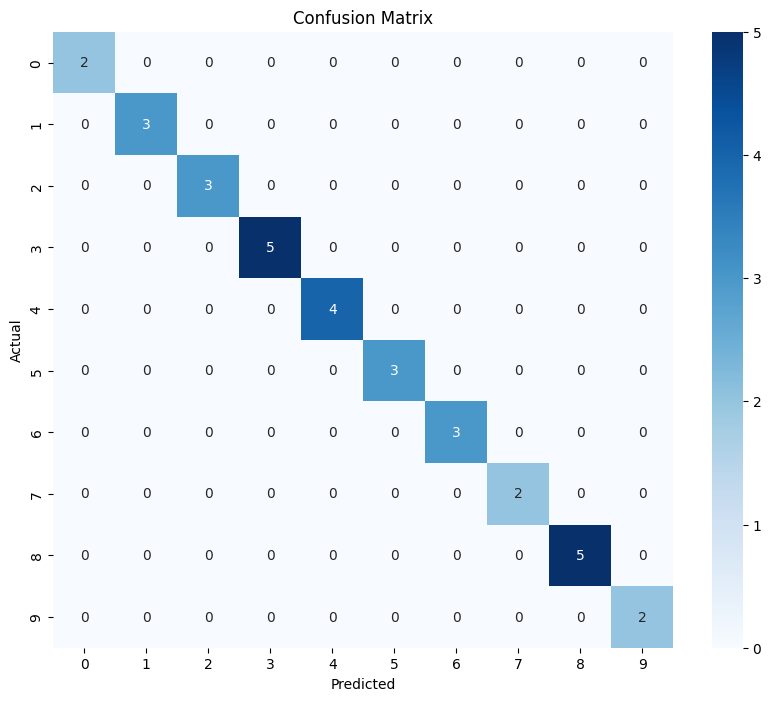

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         9

    accuracy                           0.97        32
   macro avg       0.85      0.90      0.87        32
weighted avg       0.95      0.97      0.96        32



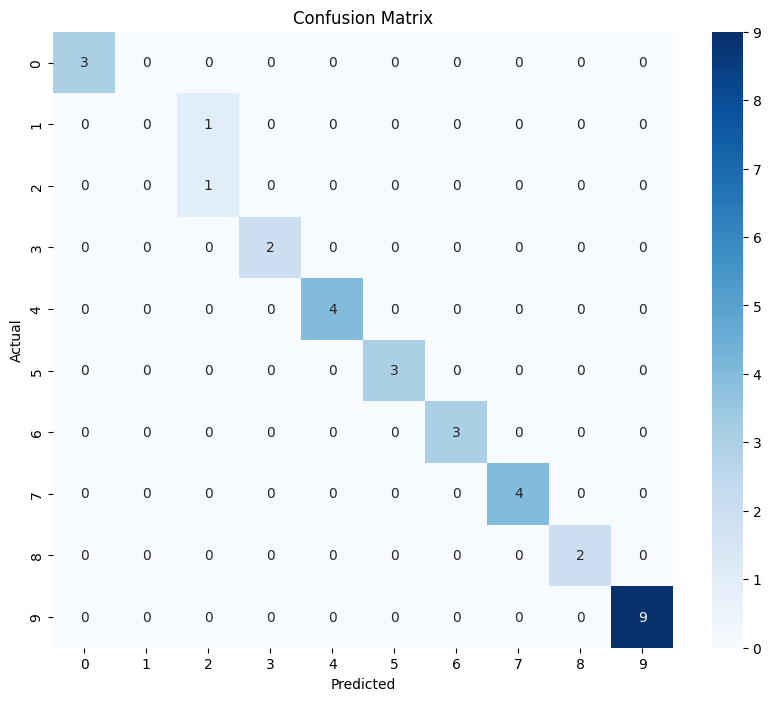

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



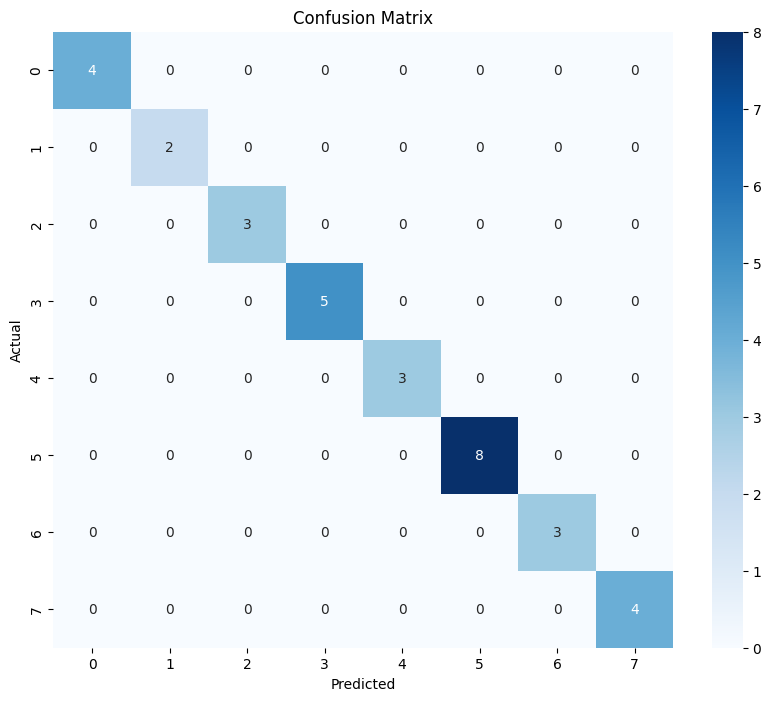

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       0.75      0.75      0.75         4
           9       1.00      1.00      1.00         2

    accuracy                           0.94        32
   macro avg       0.96      0.93      0.93        32
weighted avg       0.94      0.94      0.93        32



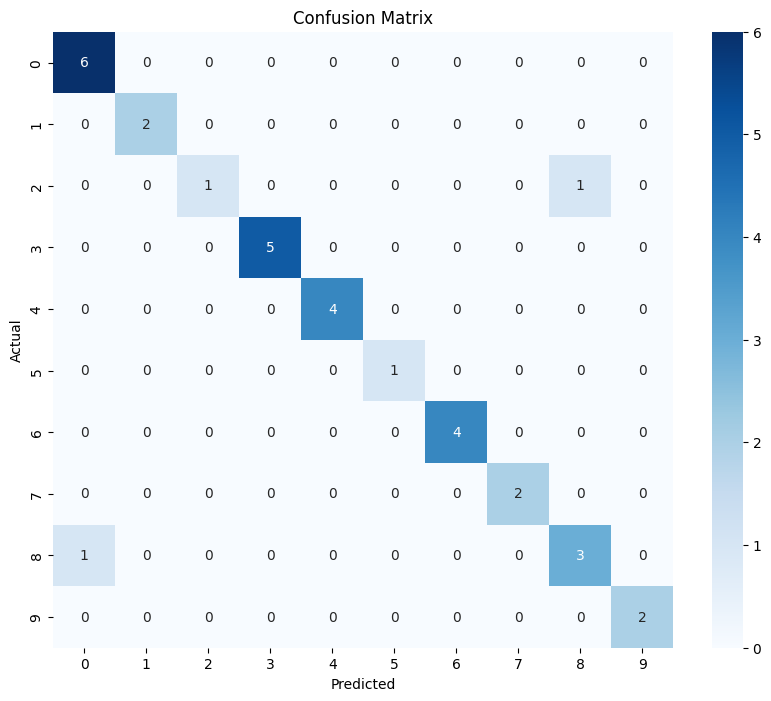

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.95      0.97      0.95        32
weighted avg       0.98      0.97      0.97        32



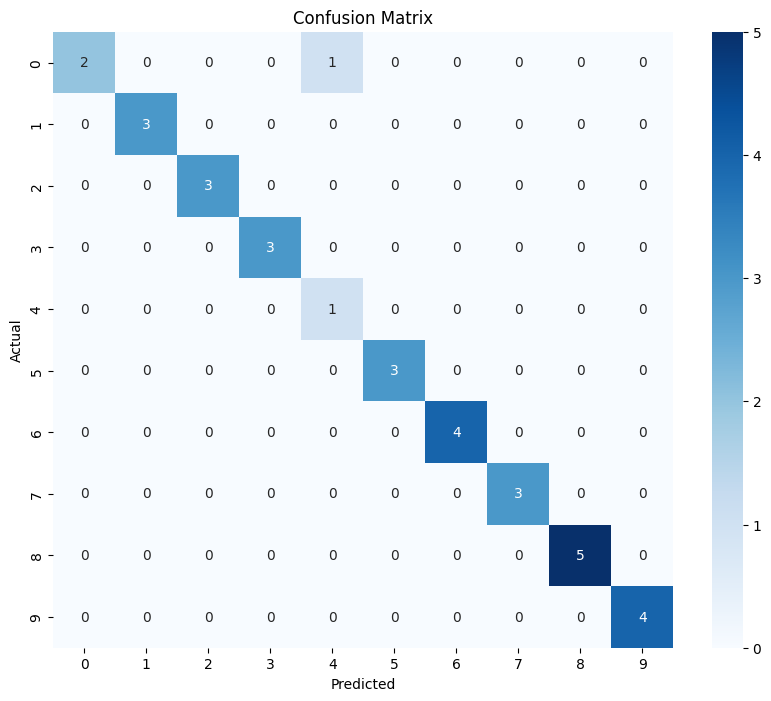

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



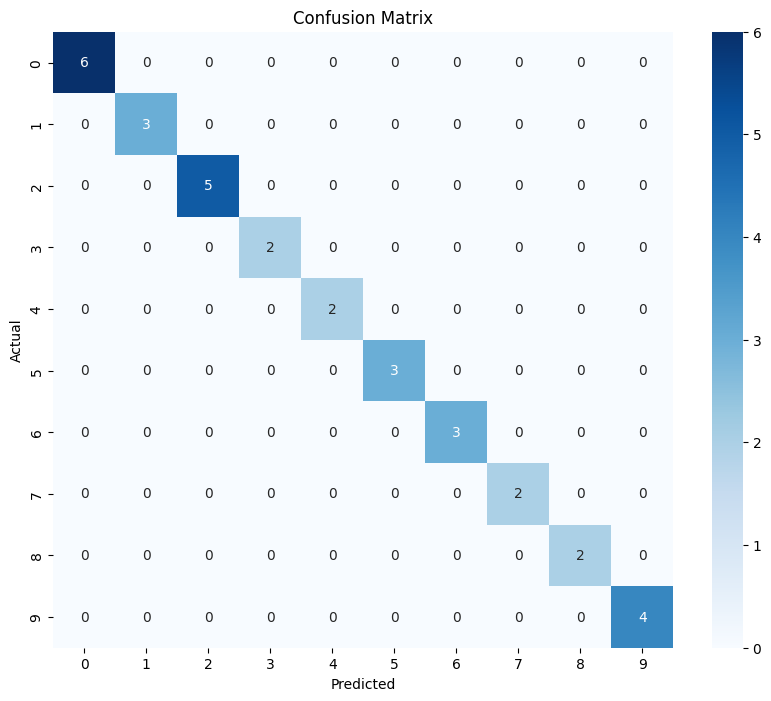

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



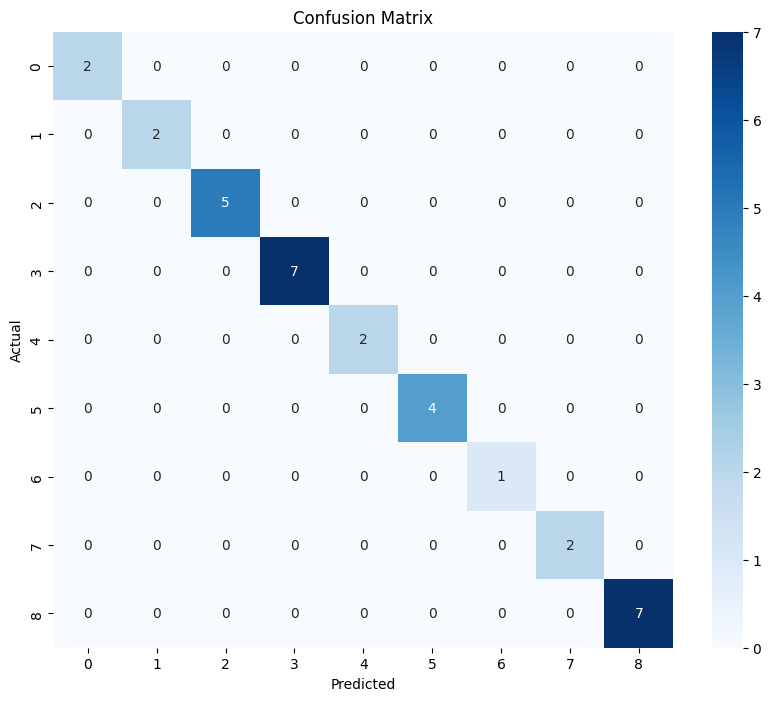

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.97        32
   macro avg       0.98      0.99      0.98        32
weighted avg       0.97      0.97      0.97        32



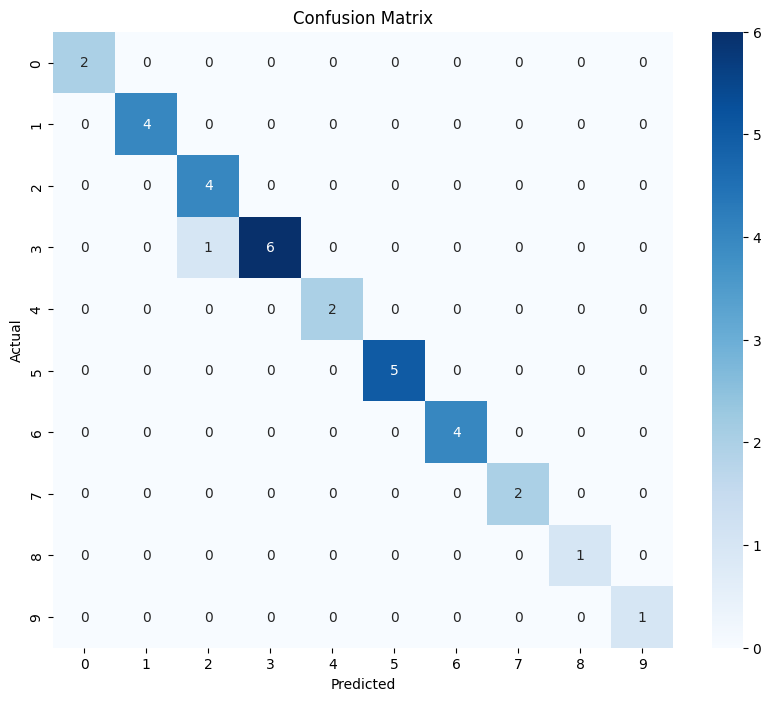

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.97      0.95      0.95        32
weighted avg       0.98      0.97      0.97        32



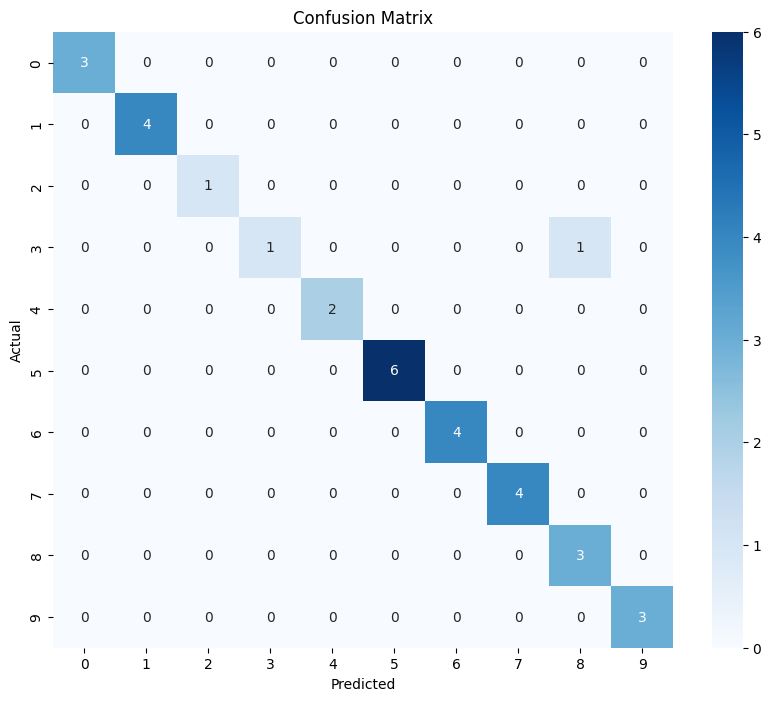

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



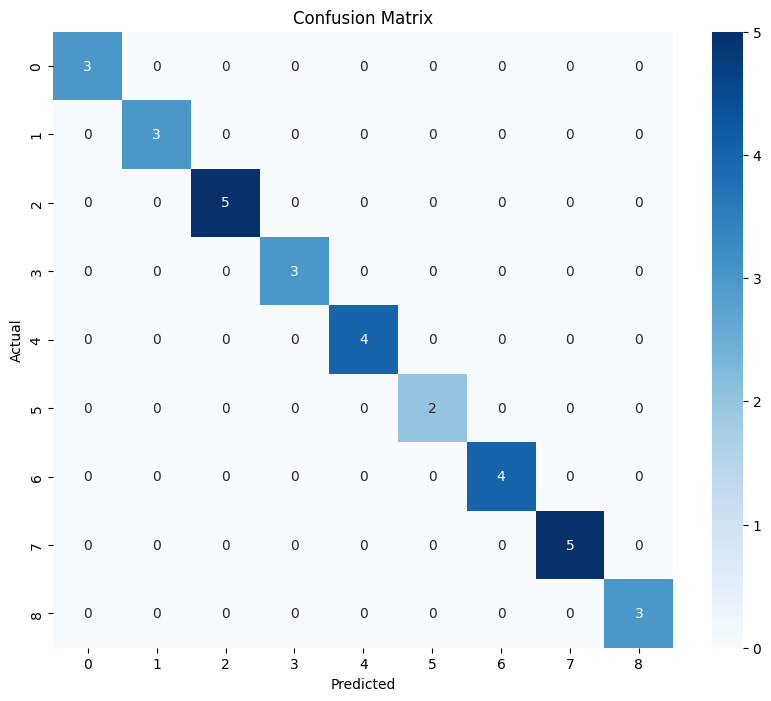

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.98      0.97      0.97        32



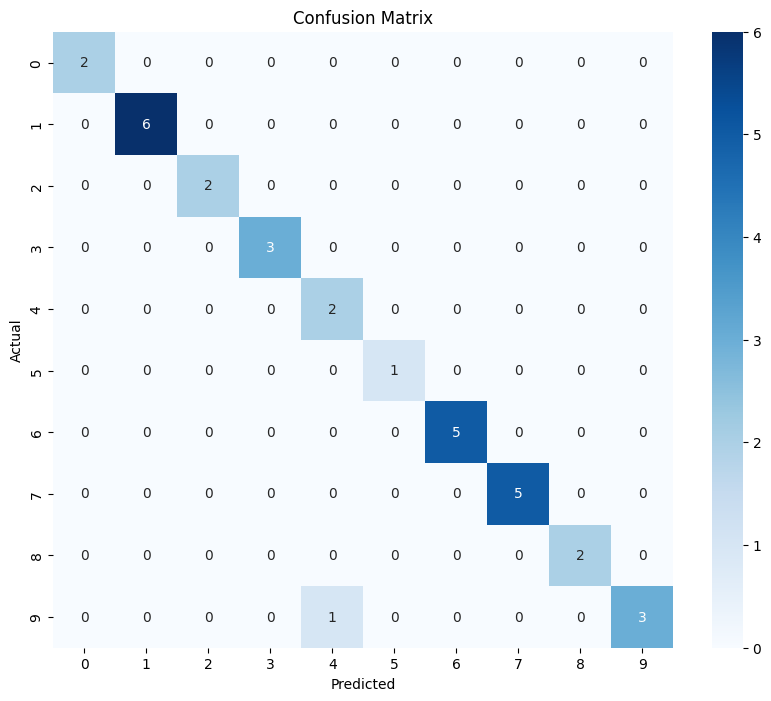

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       0.75      1.00      0.86         3
           8       0.75      1.00      0.86         3
           9       1.00      0.67      0.80         6

    accuracy                           0.91        32
   macro avg       0.92      0.92      0.90        32
weighted avg       0.93      0.91      0.90        32



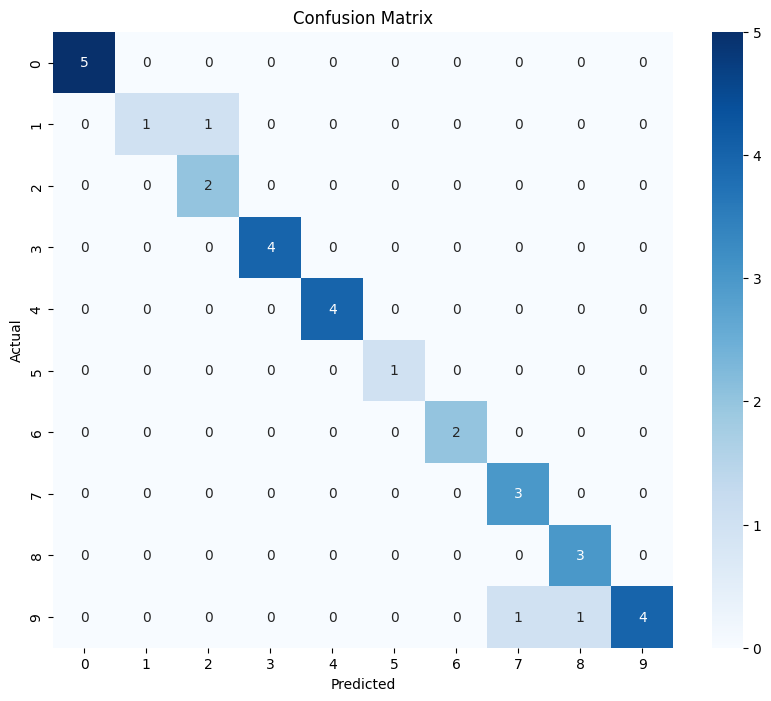

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.98      0.97      0.97        32



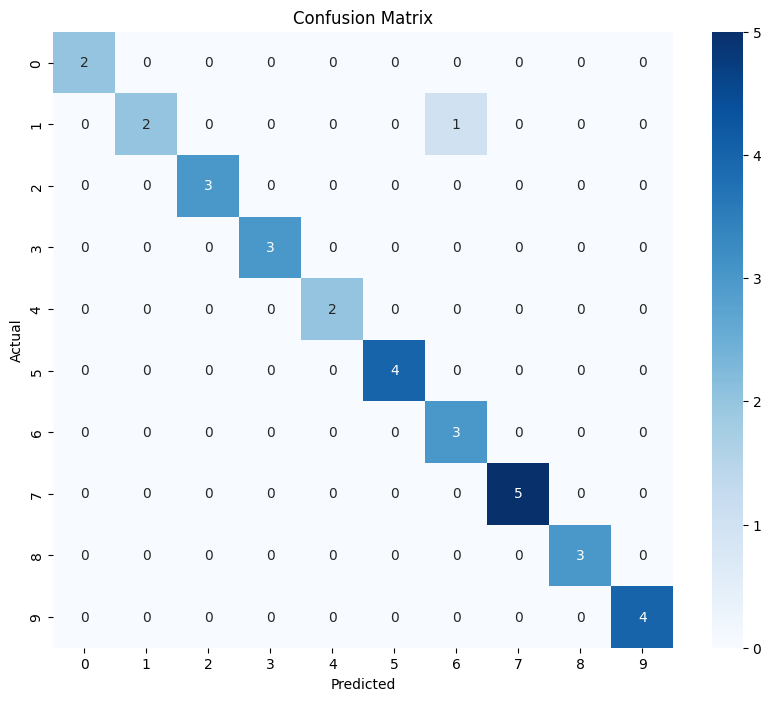

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



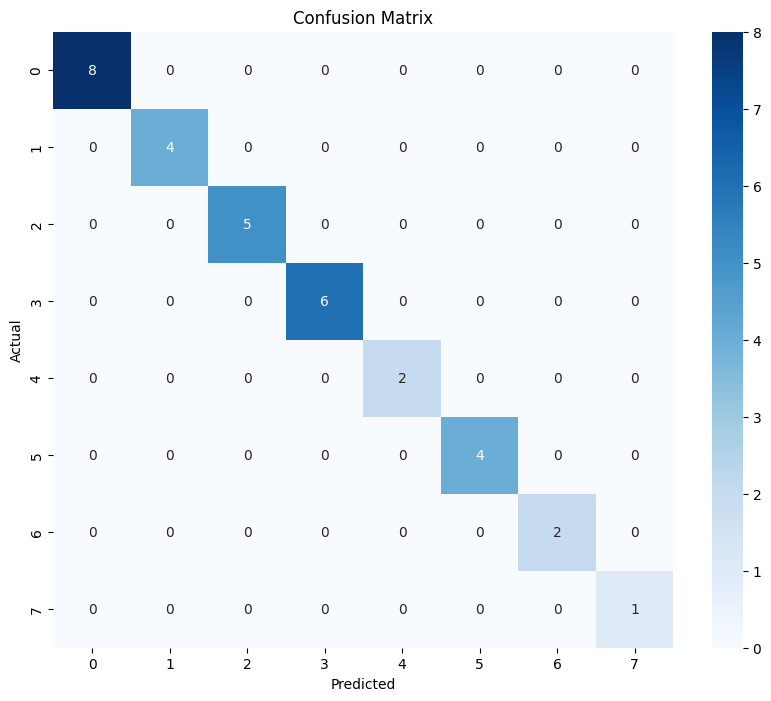

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



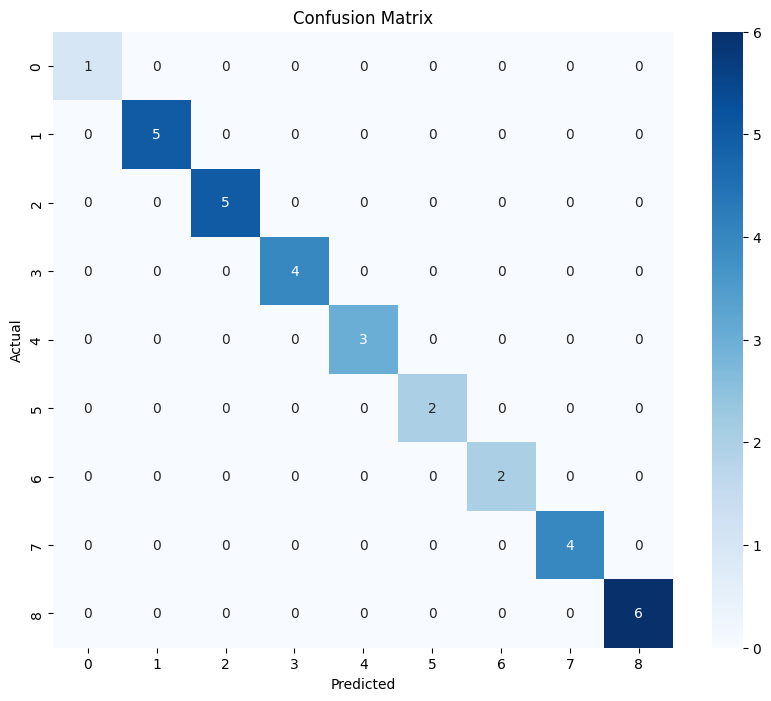

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



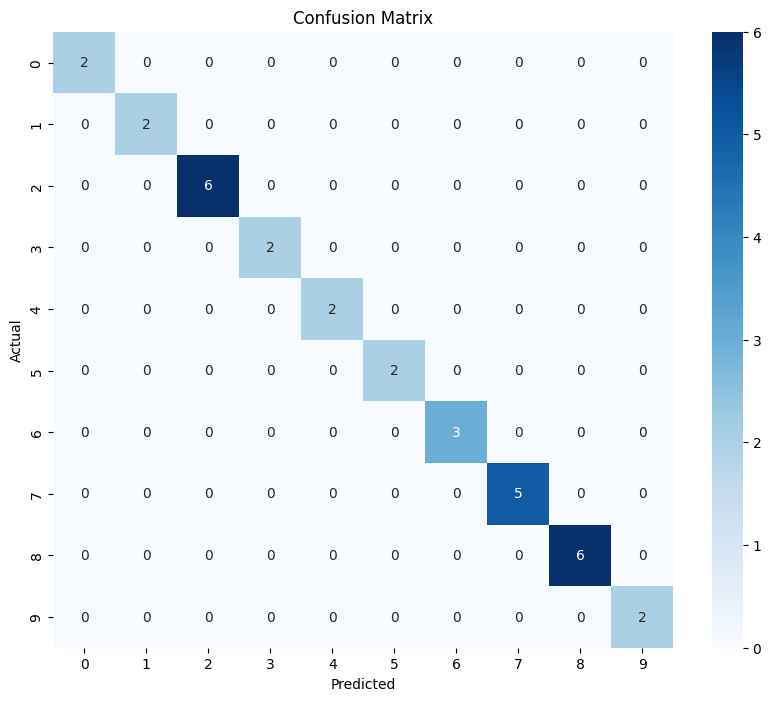

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



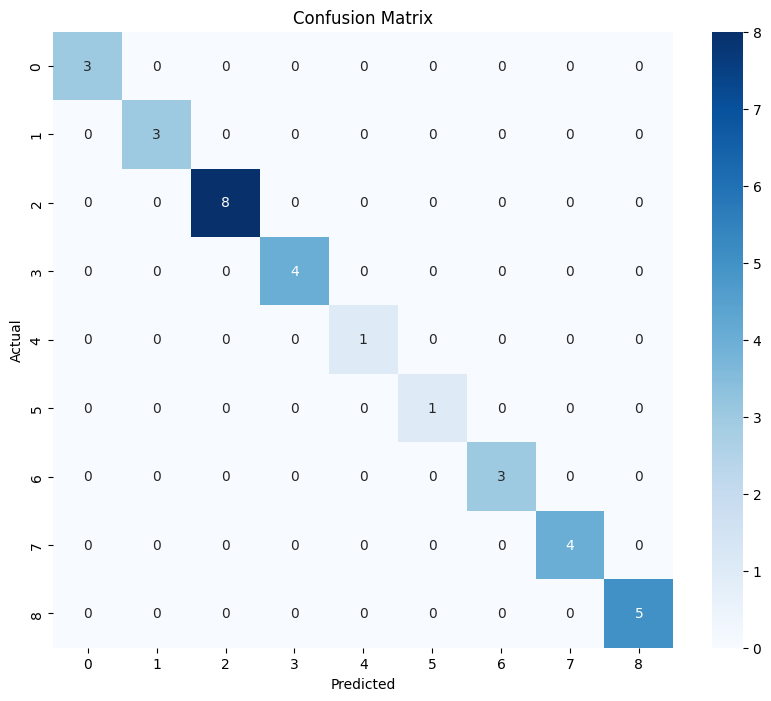

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



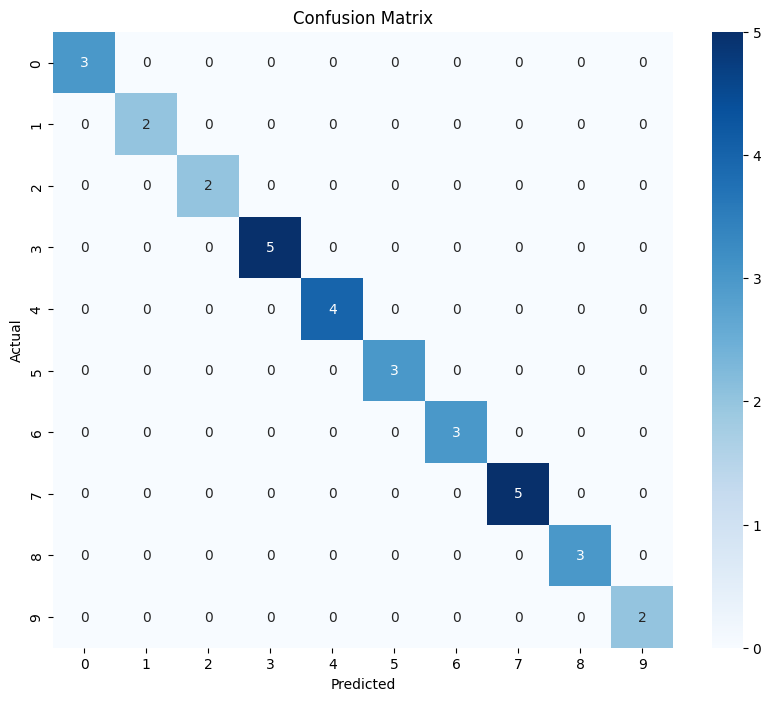

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



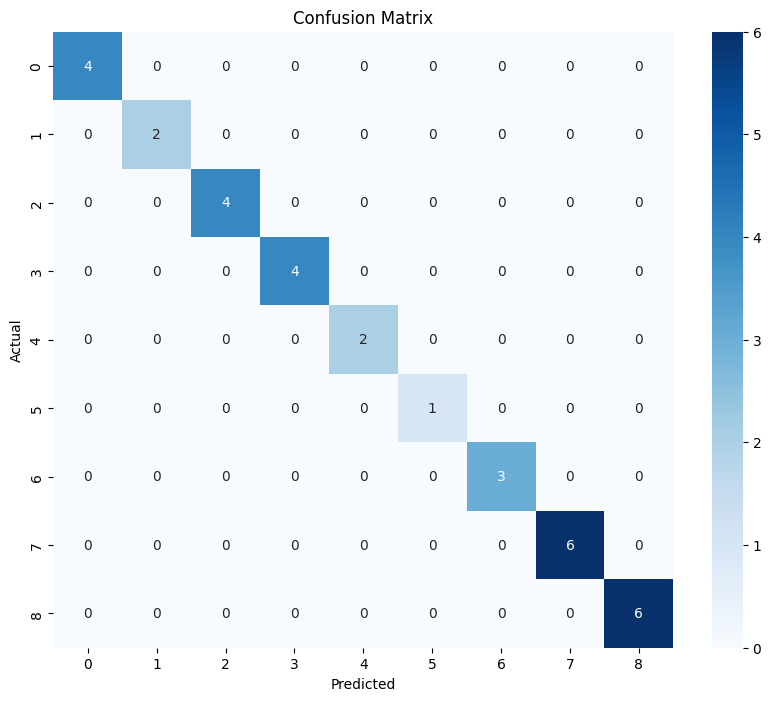

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



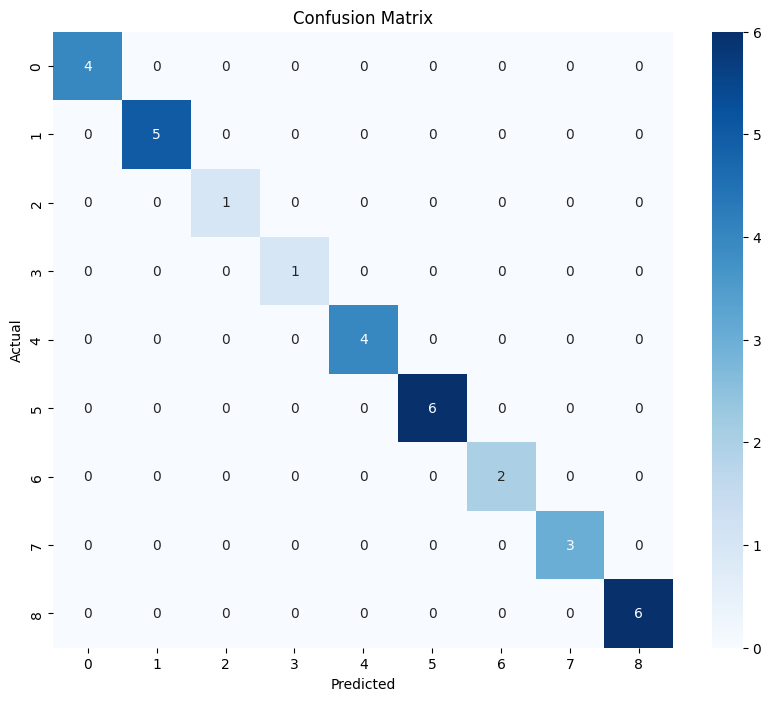

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



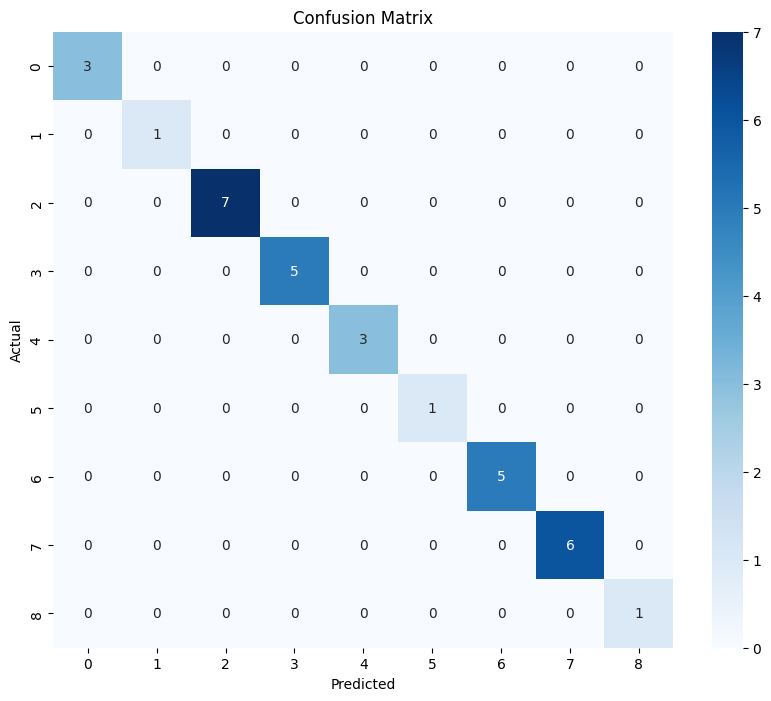

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



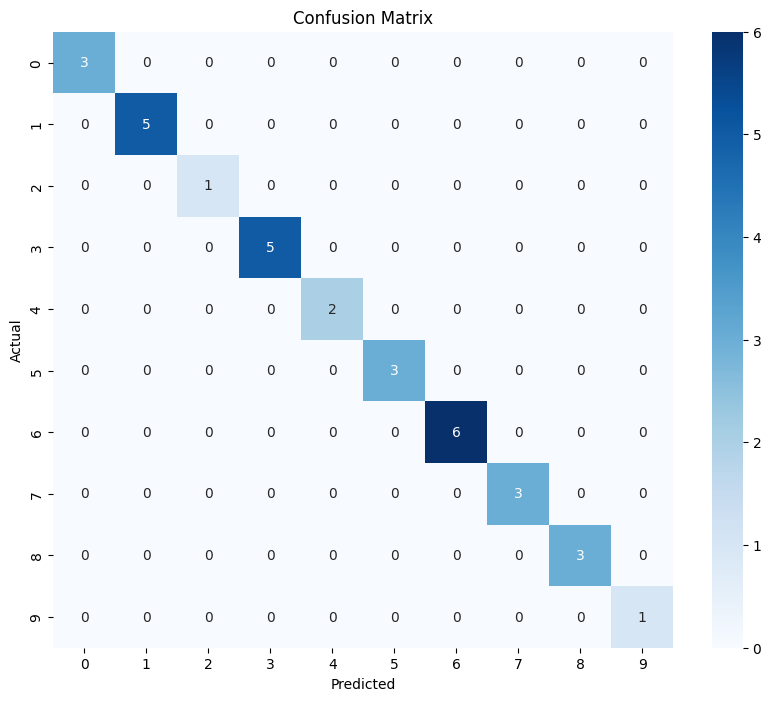

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



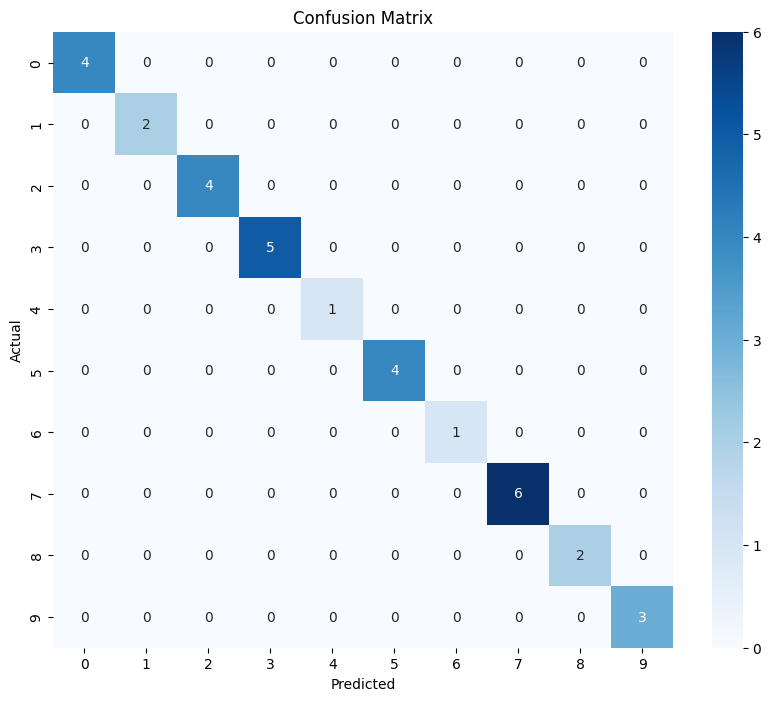

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



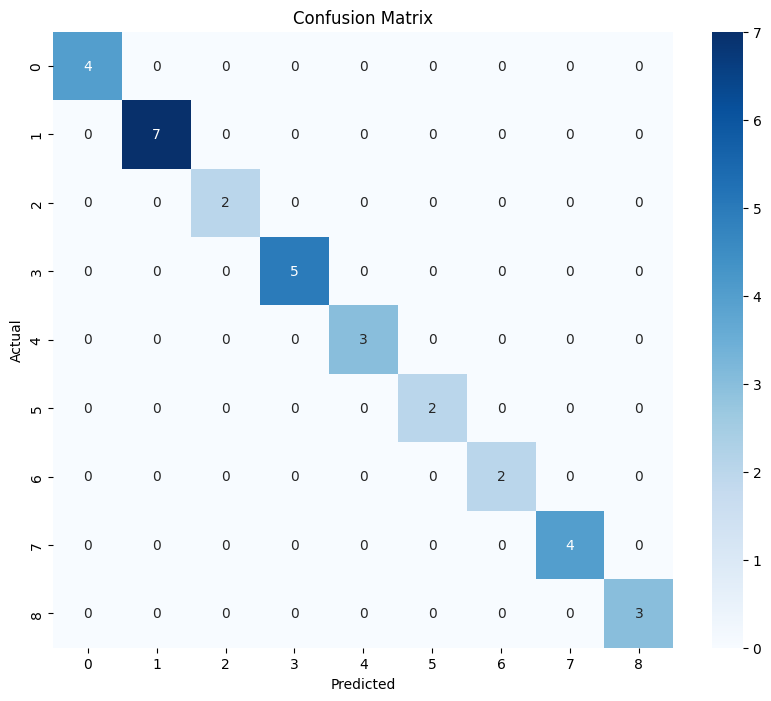

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



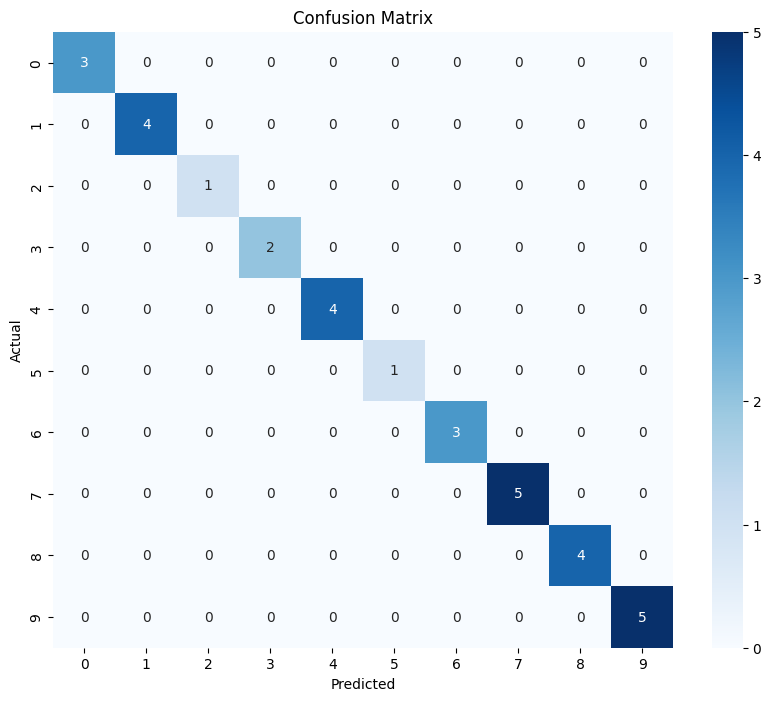

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



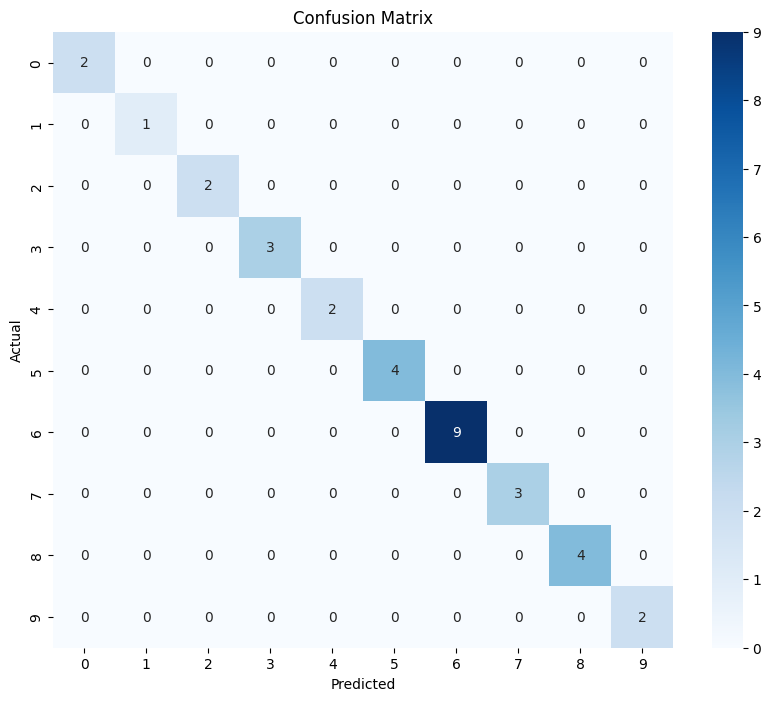

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



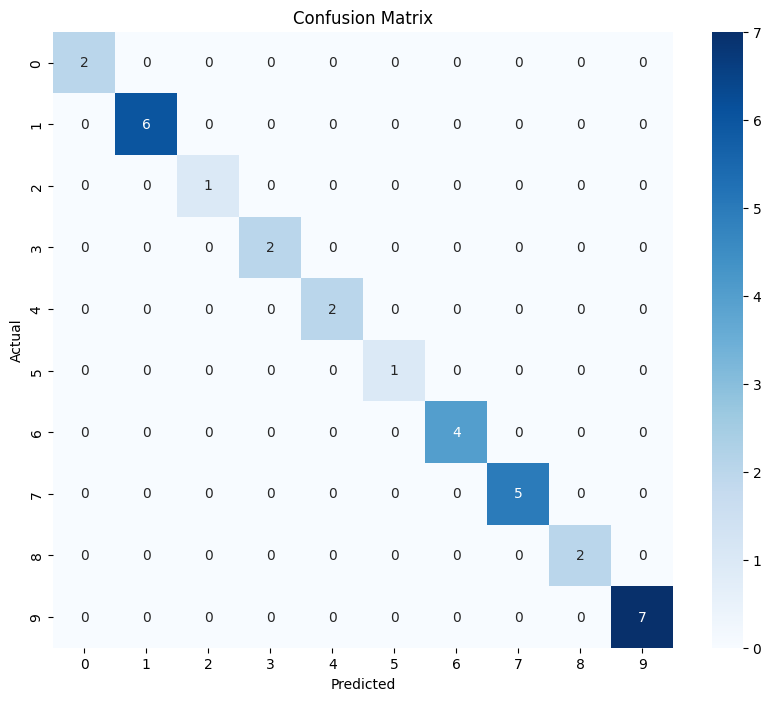

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



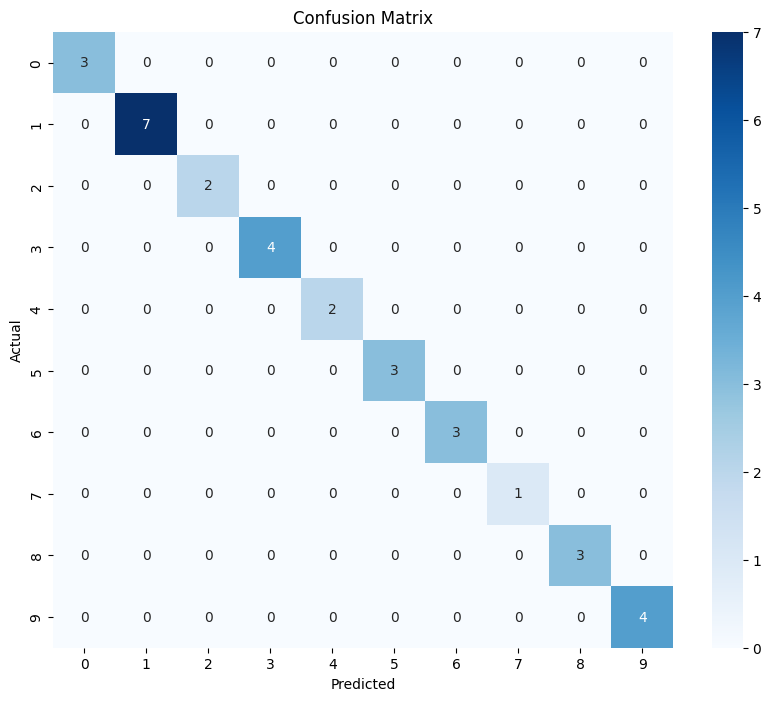

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



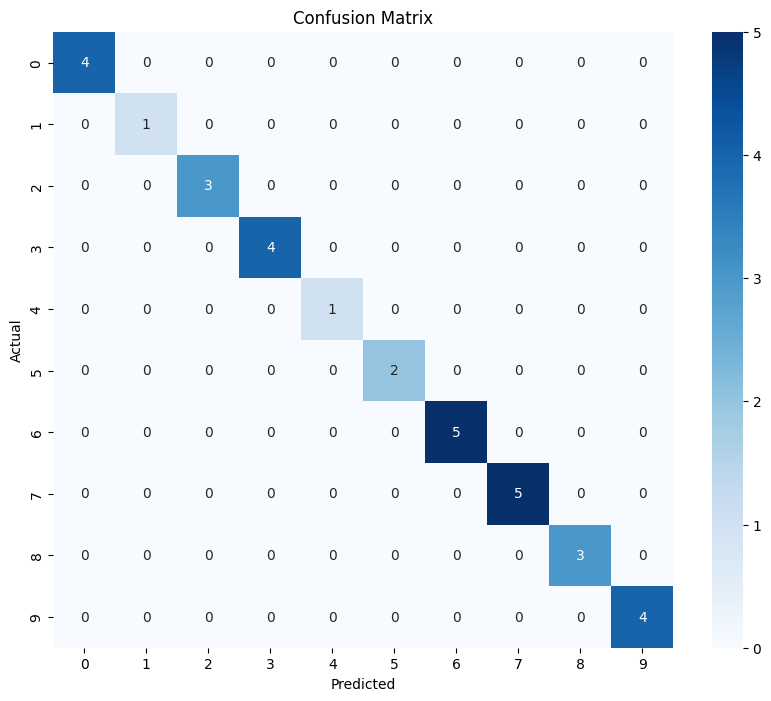

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



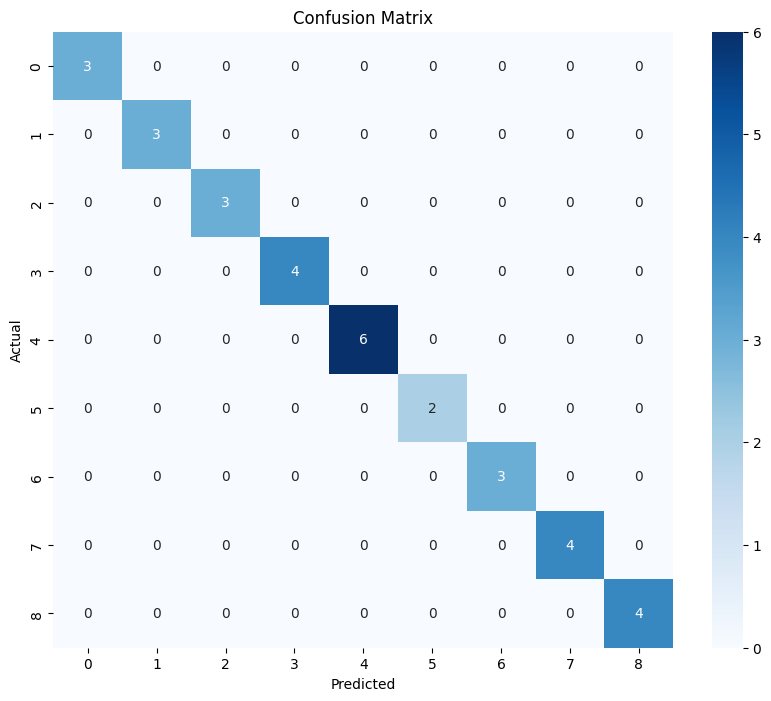

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



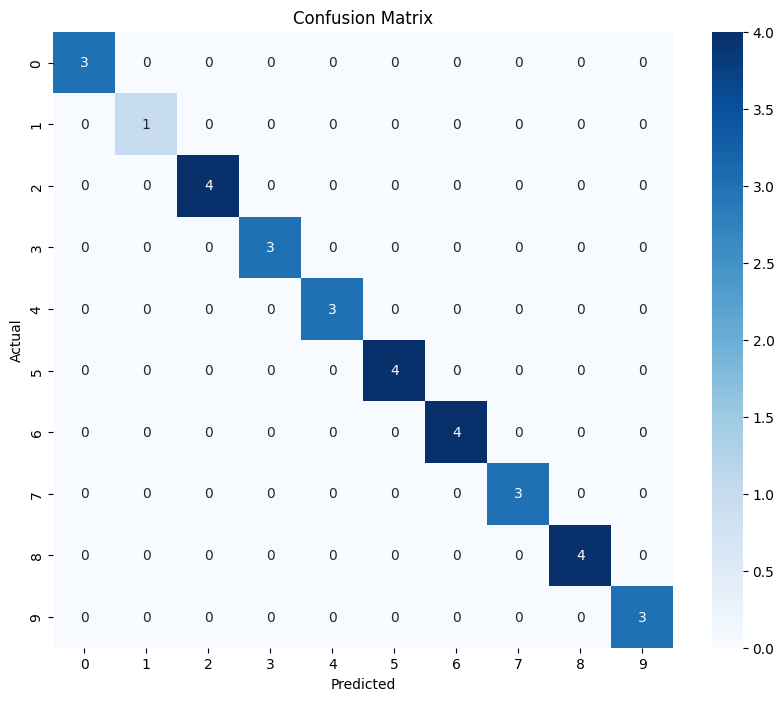

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         1
           9       0.75      1.00      0.86         3

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.98      0.97      0.97        32



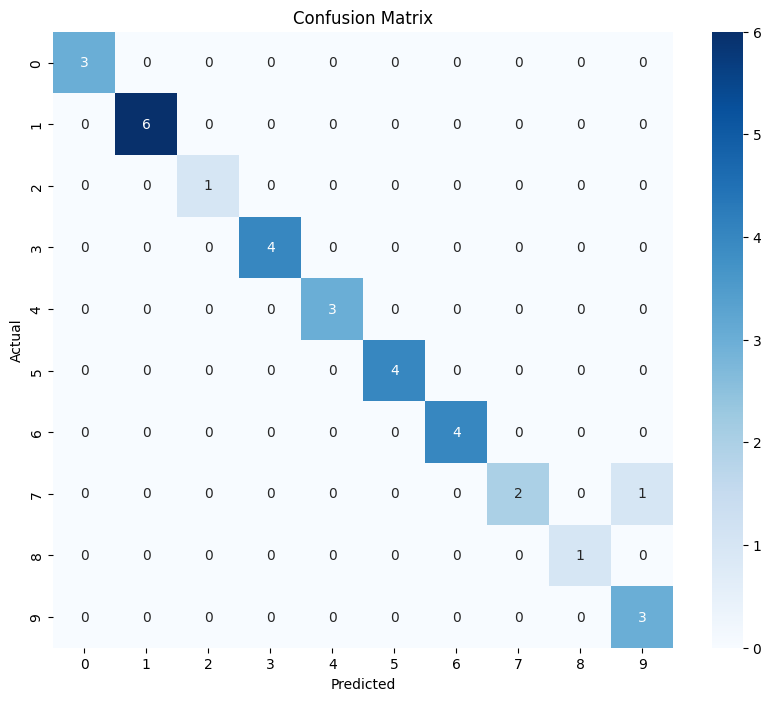

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



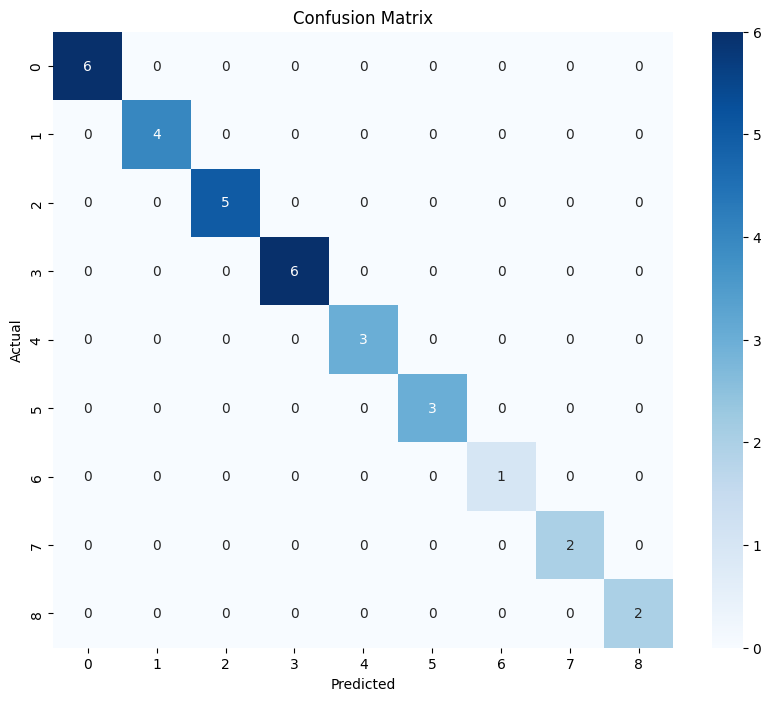

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



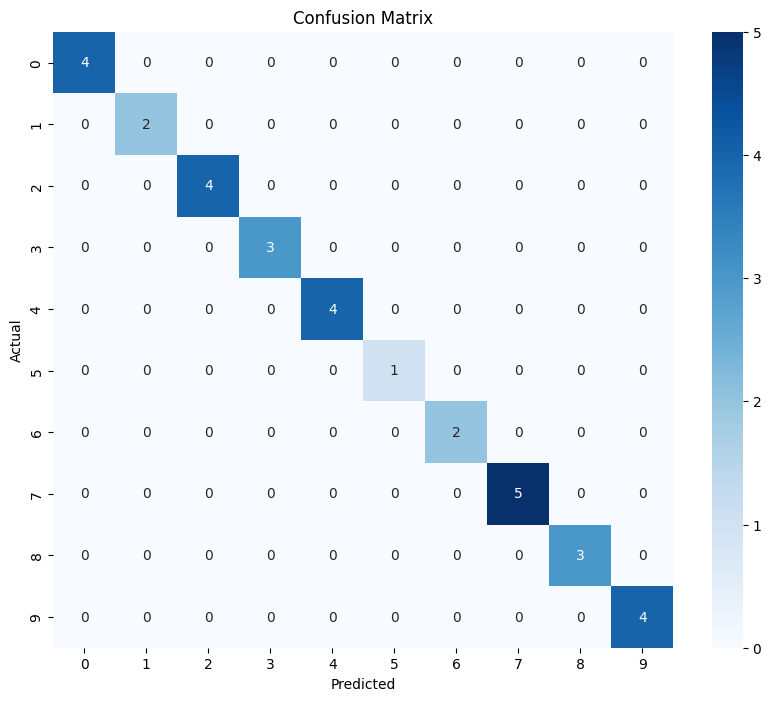

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



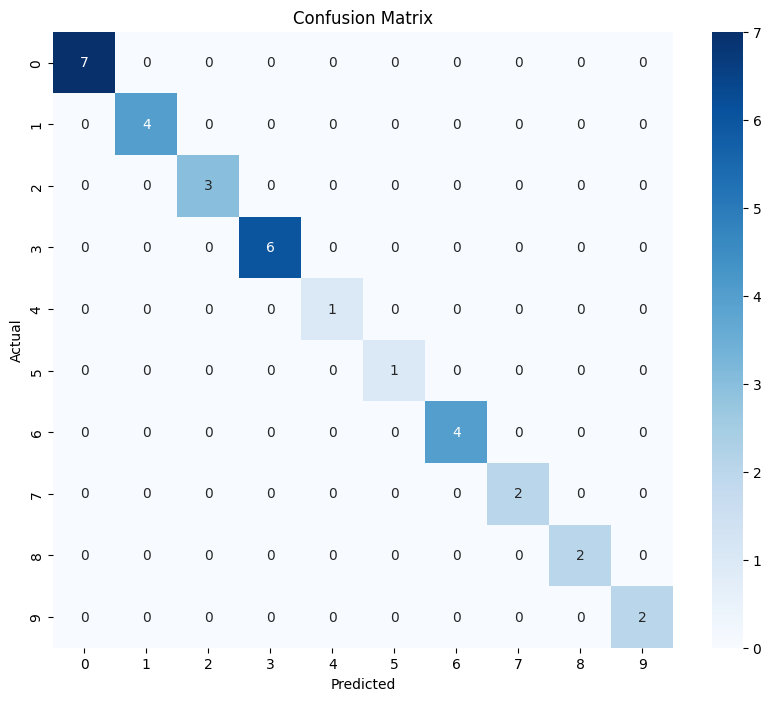

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         5
           4       0.86      1.00      0.92         6
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.80      0.89         5
           9       1.00      0.75      0.86         4

    accuracy                           0.94        32
   macro avg       0.96      0.95      0.95        32
weighted avg       0.95      0.94      0.94        32



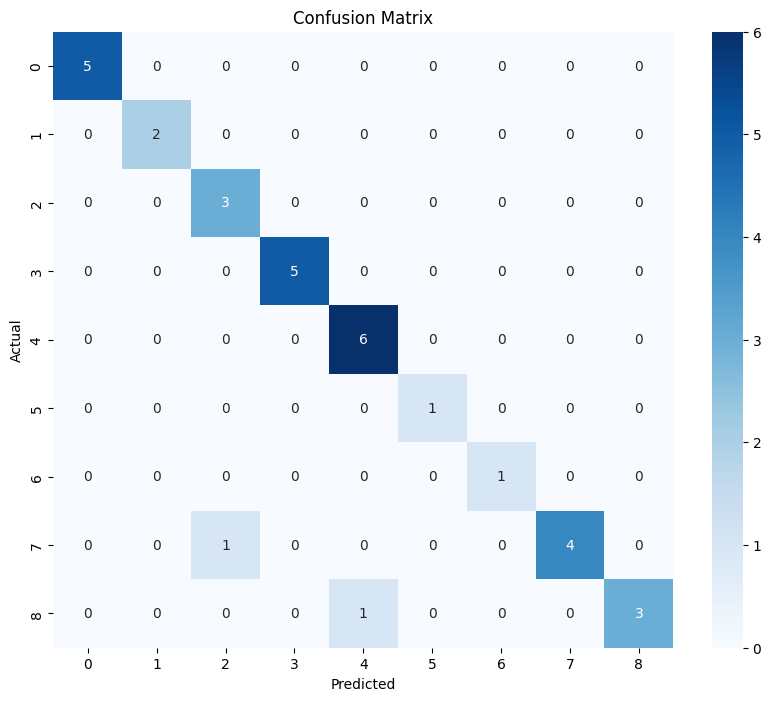

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



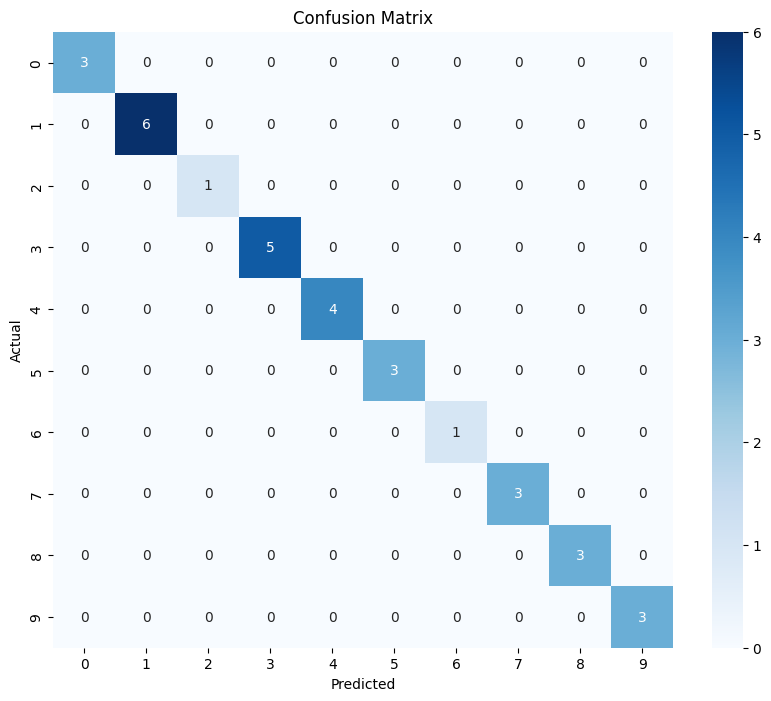

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



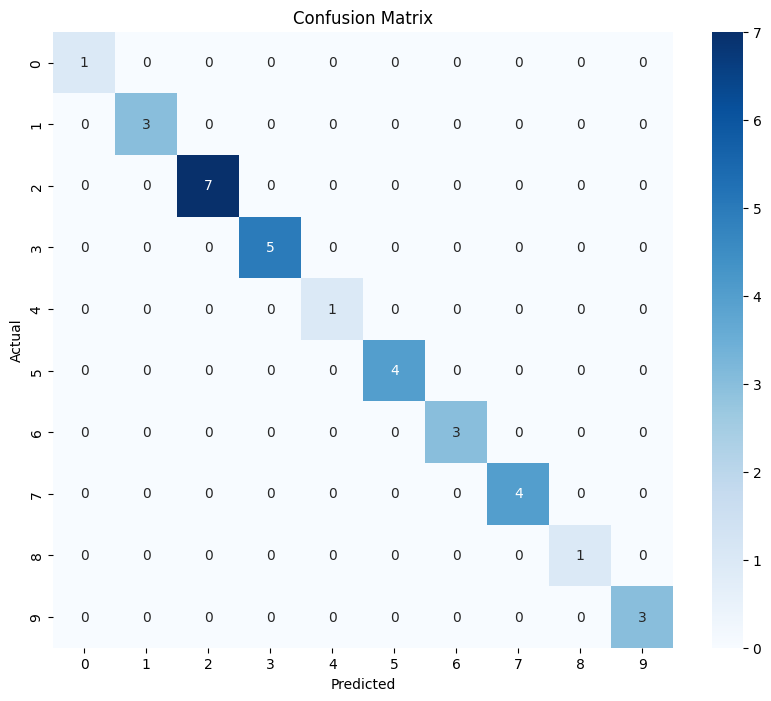

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



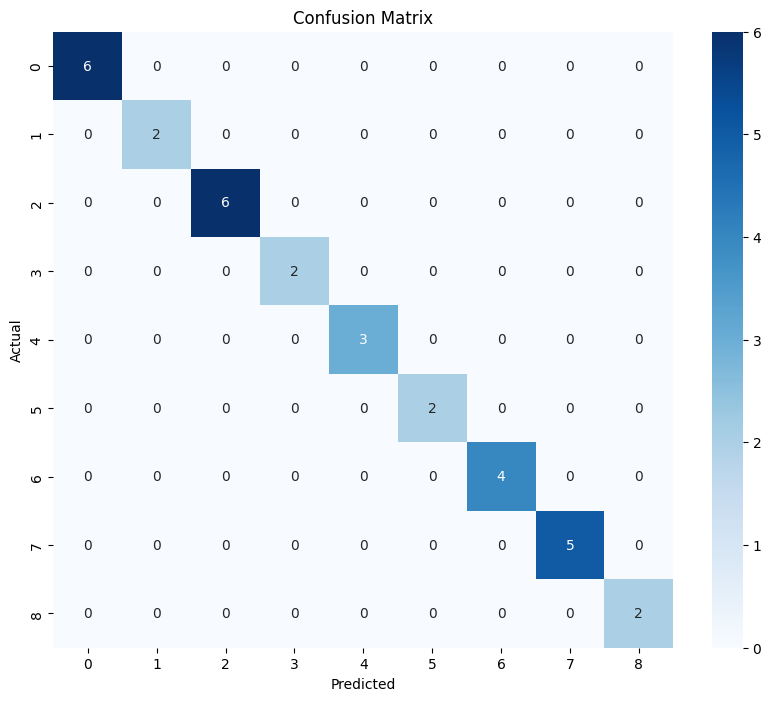

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



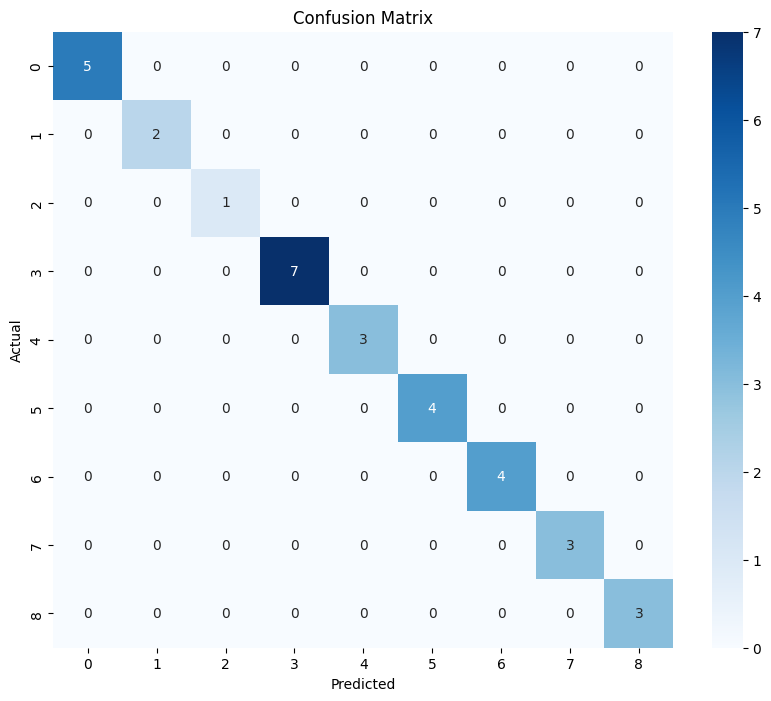

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



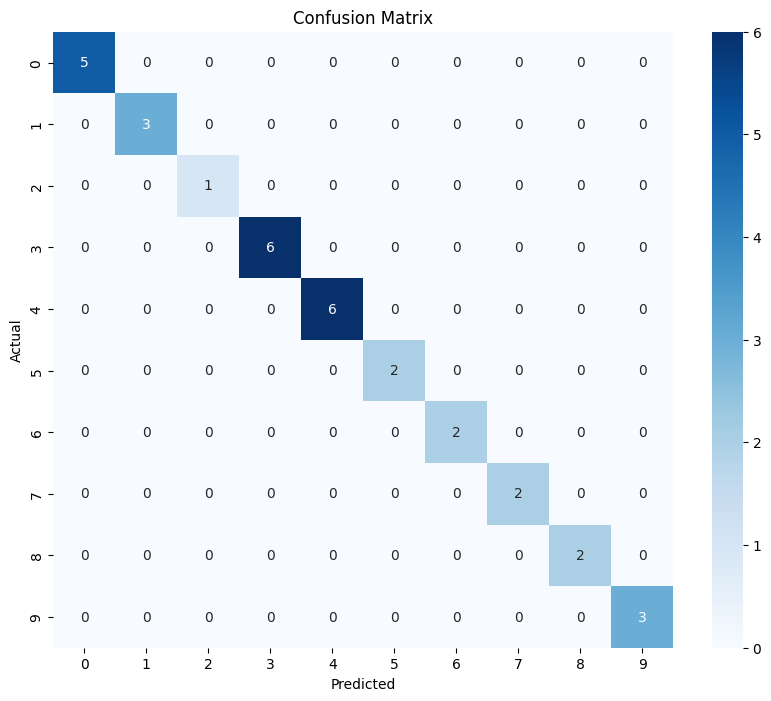

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



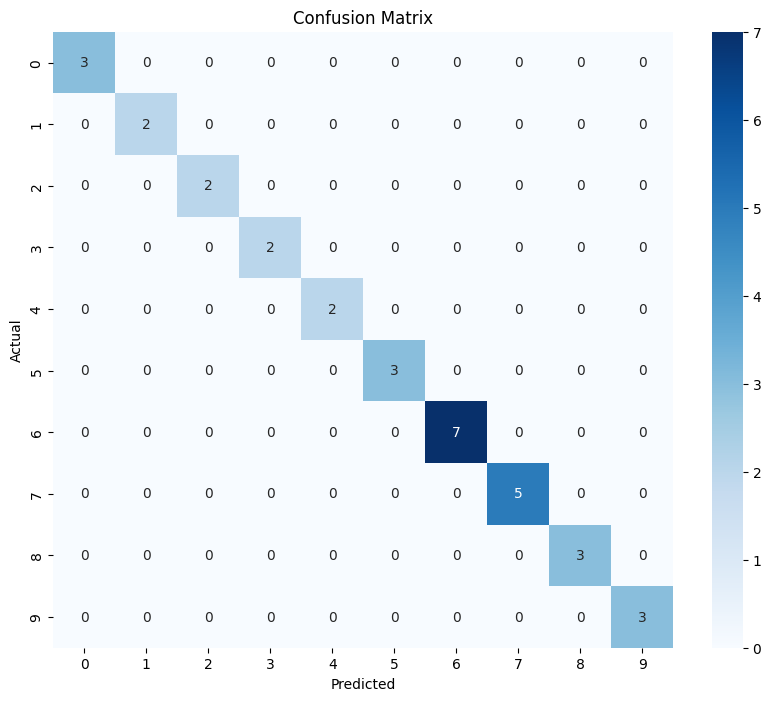

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



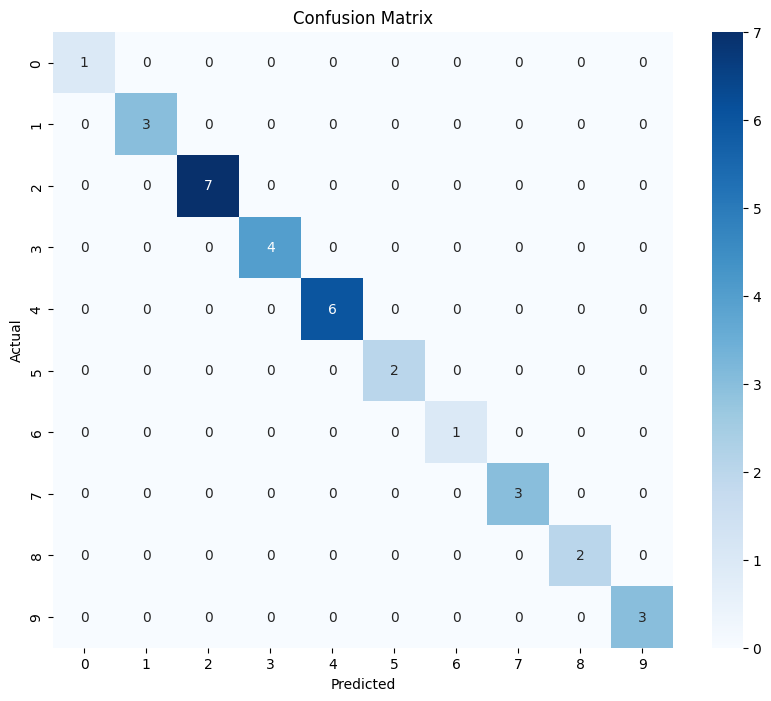

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         4
           9       1.00      0.83      0.91         6

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



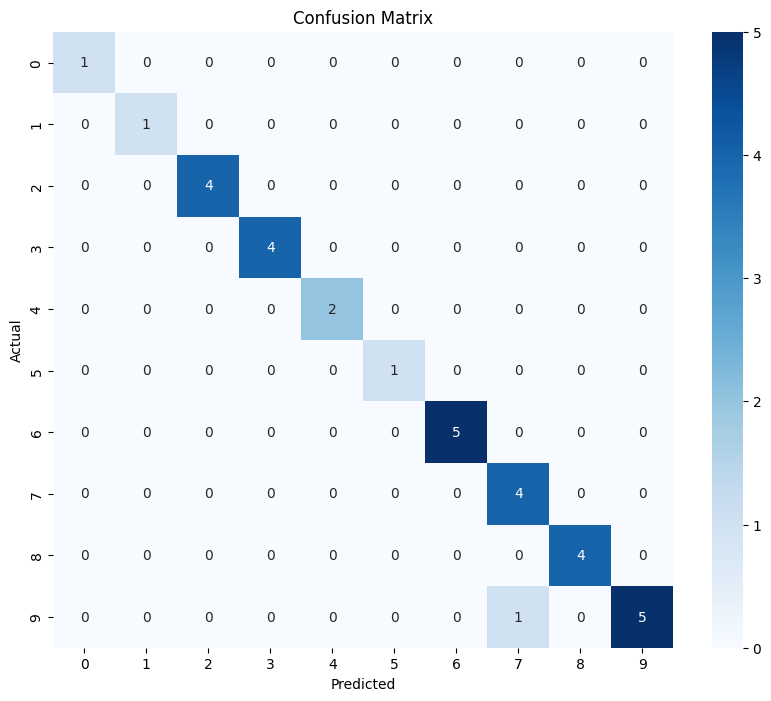

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.98      0.97      0.97        32



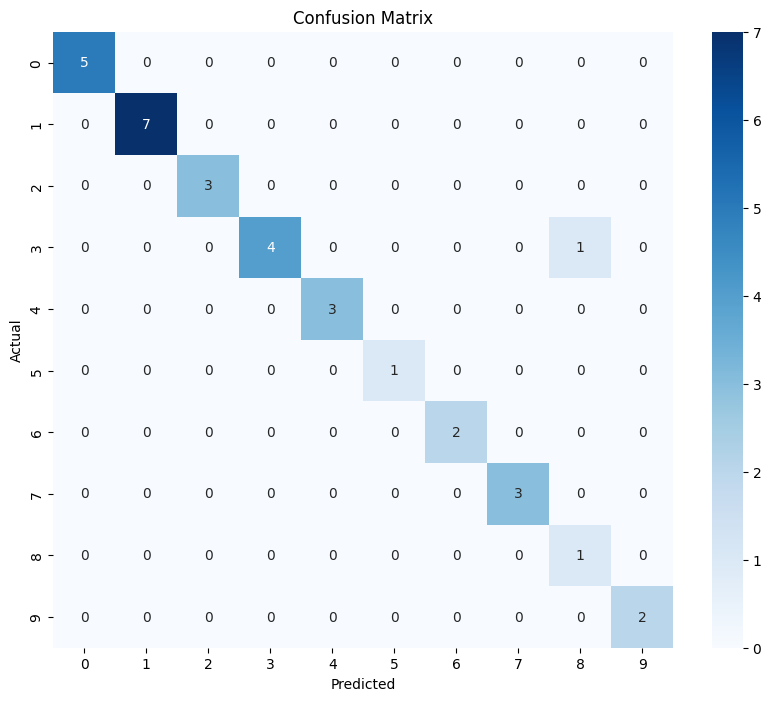

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



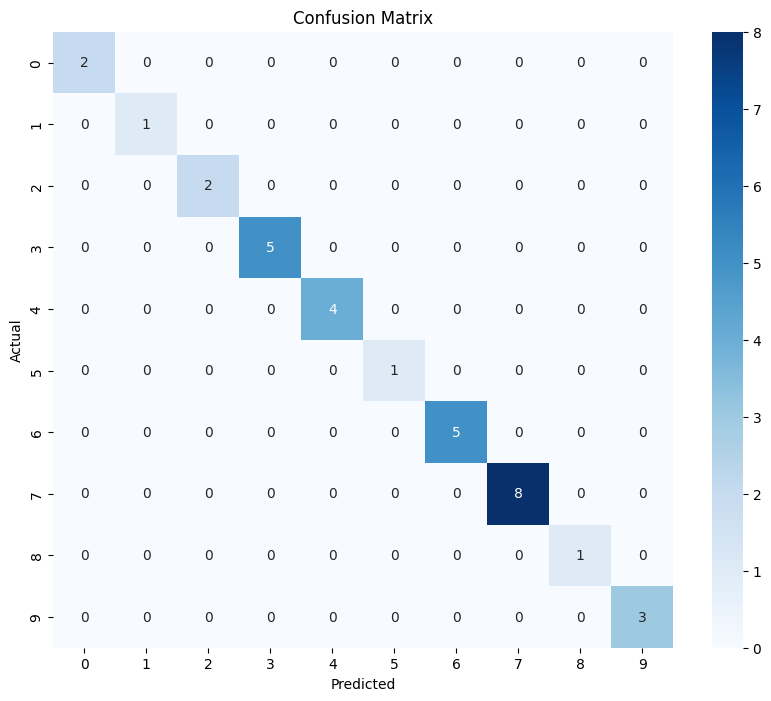

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



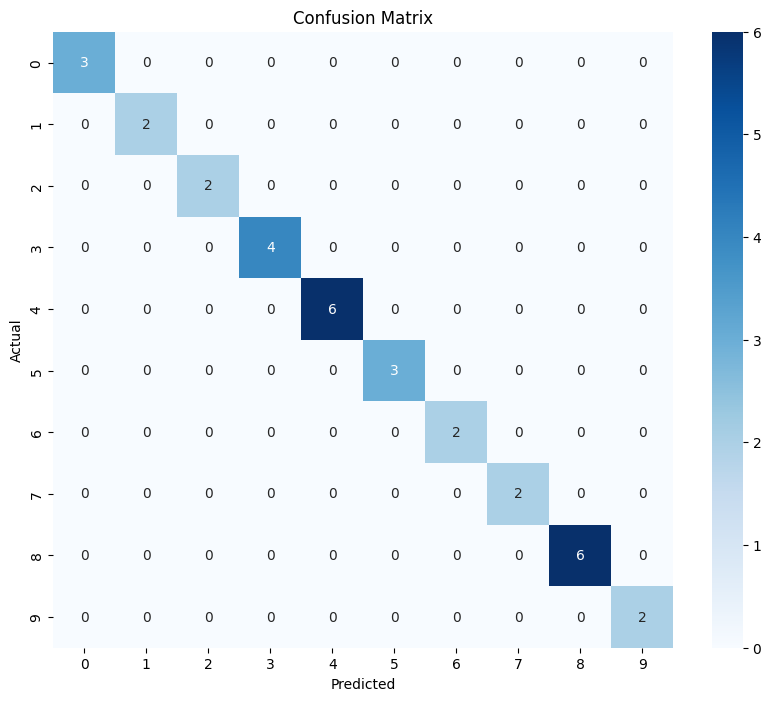

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



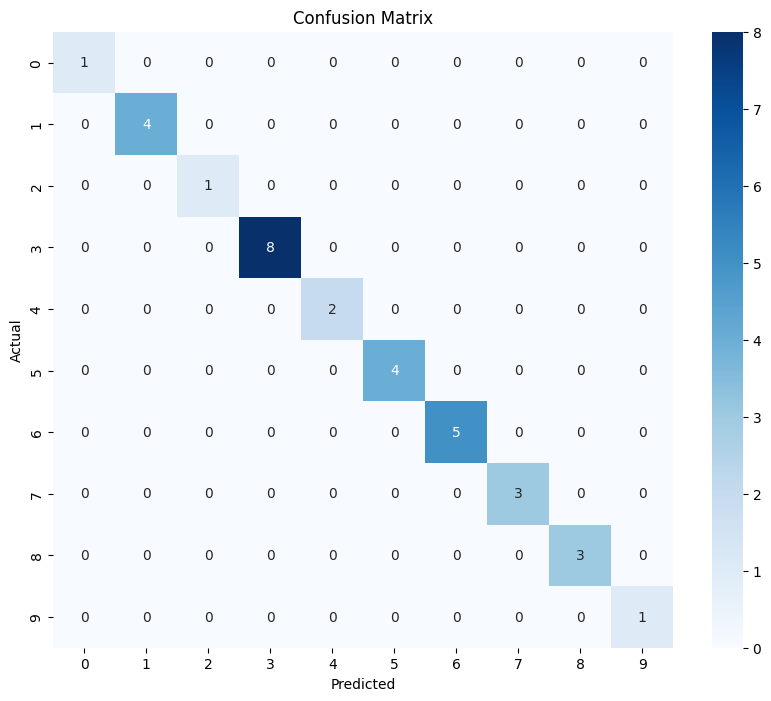

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



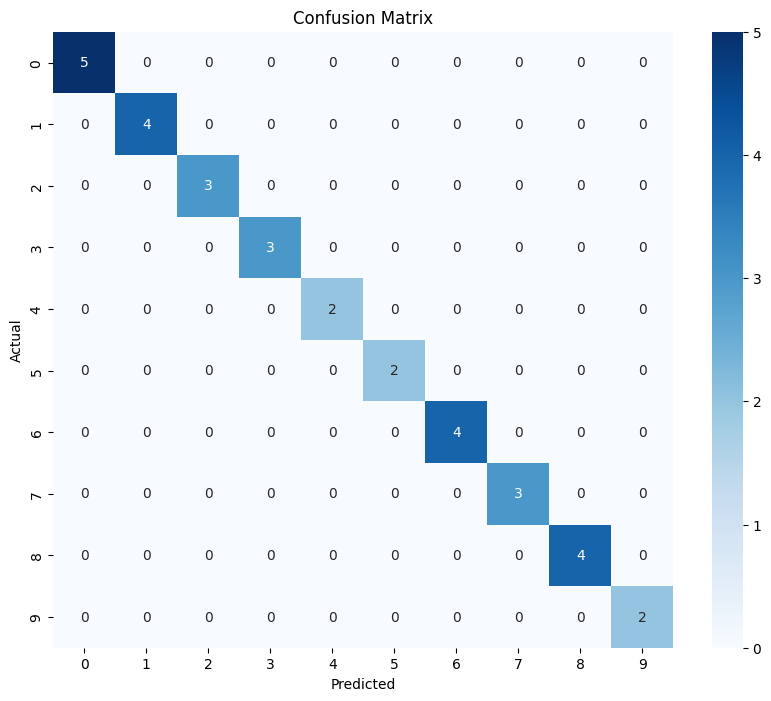

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



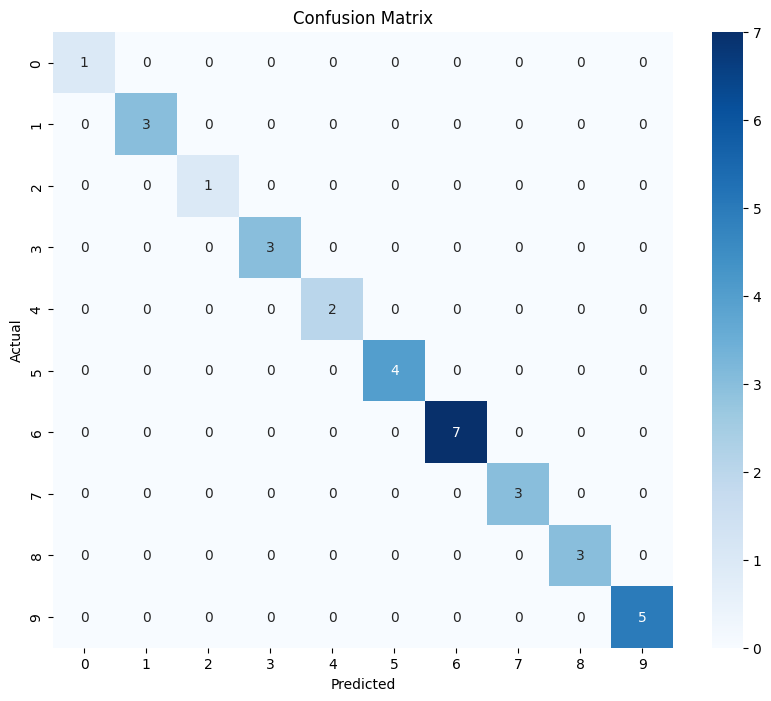

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



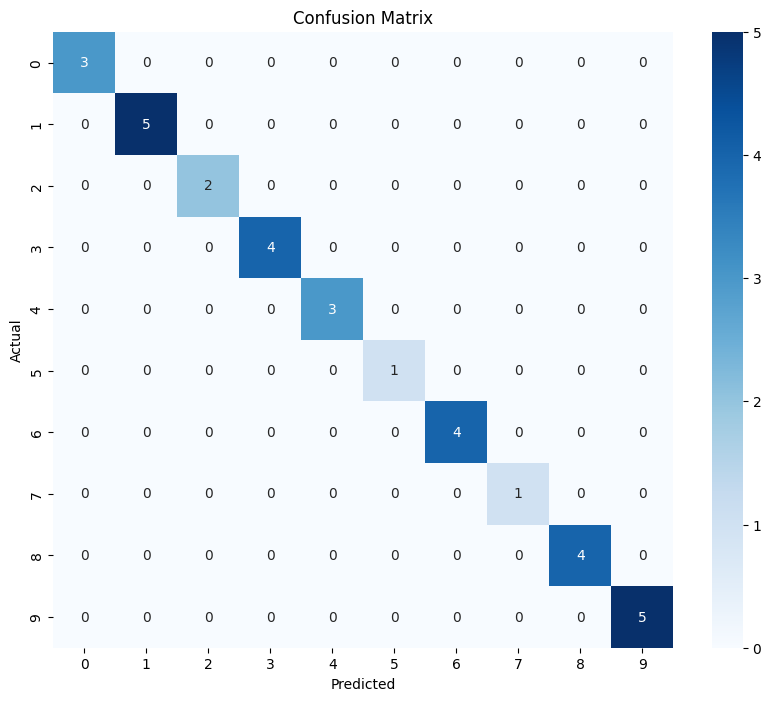

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



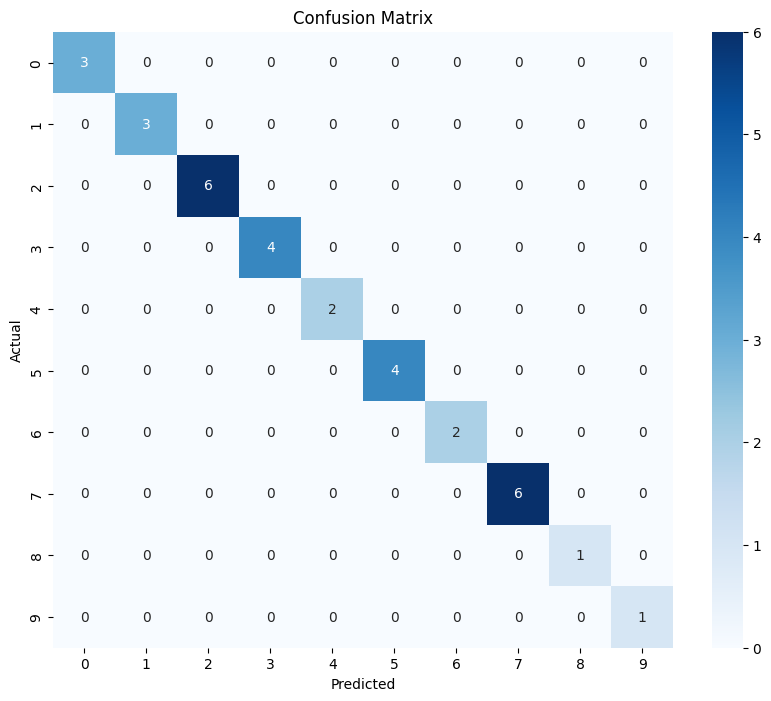

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



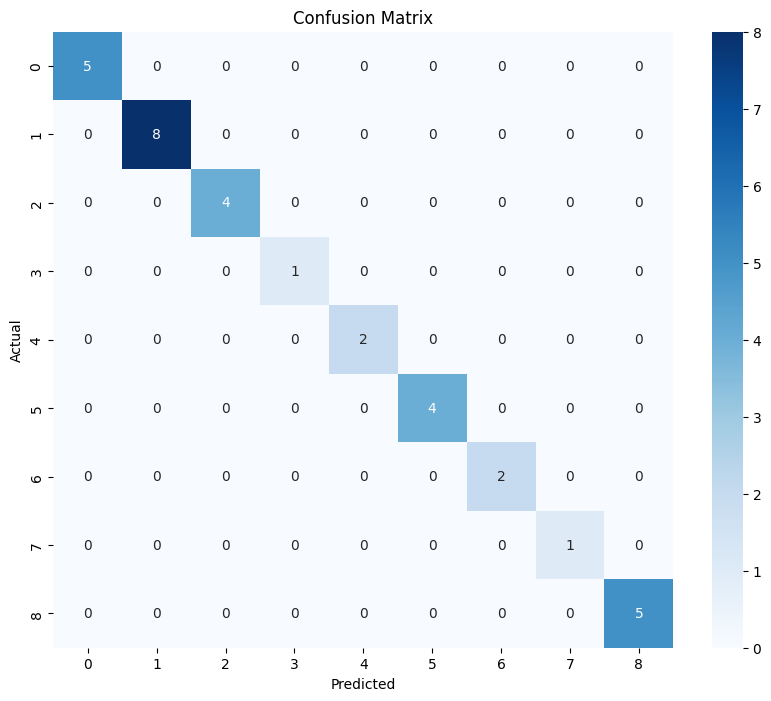

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



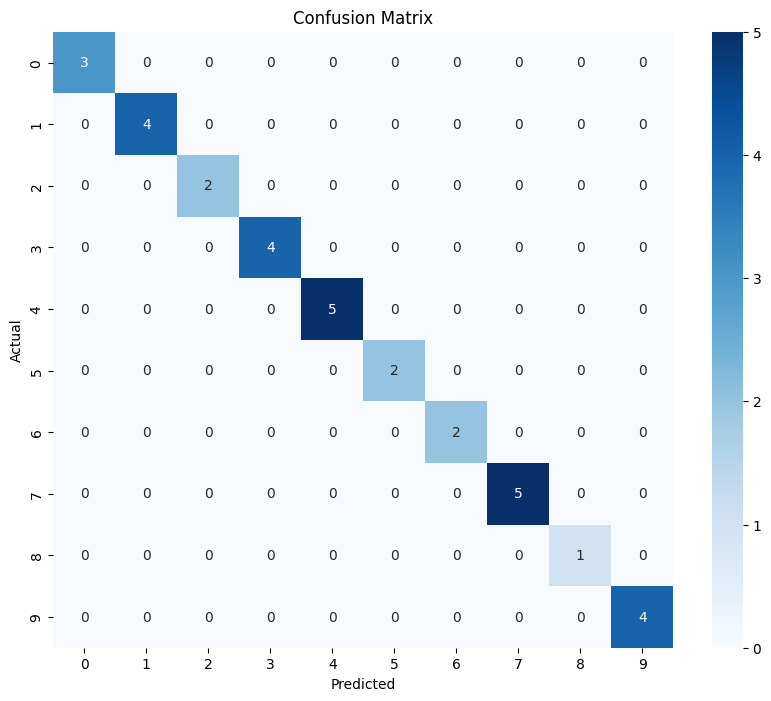

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



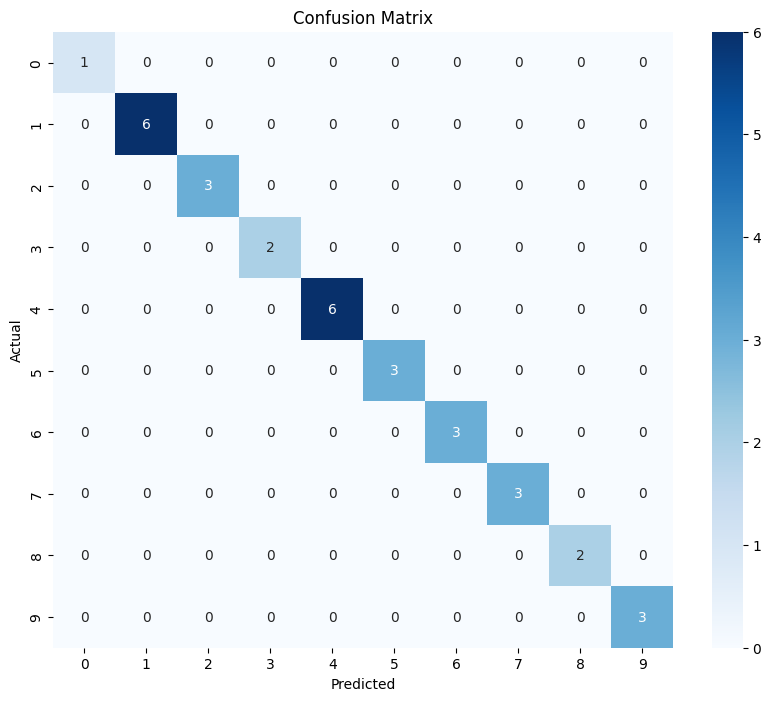

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



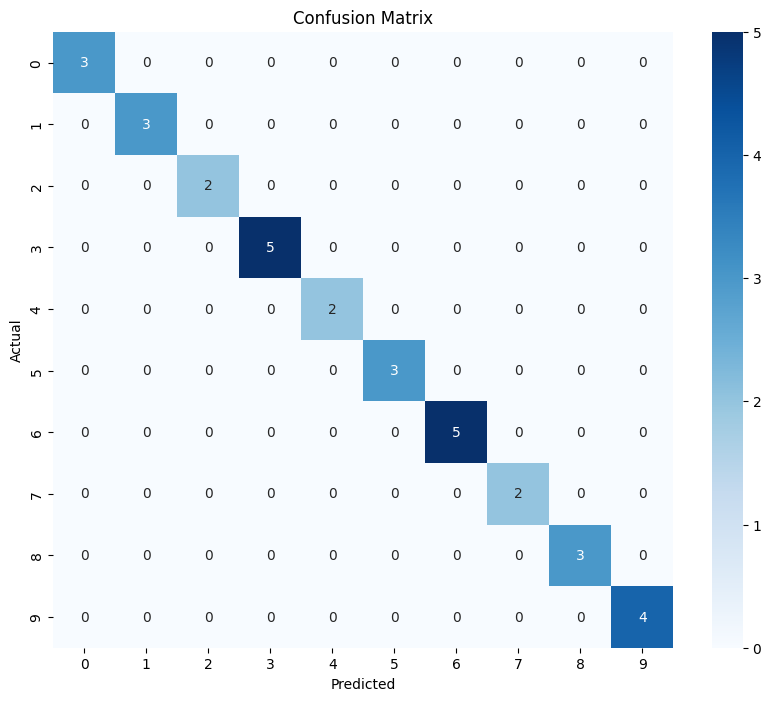

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       0.67      1.00      0.80         2
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.98      0.97      0.97        32



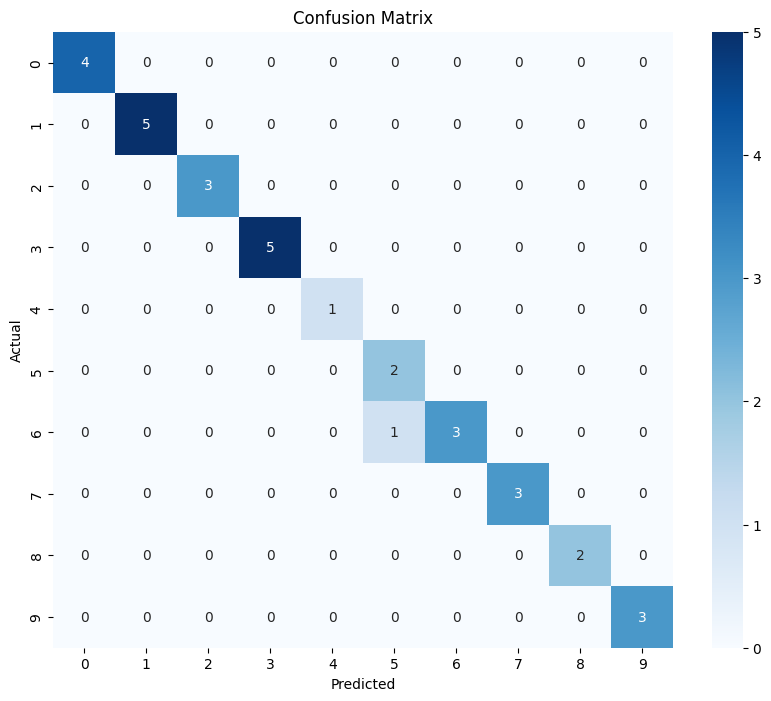

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



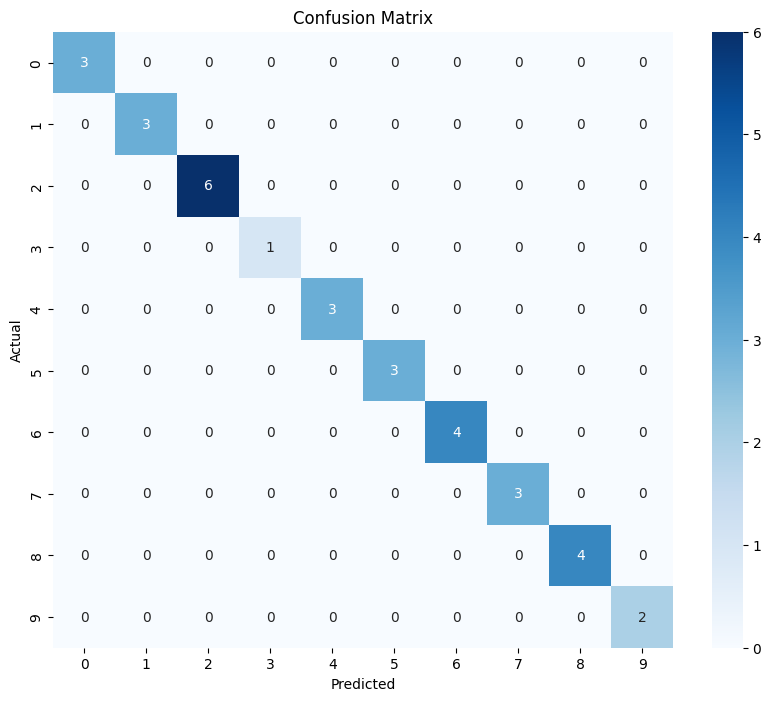

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      0.86      0.92         7

    accuracy                           0.97        32
   macro avg       0.90      0.89      0.89        32
weighted avg       1.00      0.97      0.98        32



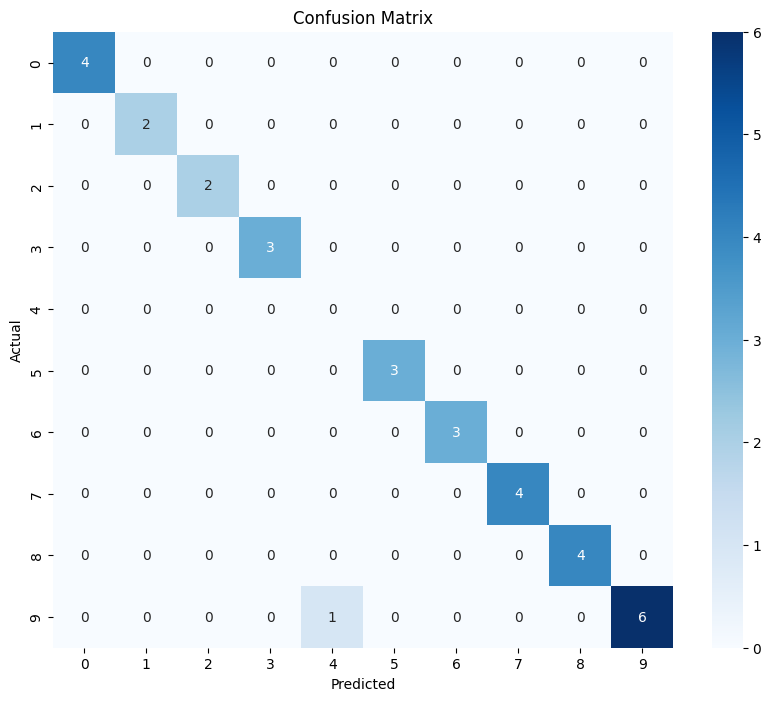

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



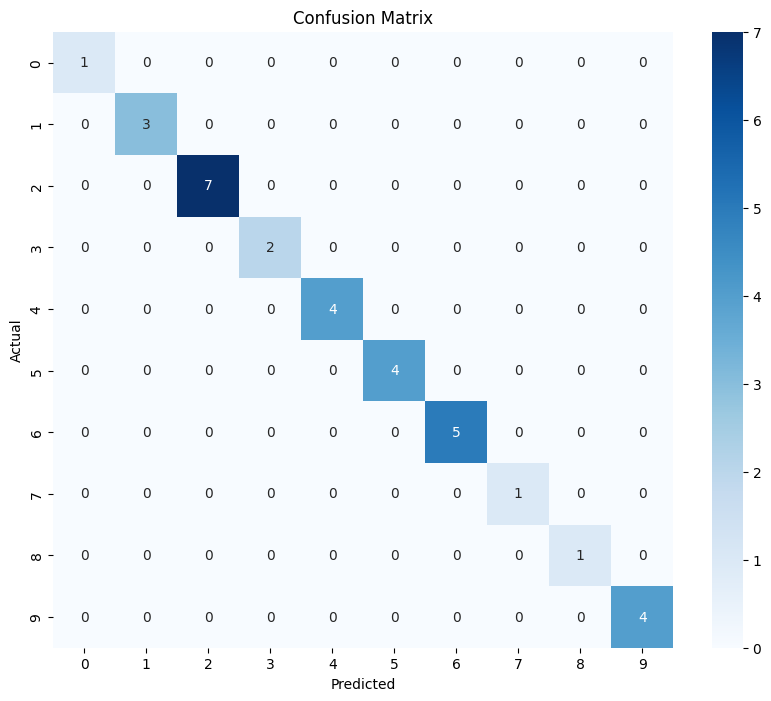

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       0.86      1.00      0.92         6
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1

    accuracy                           0.97        32
   macro avg       0.87      0.89      0.88        32
weighted avg       0.94      0.97      0.95        32



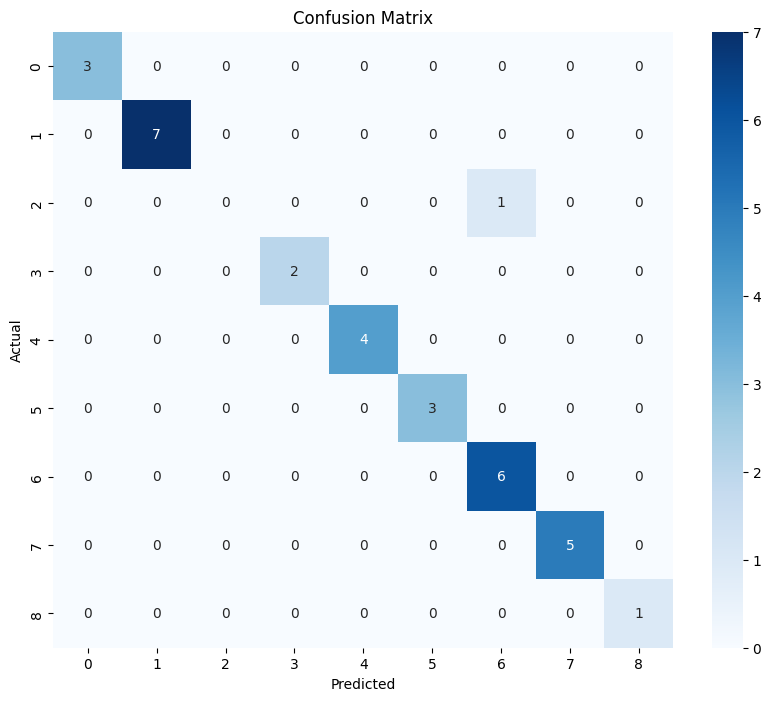

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      0.67      0.80         3
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       0.75      1.00      0.86         3
           9       0.50      0.50      0.50         2

    accuracy                           0.91        32
   macro avg       0.91      0.87      0.87        32
weighted avg       0.92      0.91      0.90        32



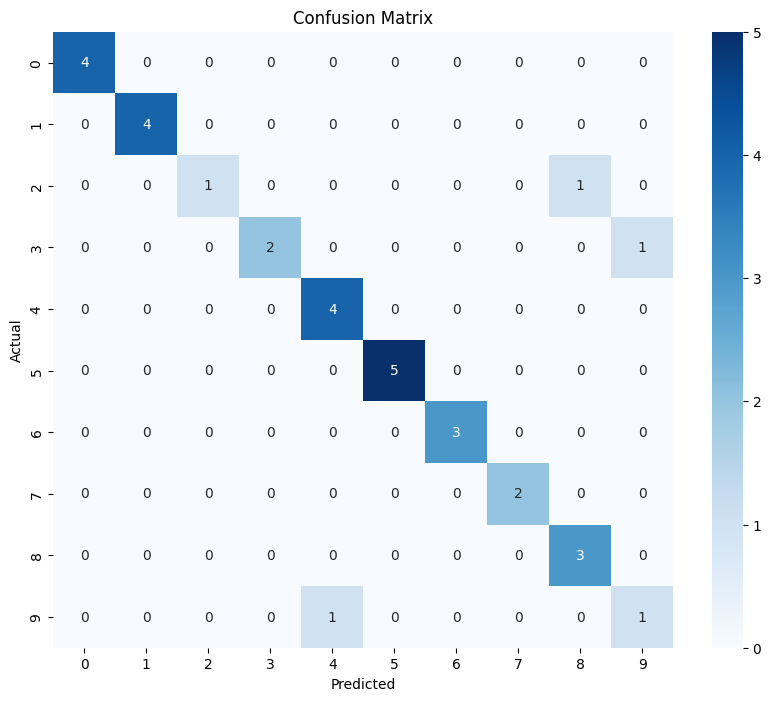

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



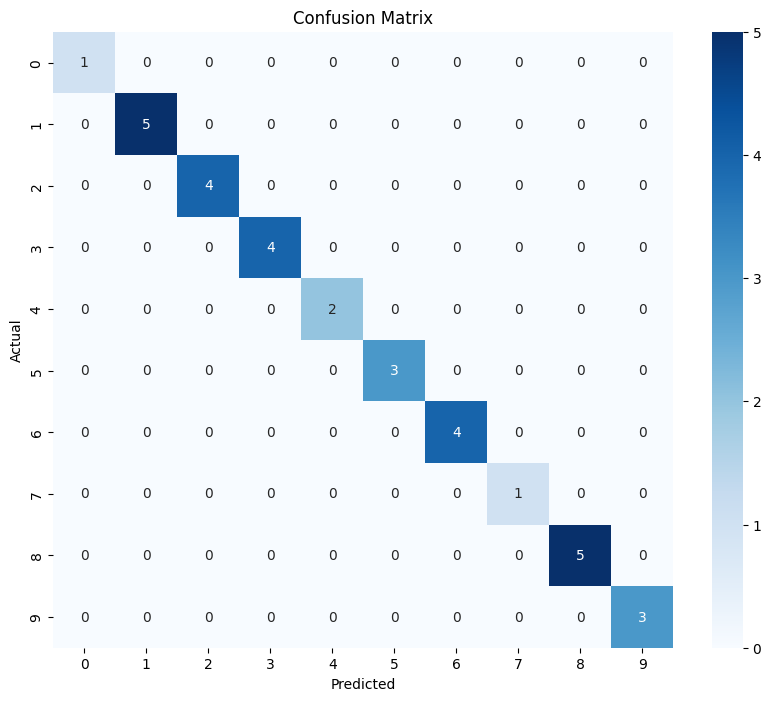

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      0.75      0.86         4
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           0.94        32
   macro avg       0.92      0.95      0.92        32
weighted avg       0.96      0.94      0.94        32



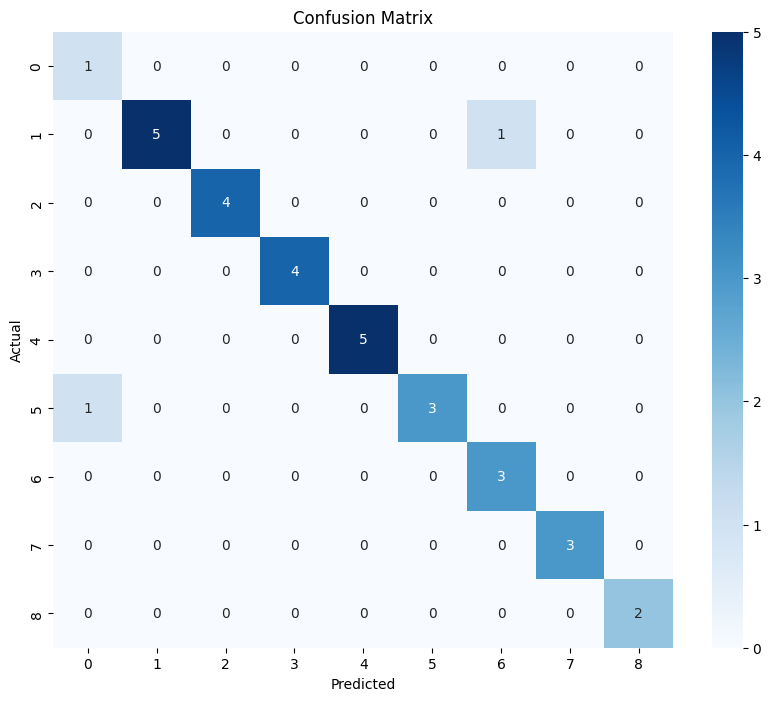

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



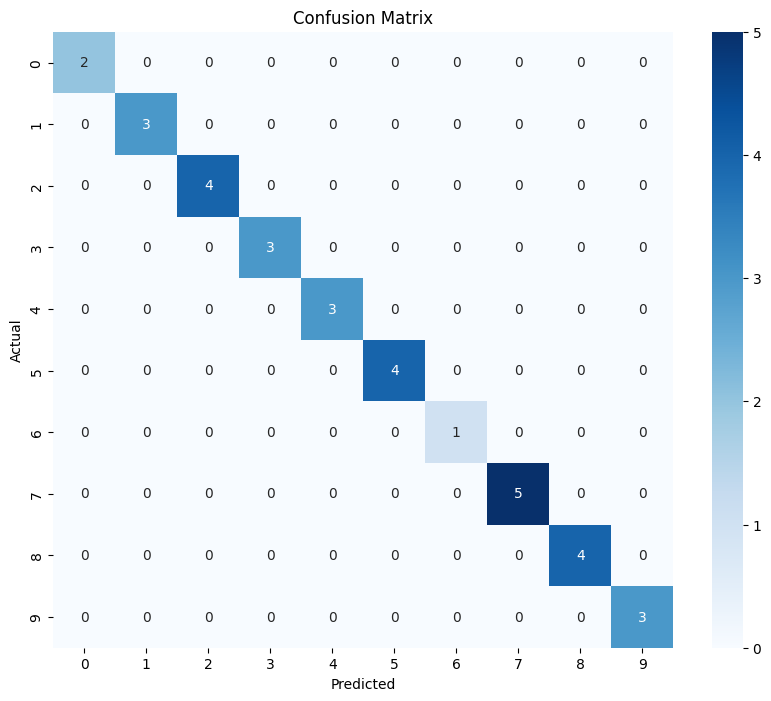

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



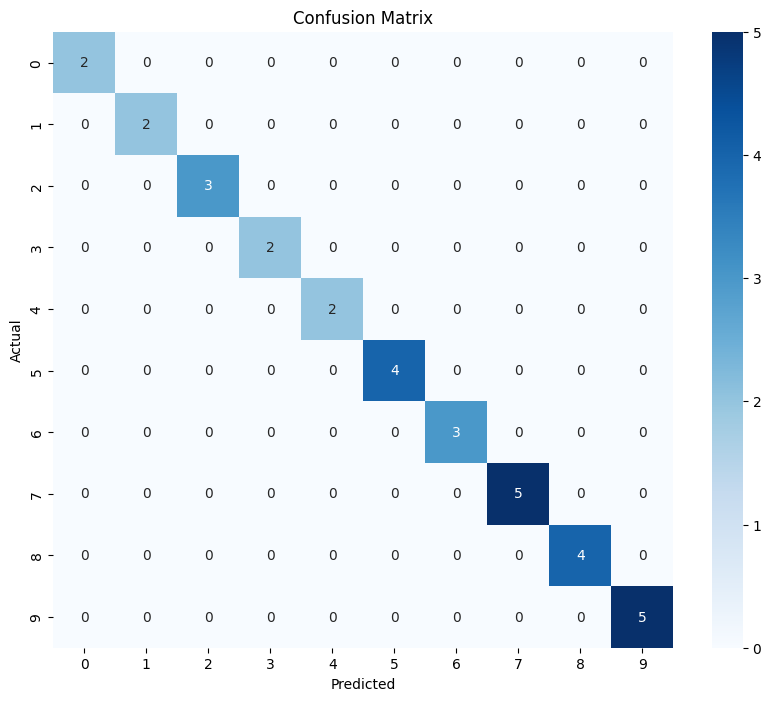

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



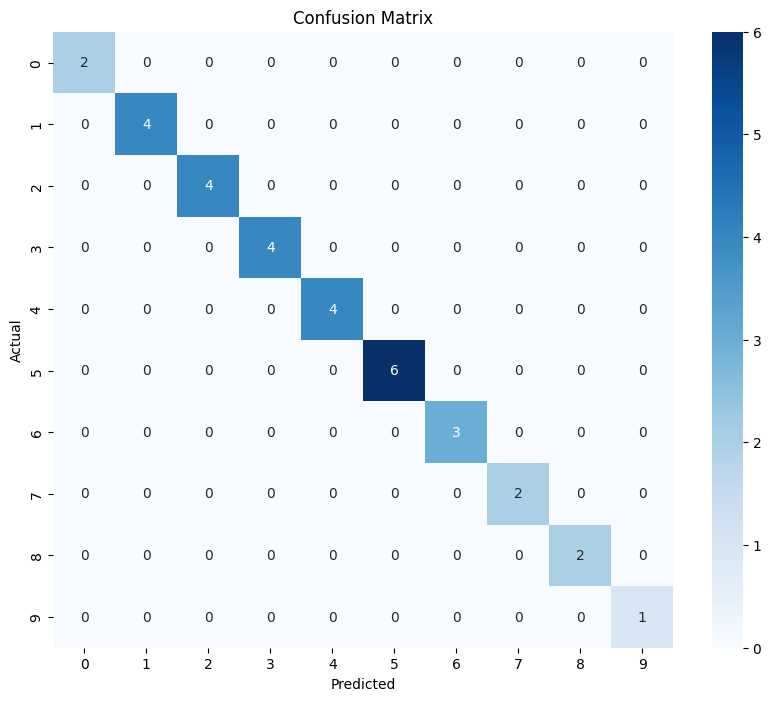

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



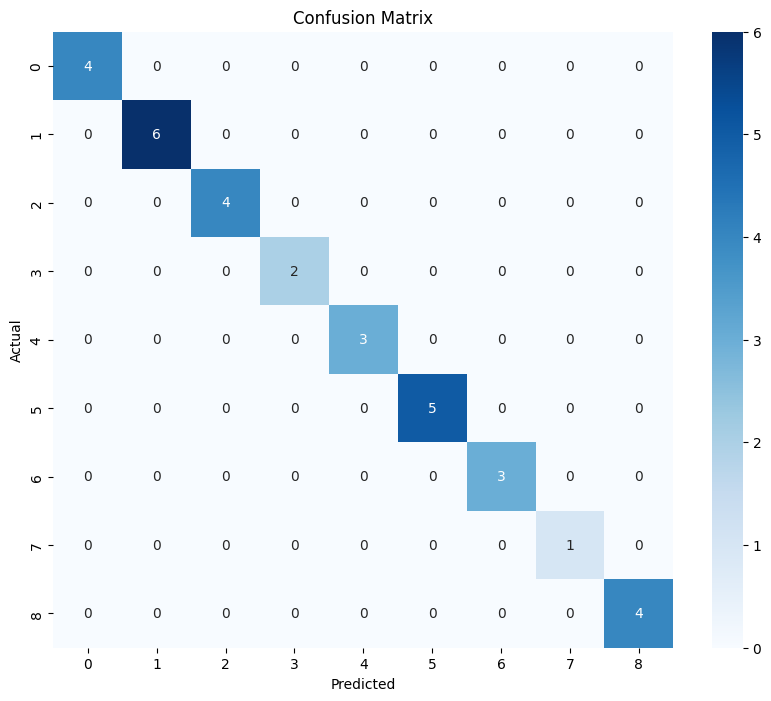

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      0.89      0.94         9
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         2

    accuracy                           0.94        32
   macro avg       0.92      0.97      0.93        32
weighted avg       0.96      0.94      0.94        32



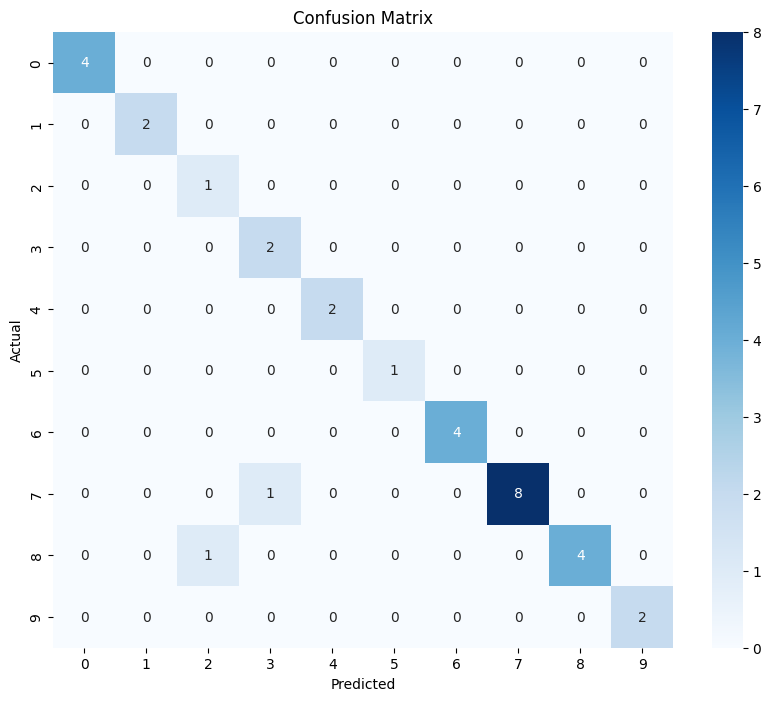

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



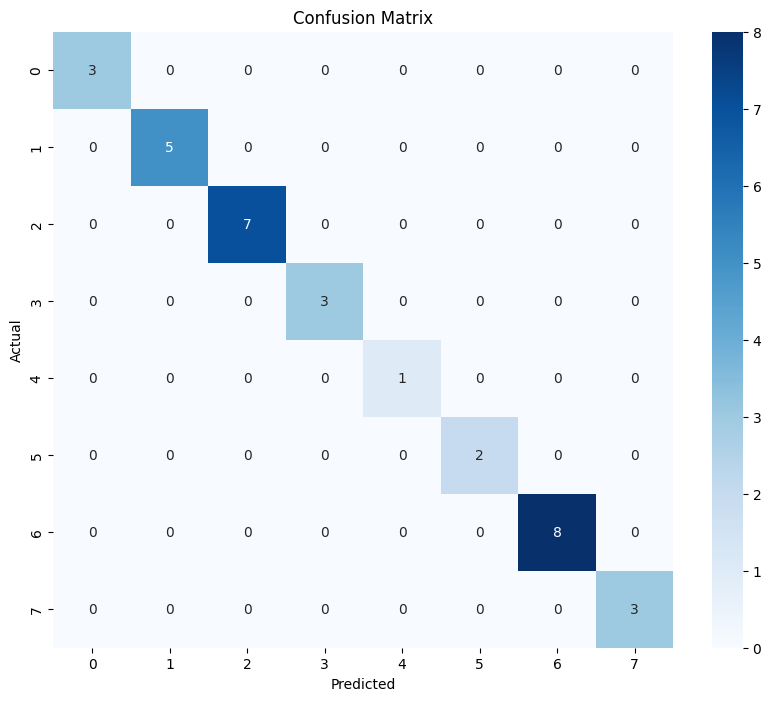

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      0.83      0.91         6
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.98        32
weighted avg       0.98      0.97      0.97        32



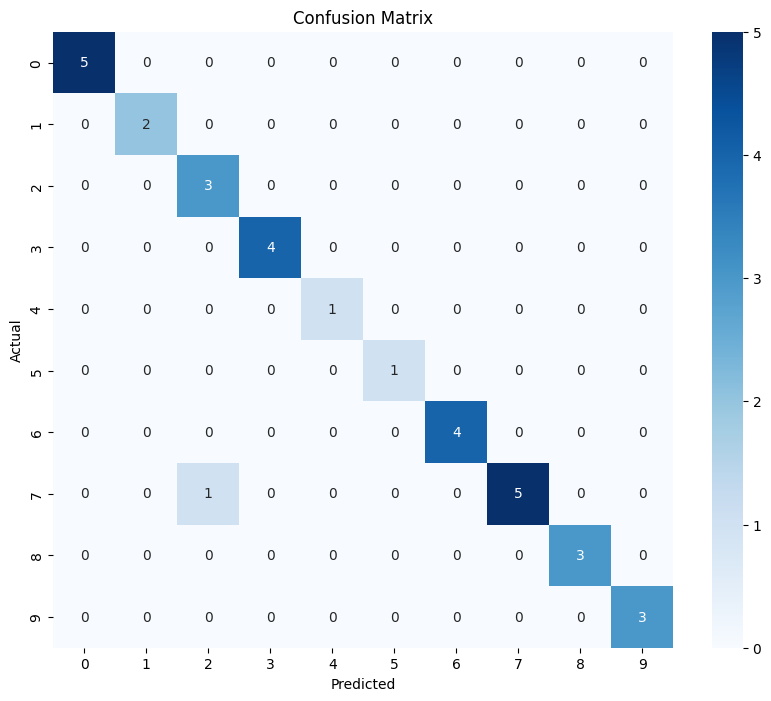

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



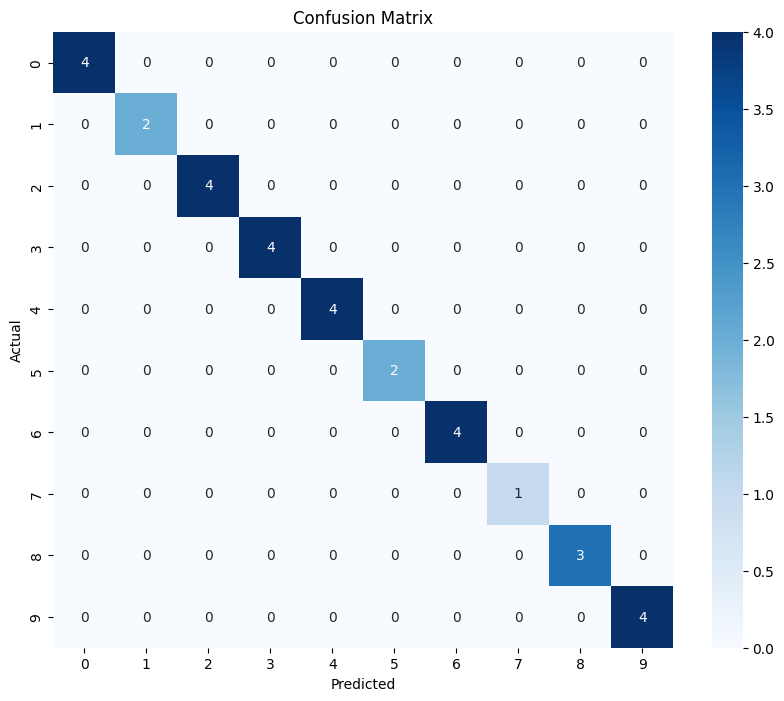

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         6
           9       1.00      0.67      0.80         3

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.96        32
weighted avg       0.98      0.97      0.97        32



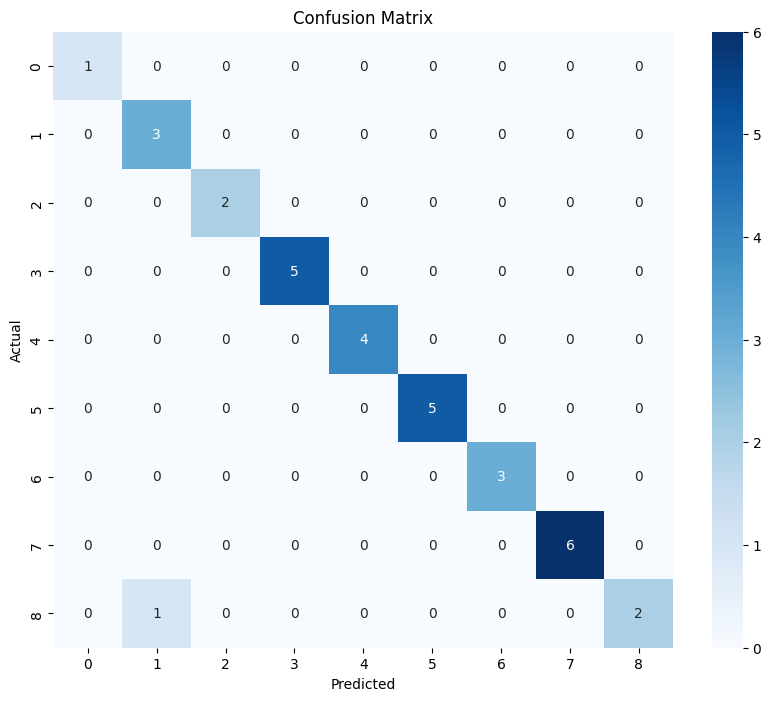

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



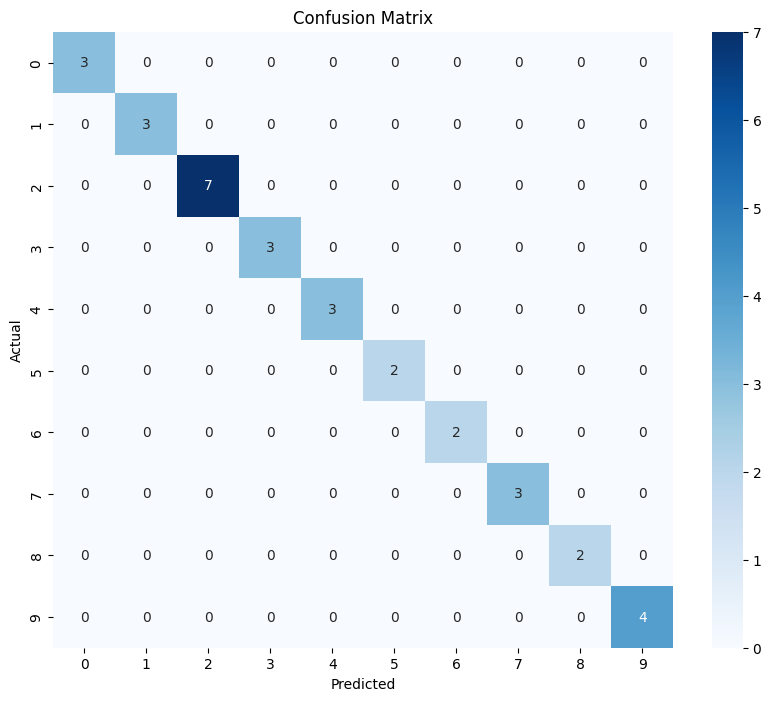

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.97      0.99      0.97        32
weighted avg       0.98      0.97      0.97        32



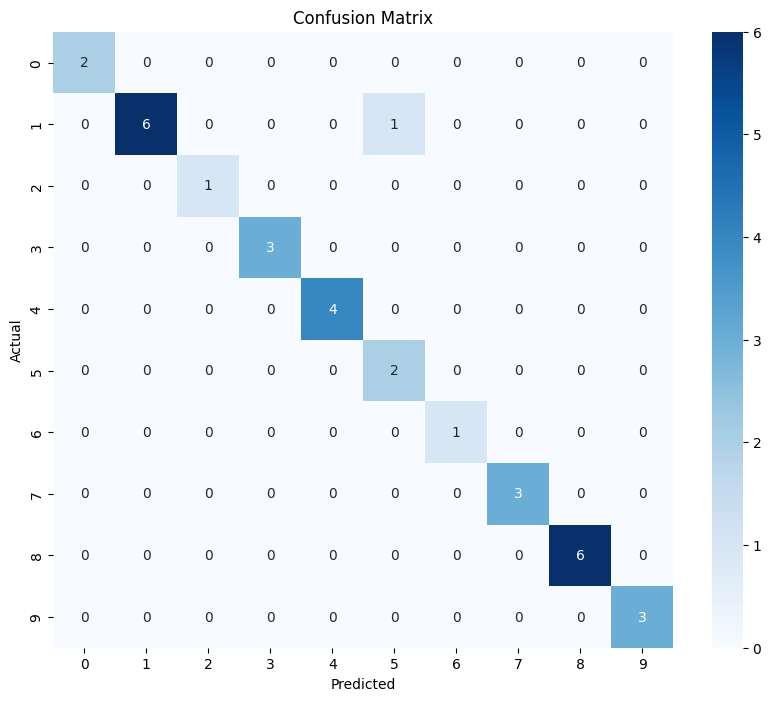

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



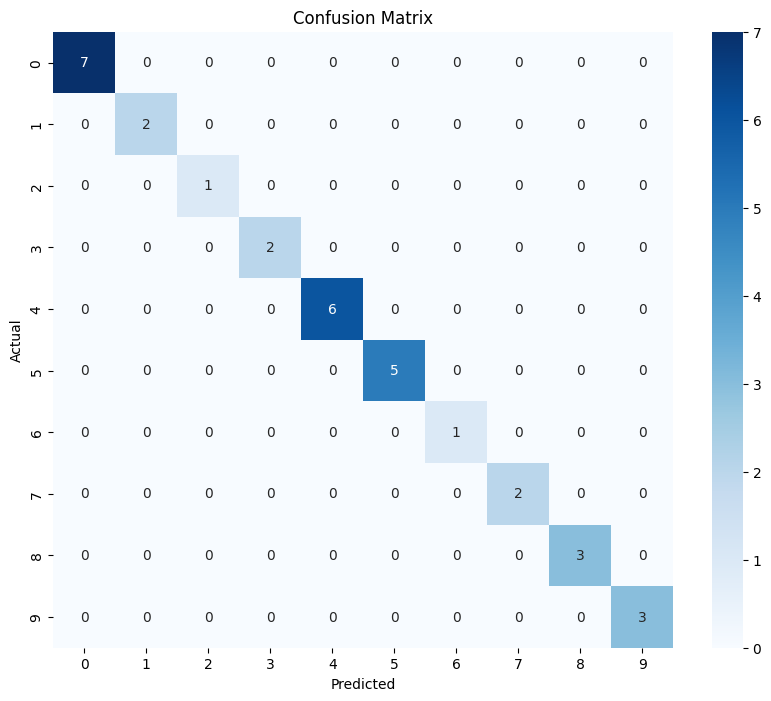

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         2
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.98      0.97      0.97        32



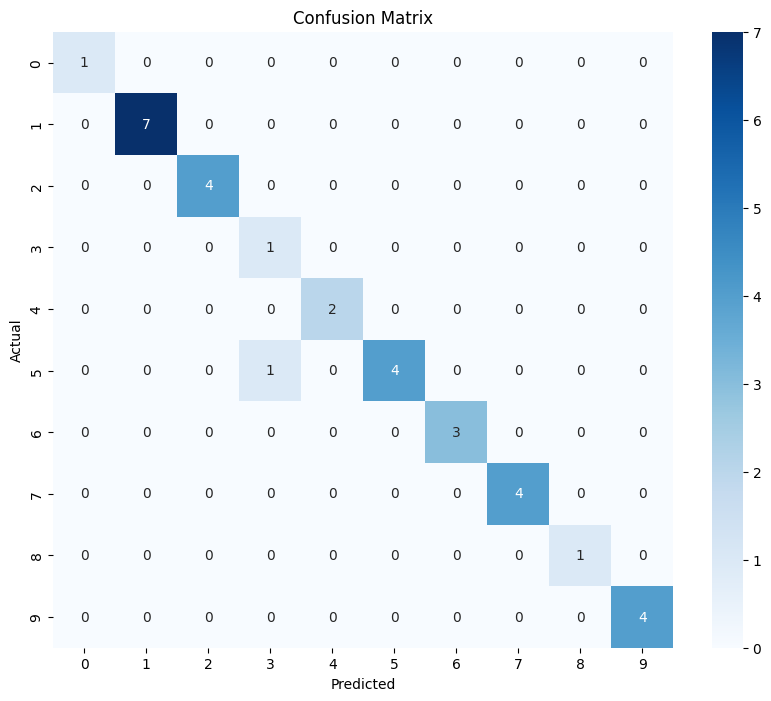

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



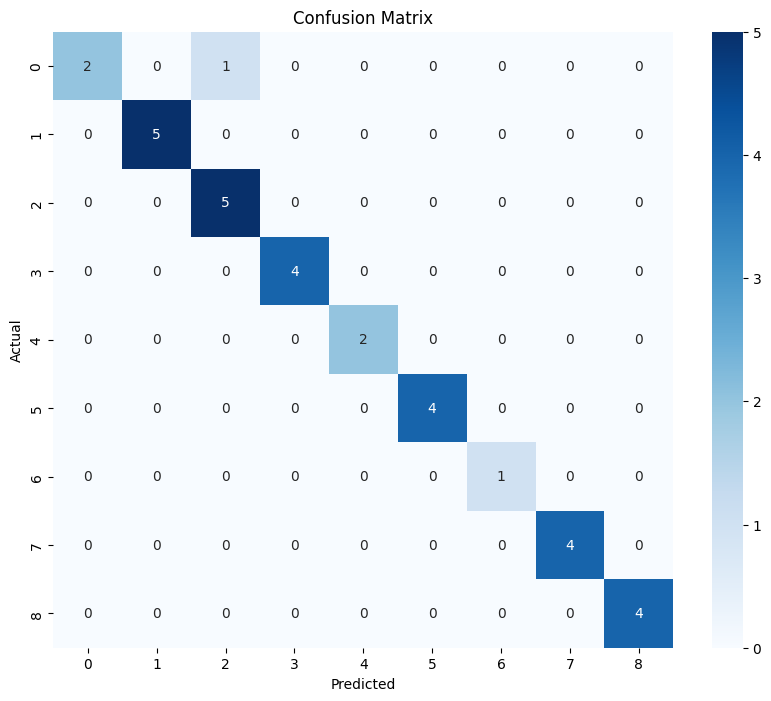

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



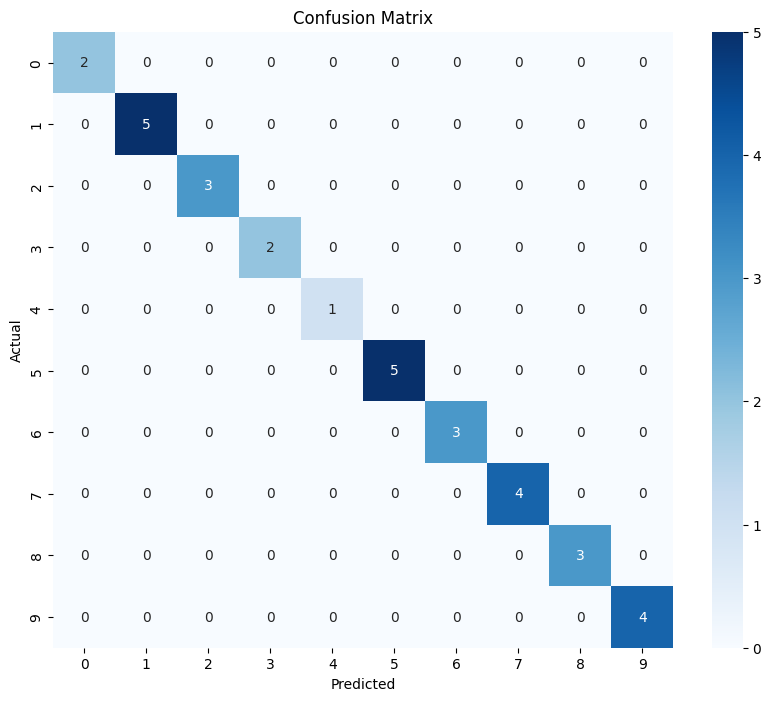

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         7
           9       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.98      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



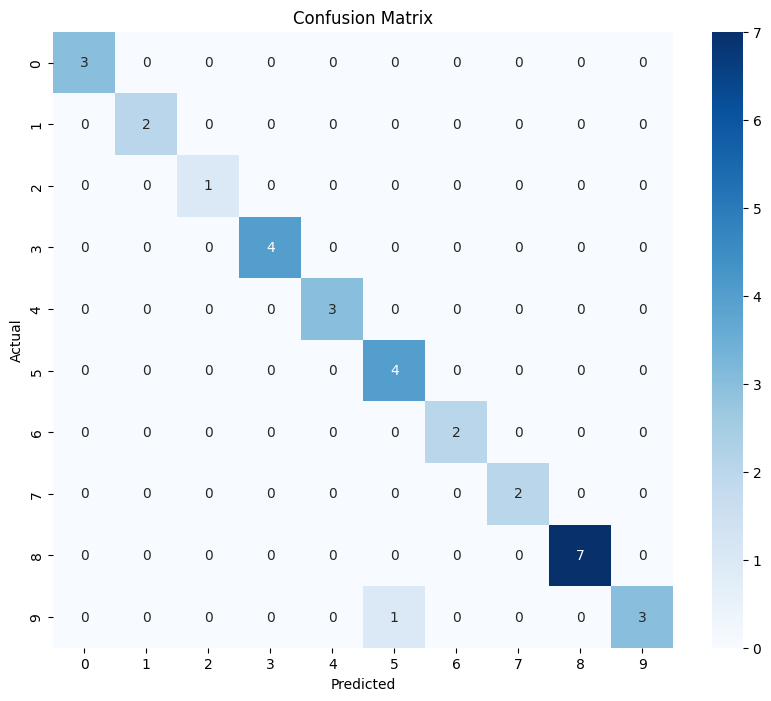

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



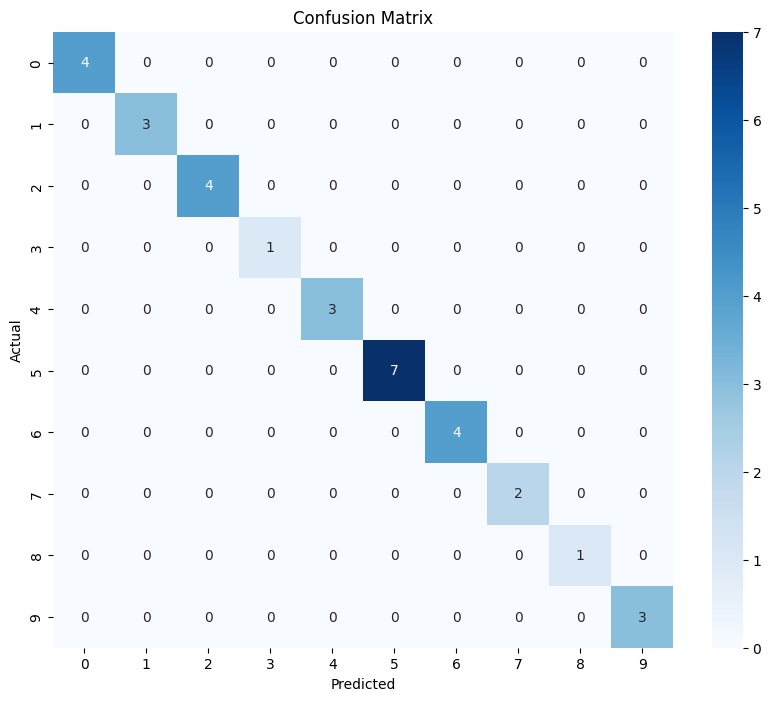

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



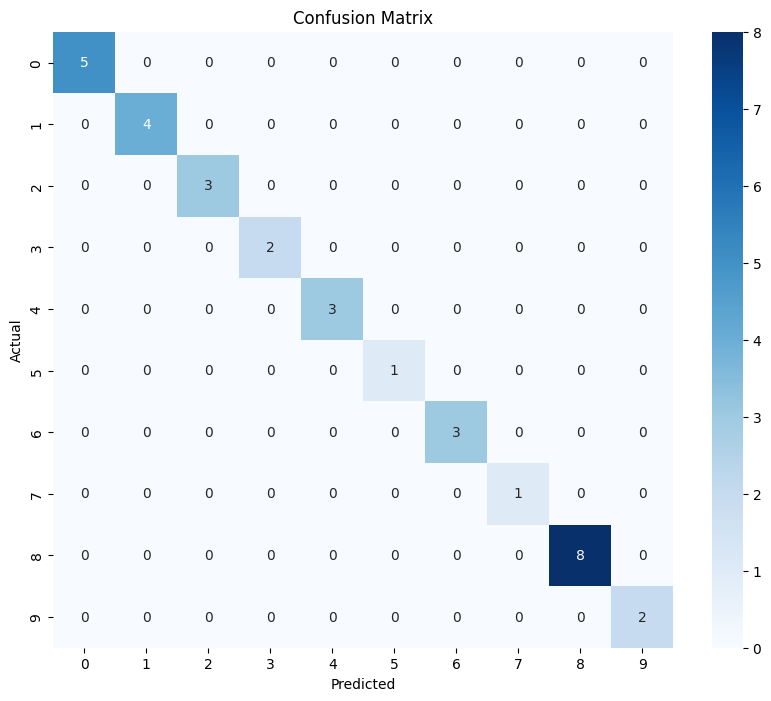

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.95      0.97      0.95        32
weighted avg       0.98      0.97      0.97        32



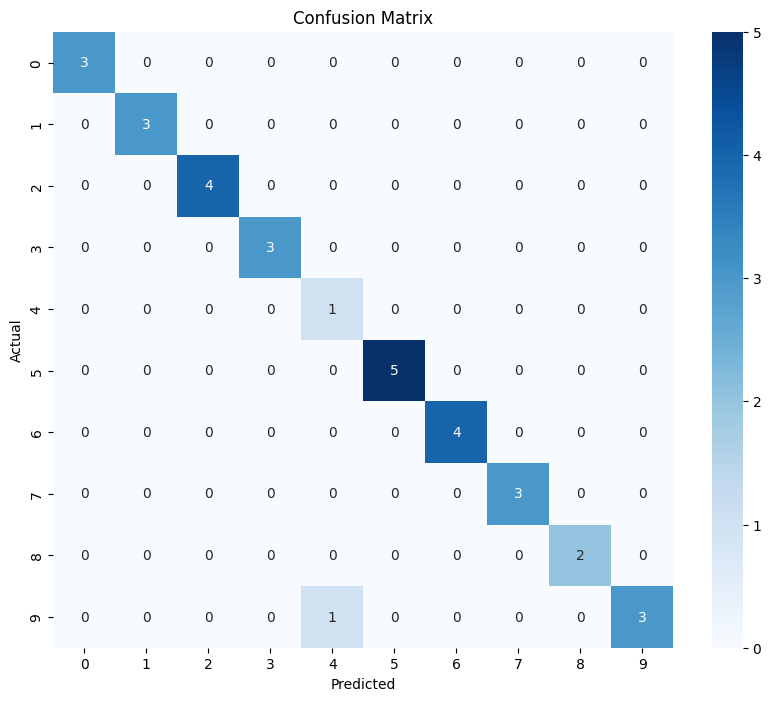

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



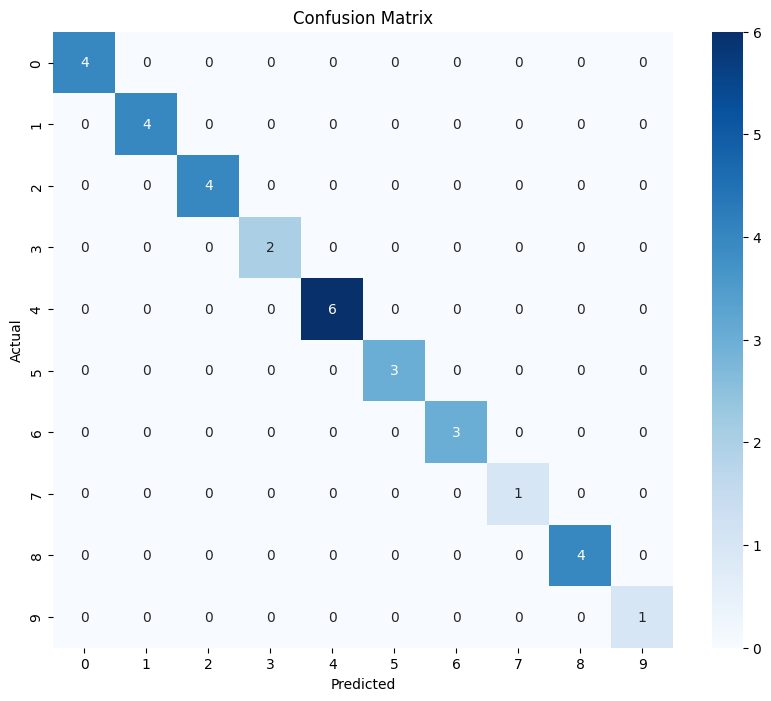

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



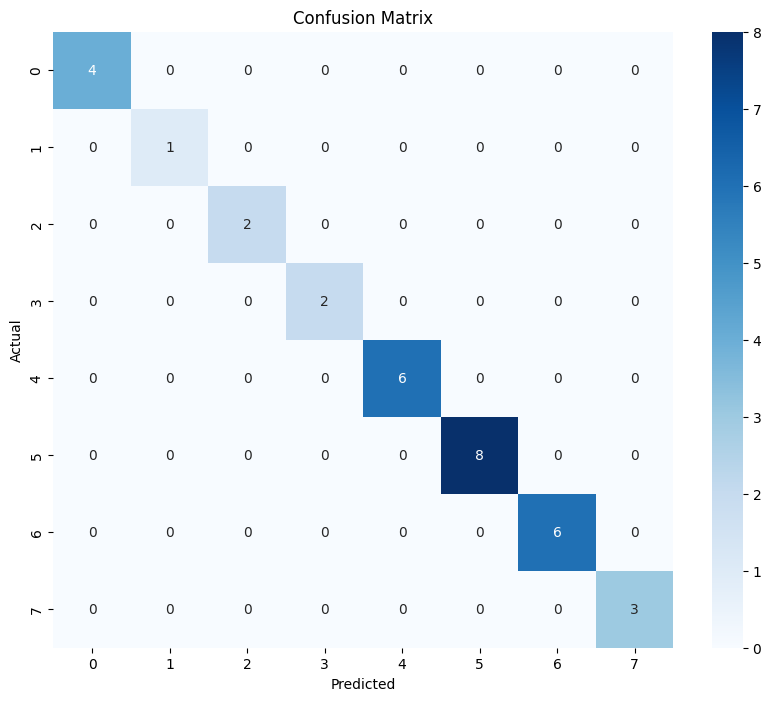

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



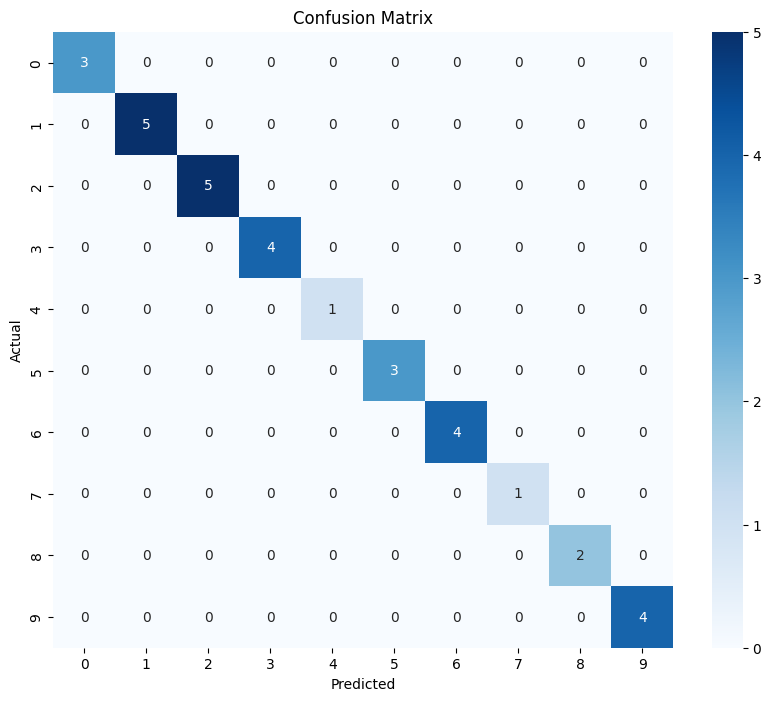

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



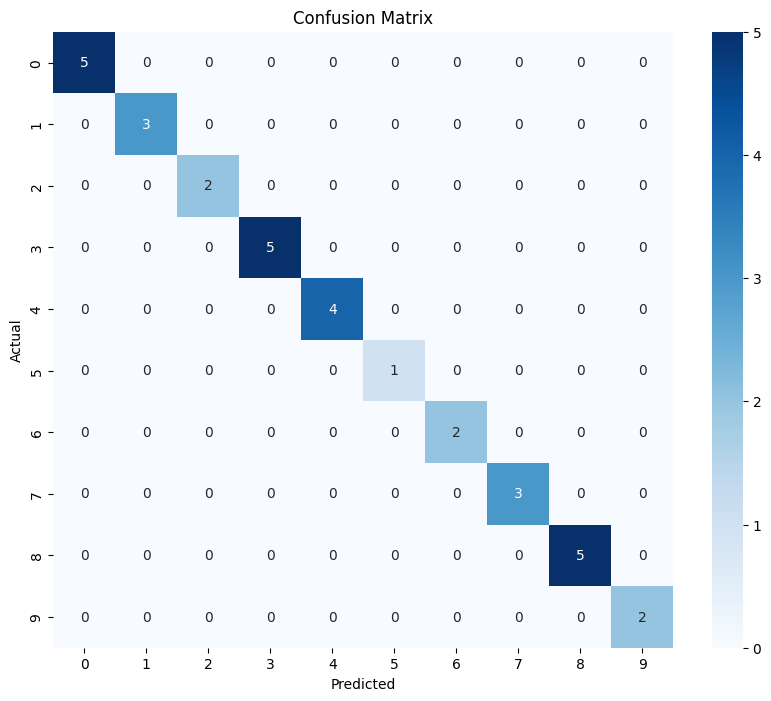

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



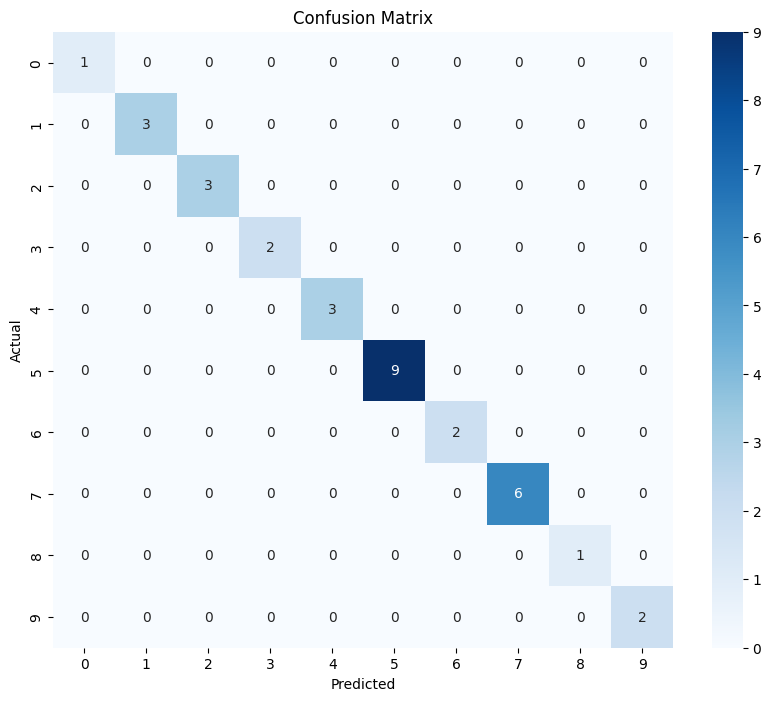

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      0.83      0.91         6
           5       1.00      1.00      1.00         4
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         2
           8       1.00      0.67      0.80         3
           9       0.67      1.00      0.80         2

    accuracy                           0.94        32
   macro avg       0.95      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32



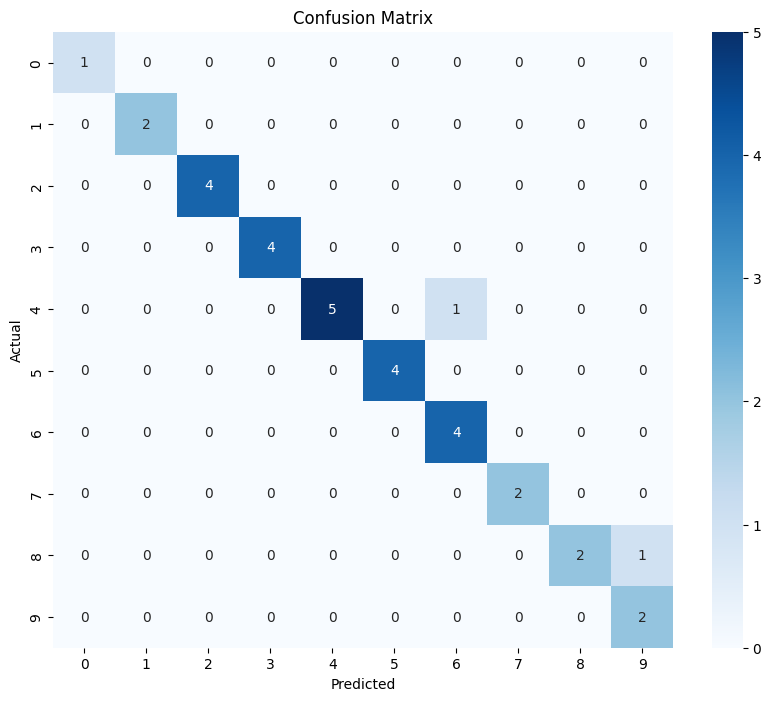

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       0.67      1.00      0.80         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         7
           5       1.00      0.75      0.86         4
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.94        32
   macro avg       0.87      0.82      0.83        32
weighted avg       0.98      0.94      0.95        32



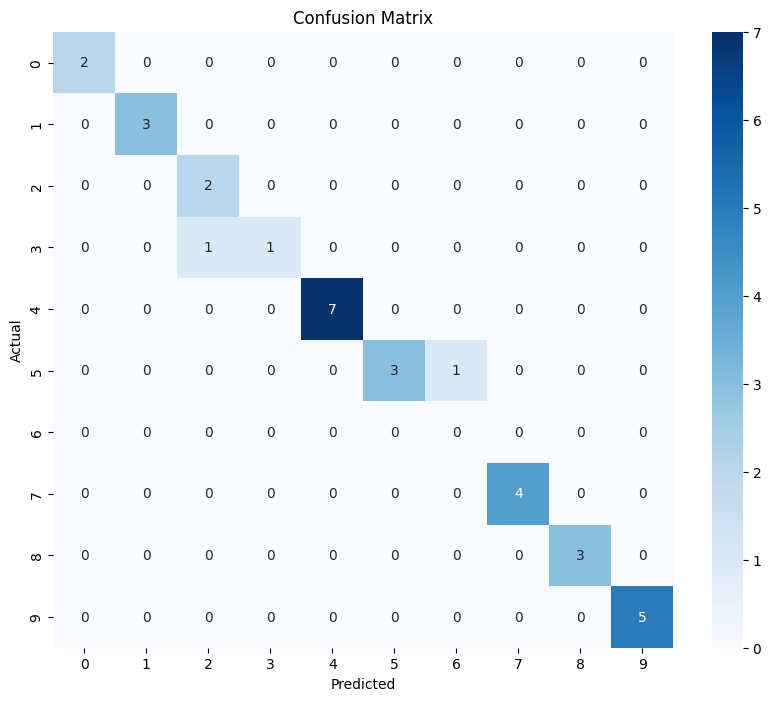

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



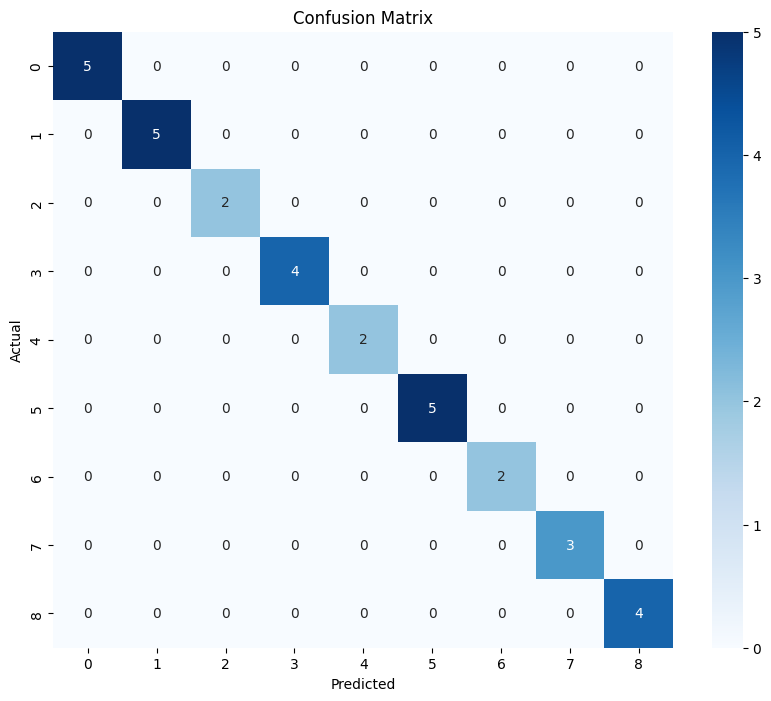

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      0.83      0.91         6
           9       0.80      1.00      0.89         4

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



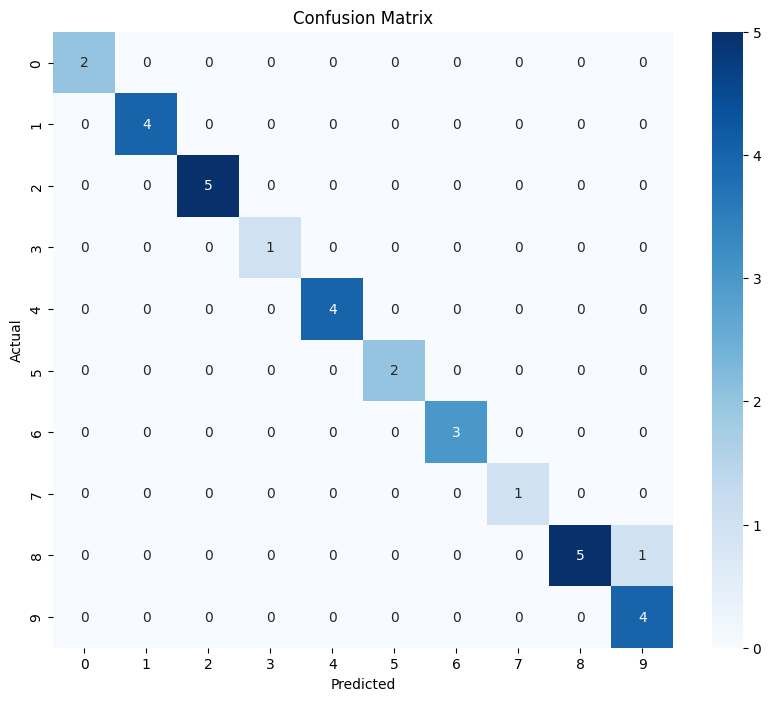

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



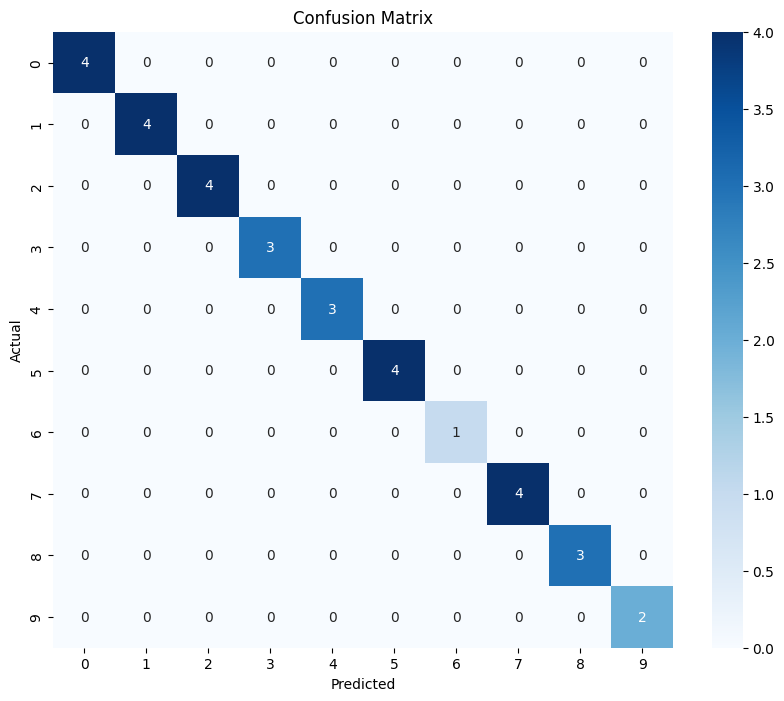

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



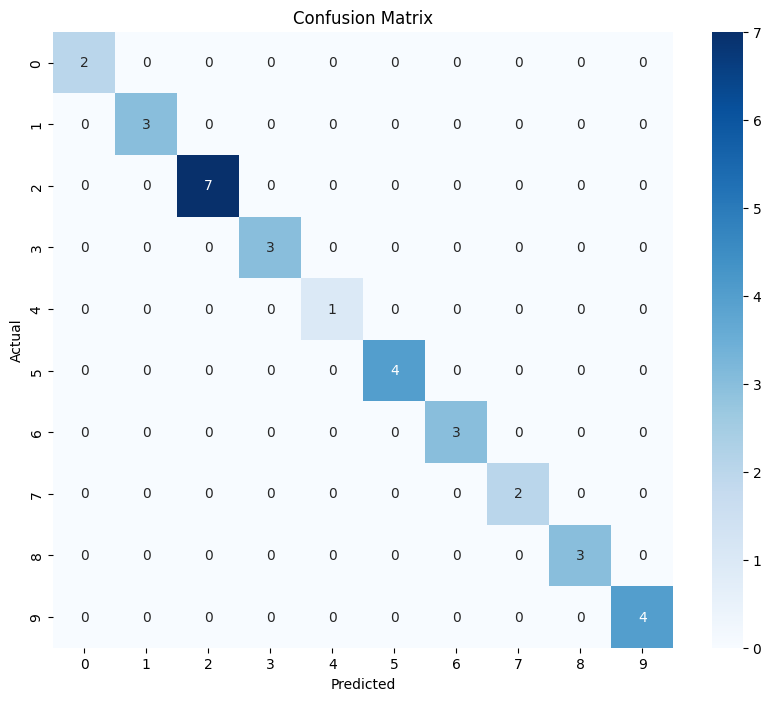

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



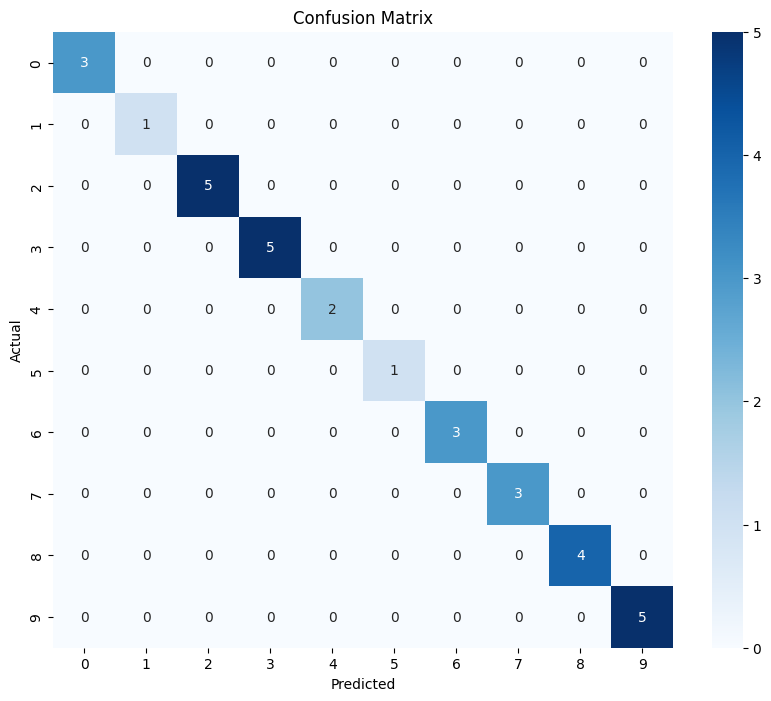

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      0.75      0.86         4
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3

    accuracy                           0.94        32
   macro avg       0.88      0.84      0.85        32
weighted avg       0.98      0.94      0.95        32



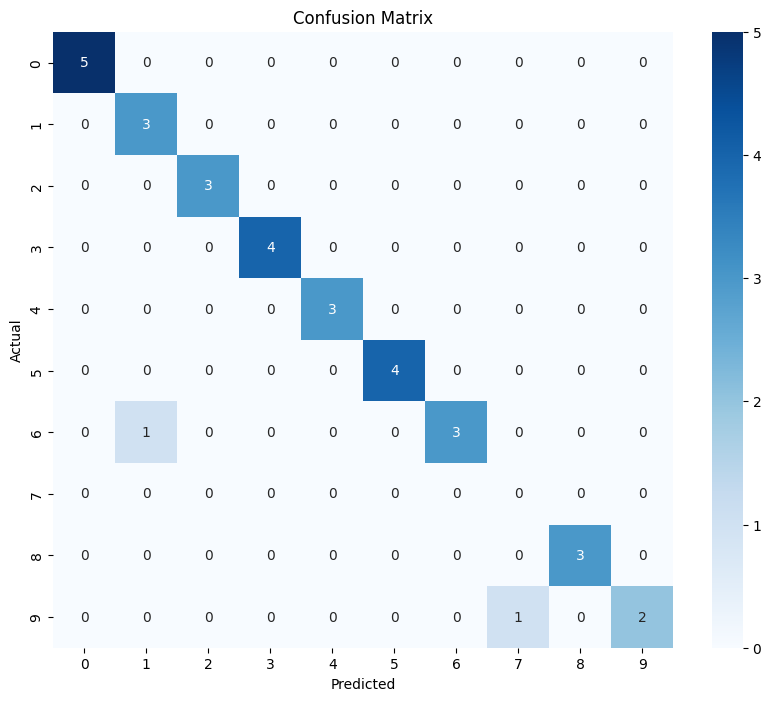

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



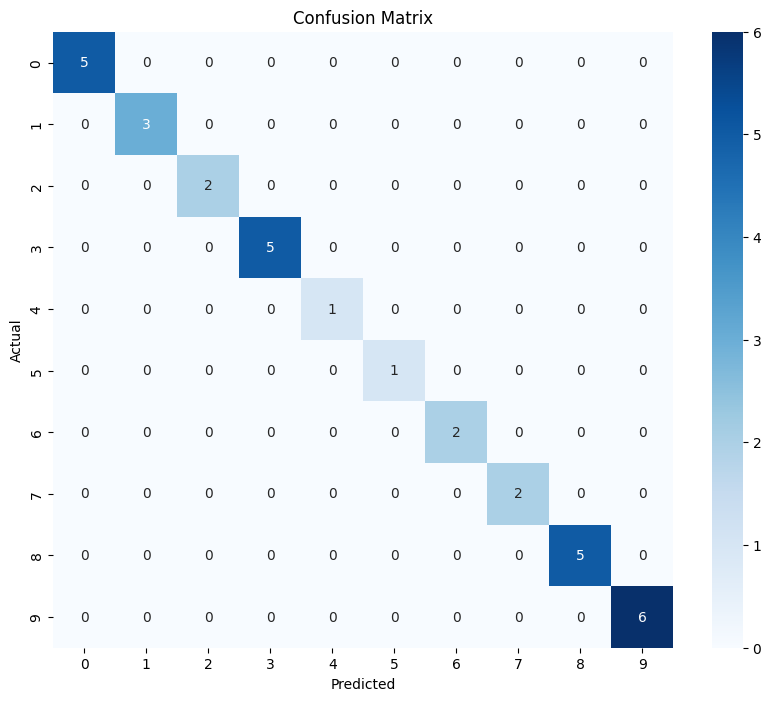

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



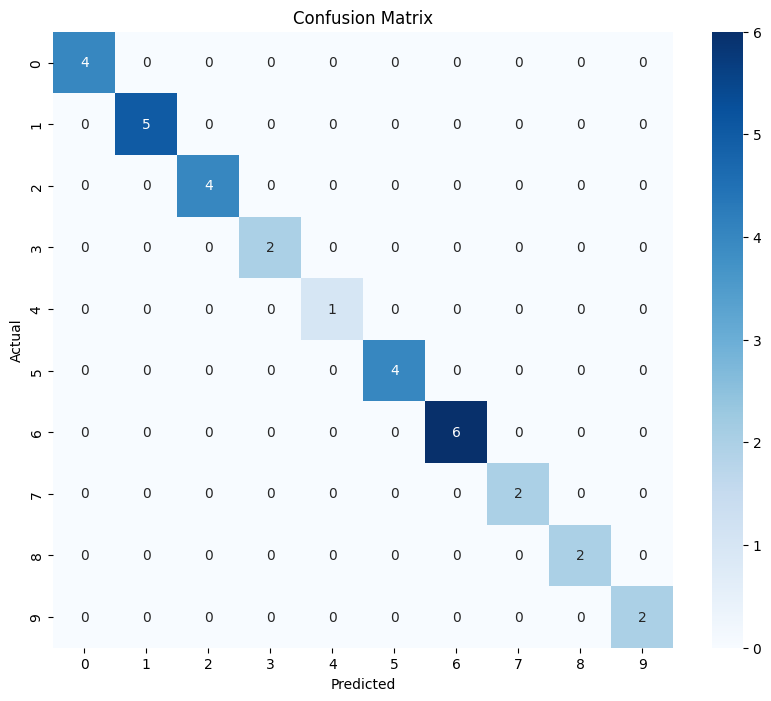

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



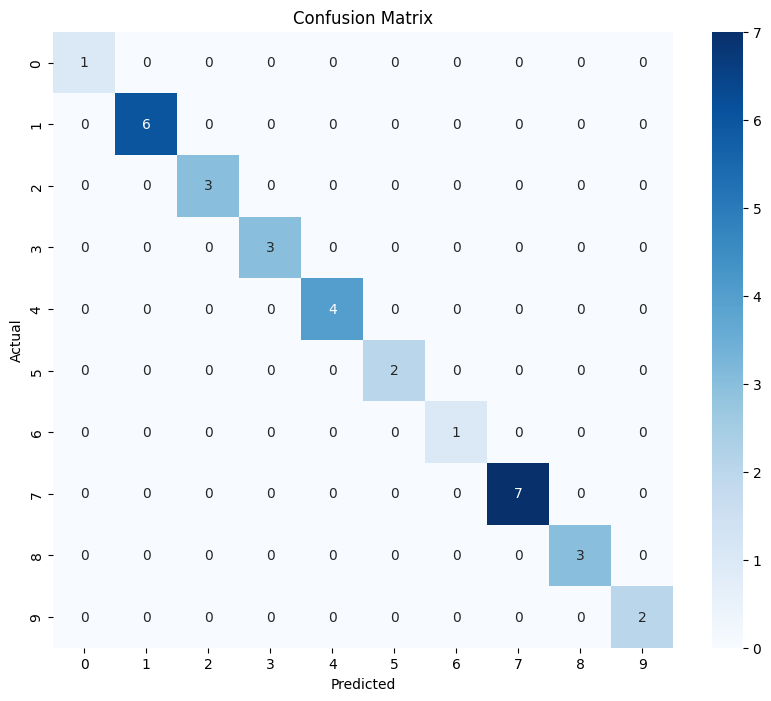

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



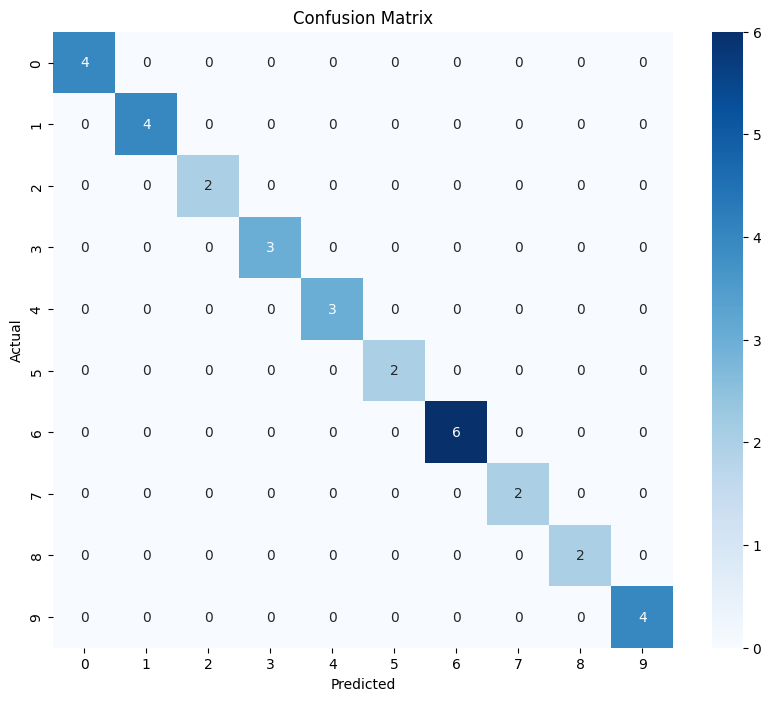

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



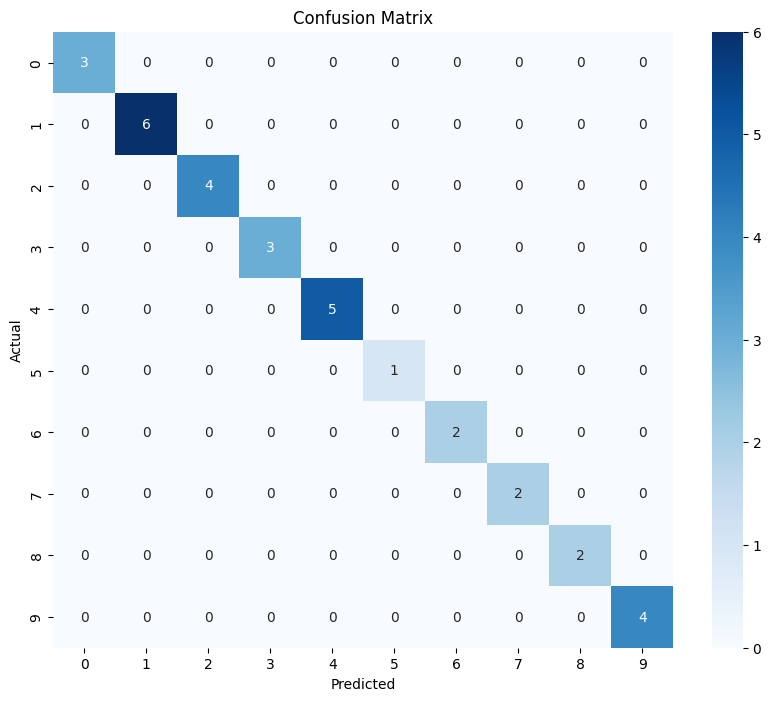

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



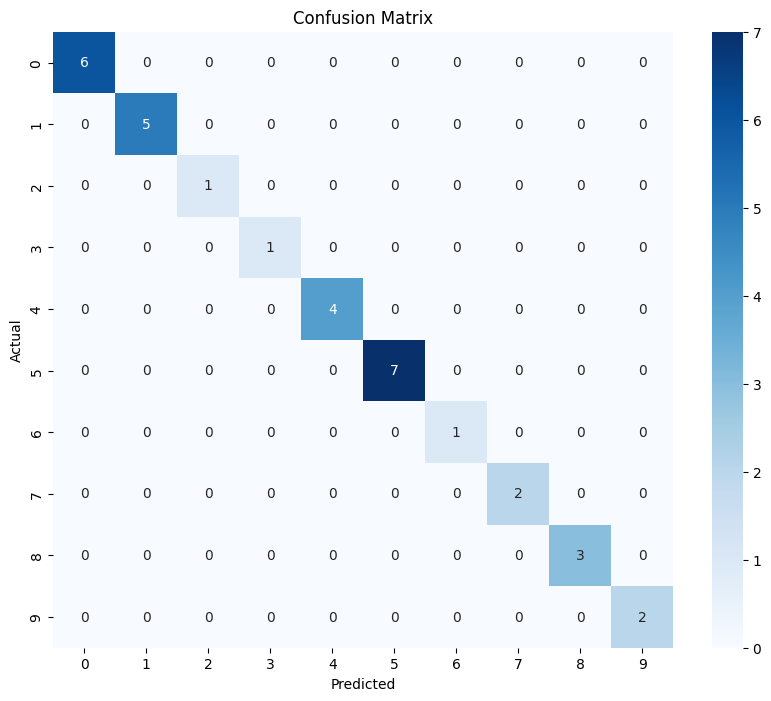

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



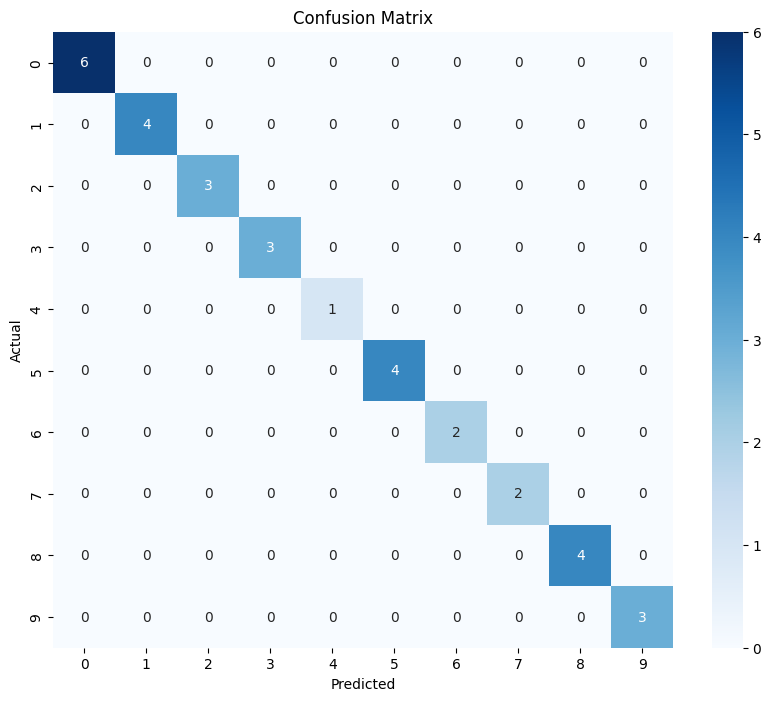

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         3
           8       0.50      0.50      0.50         2
           9       1.00      0.83      0.91         6

    accuracy                           0.94        32
   macro avg       0.93      0.93      0.92        32
weighted avg       0.94      0.94      0.94        32



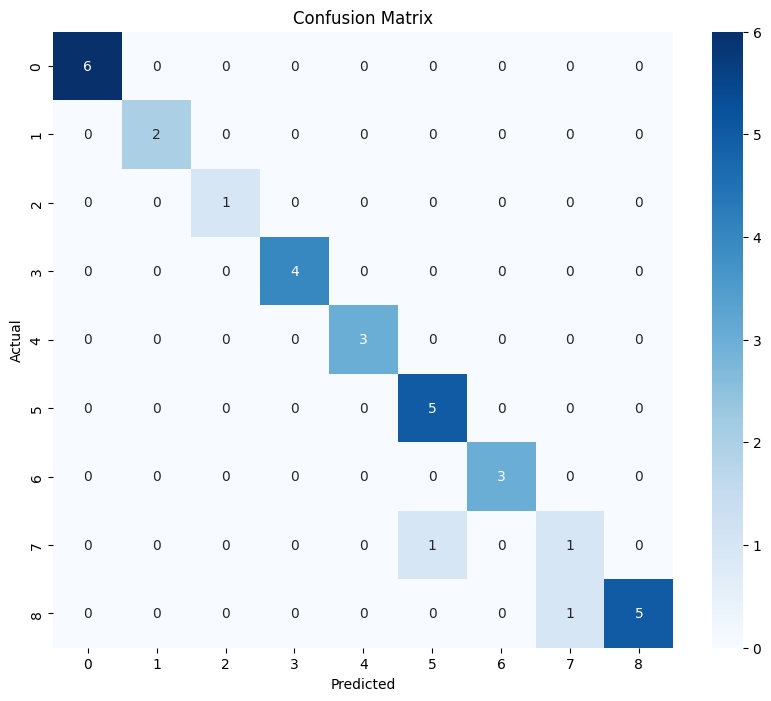

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         4
           8       1.00      0.80      0.89         5
           9       0.67      1.00      0.80         2

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



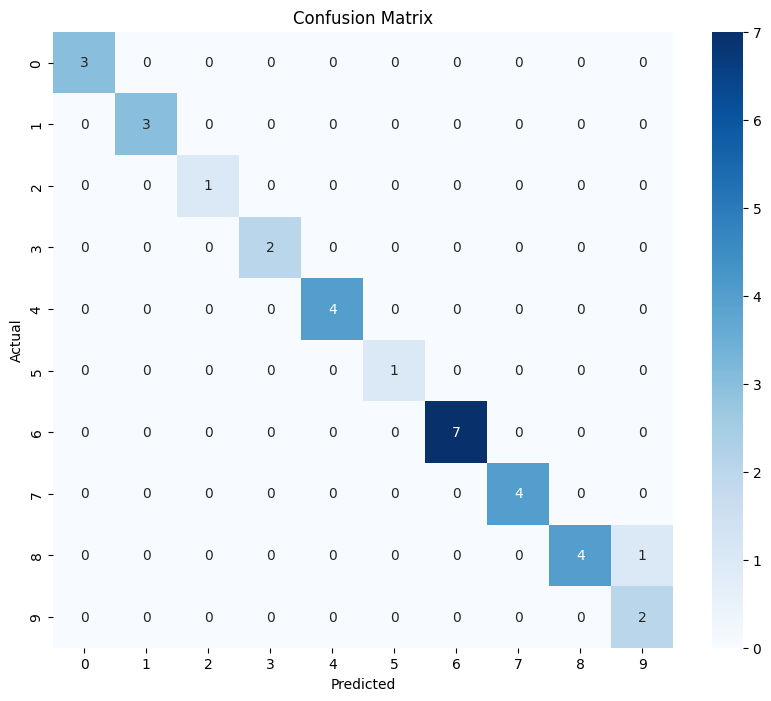

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



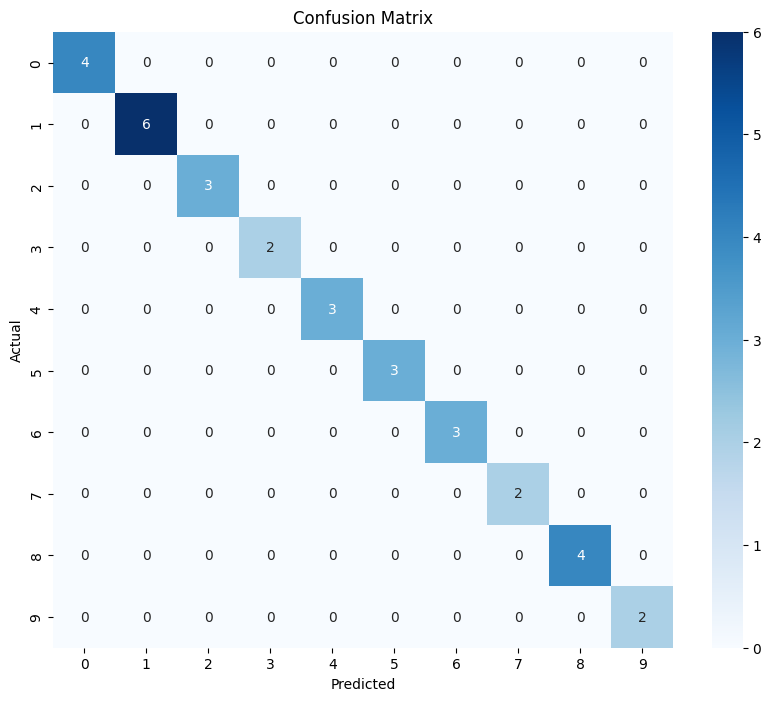

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



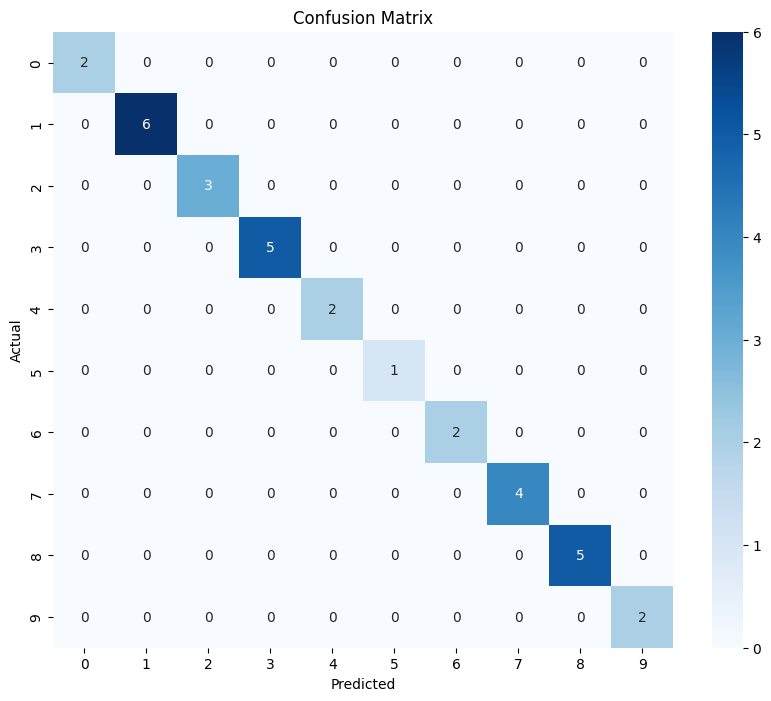

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



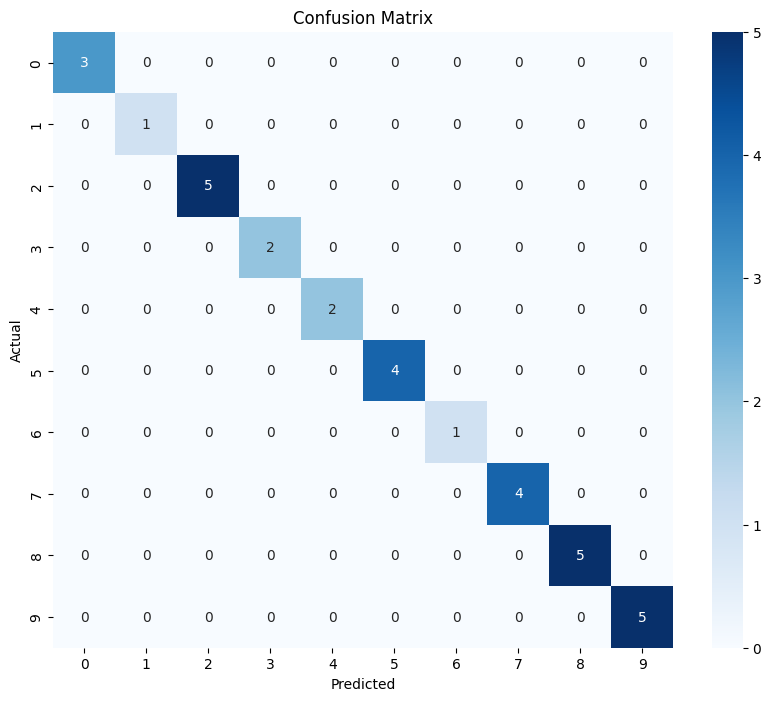

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



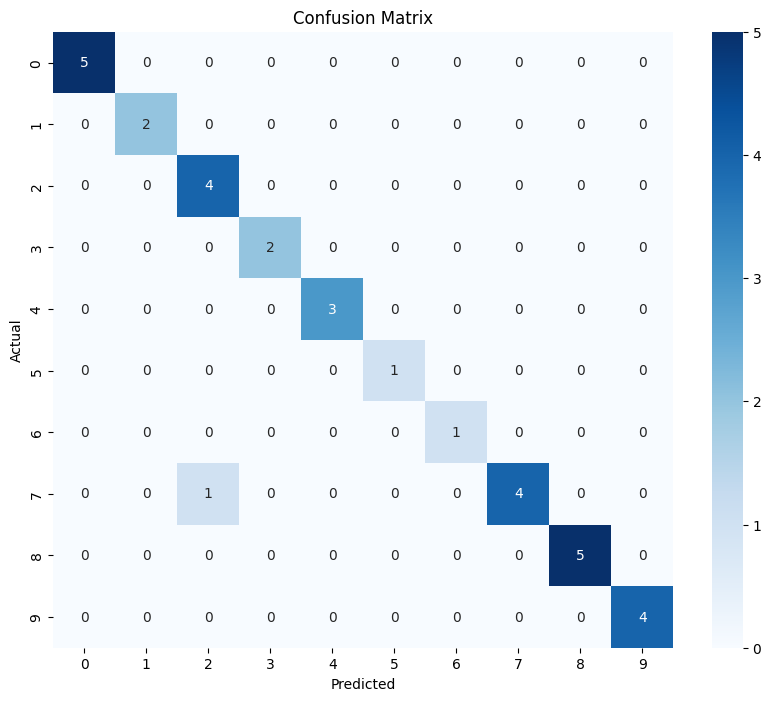

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      0.80      0.89         5

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



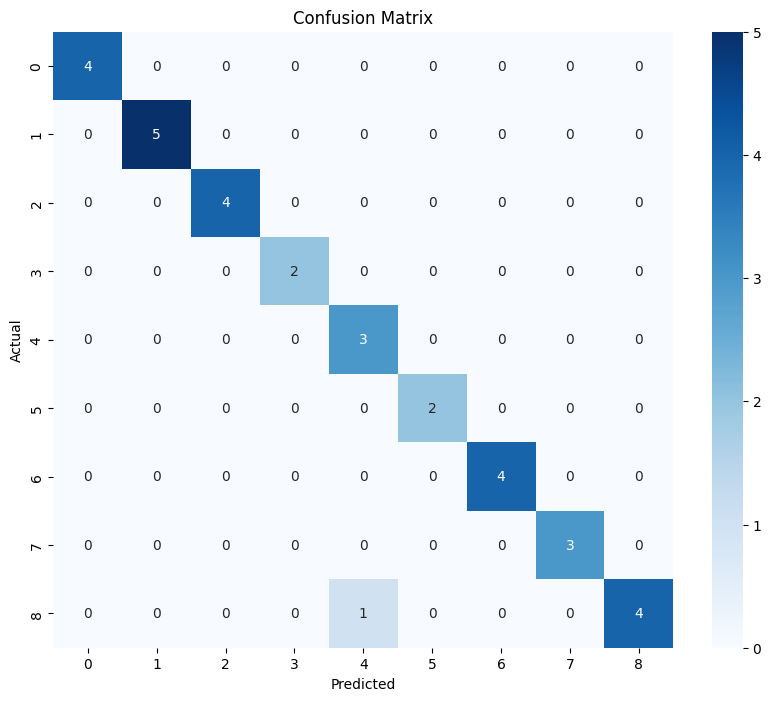

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         5
           9       0.75      1.00      0.86         3

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.98        32
weighted avg       0.98      0.97      0.97        32



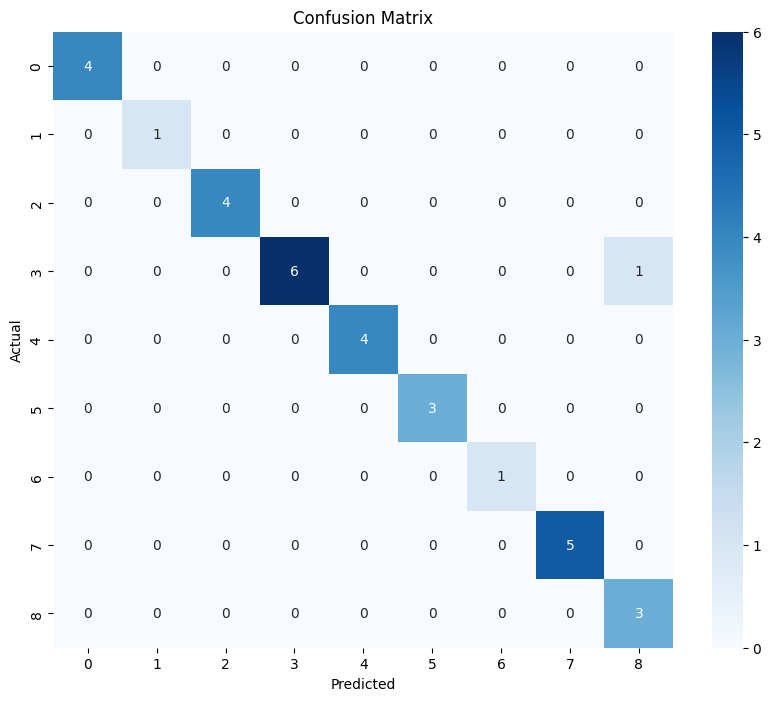

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



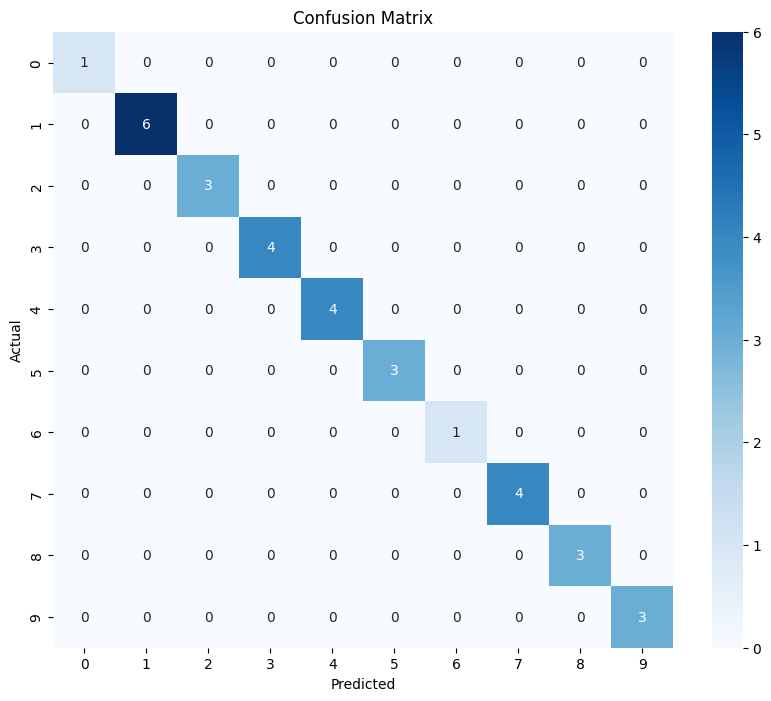

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



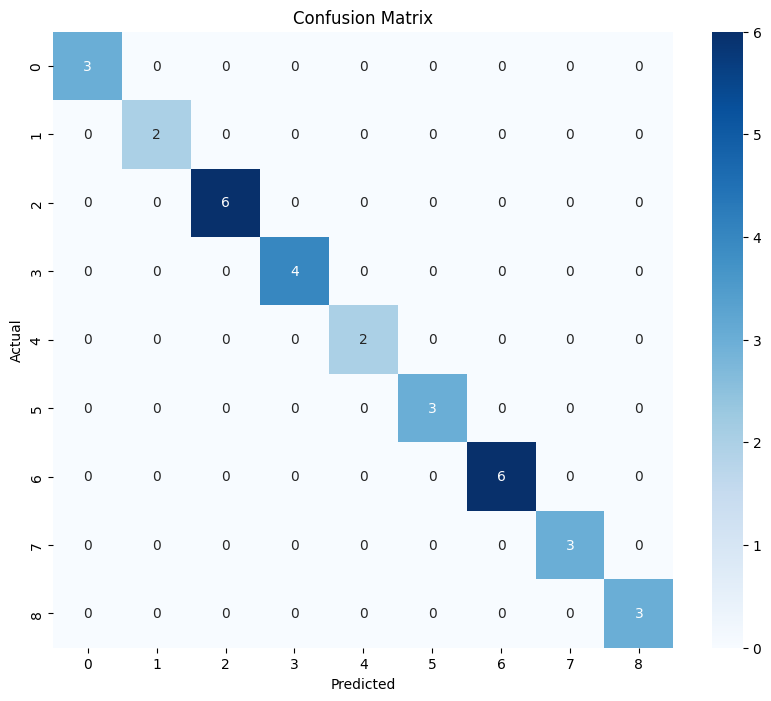

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



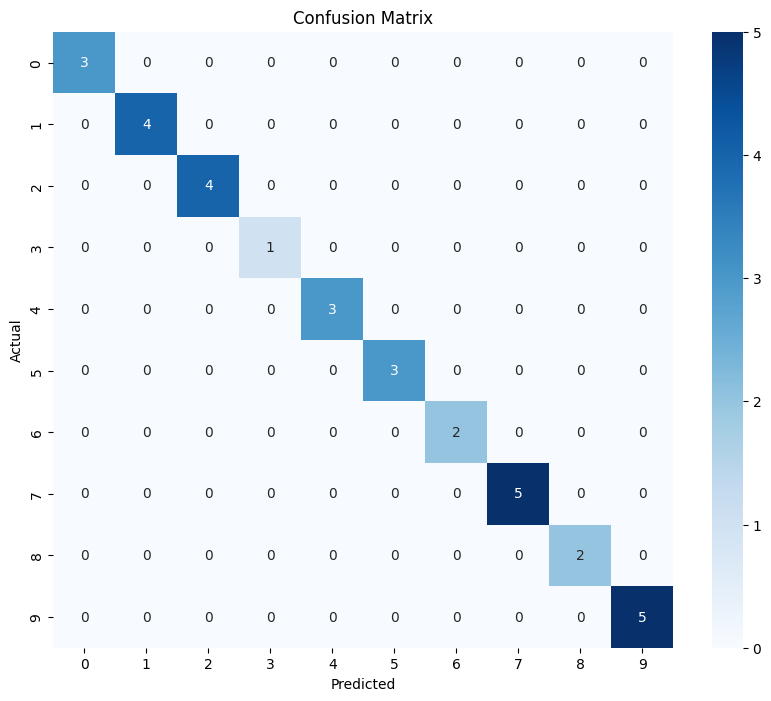

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



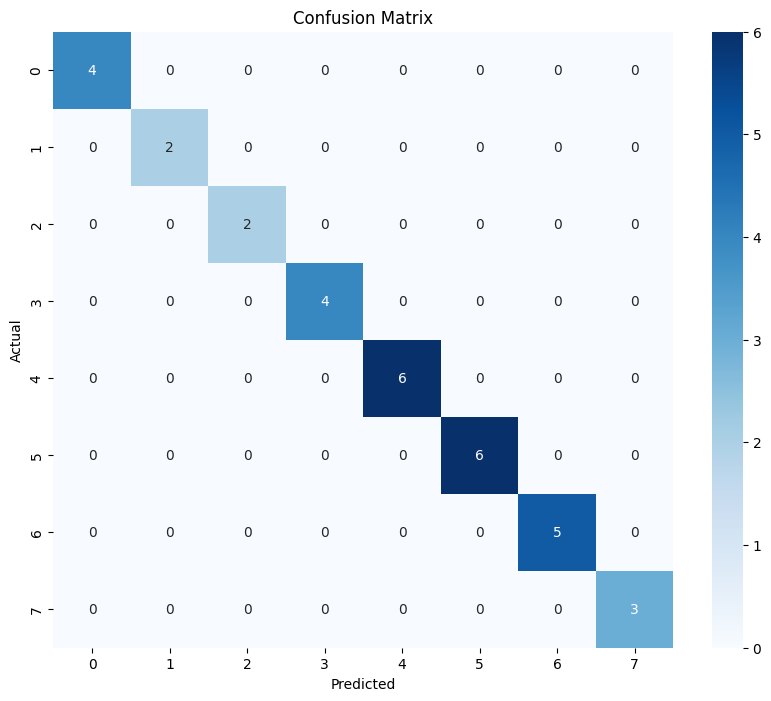

C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BPATR\OneDrive\Desktop\smai_assgn\assgn\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.90      0.88      0.89        32
weighted avg       1.00      0.97      0.98        32



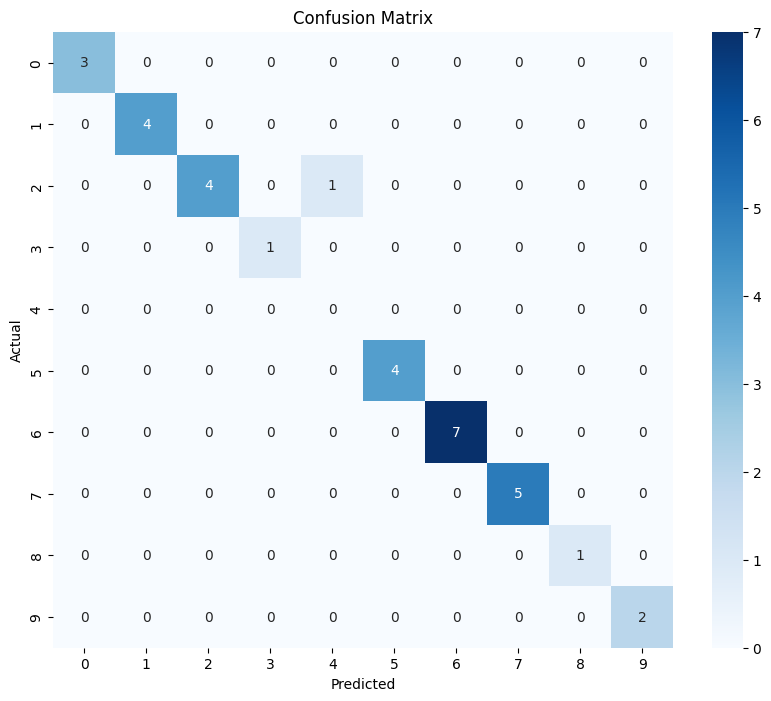

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         1
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         5

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



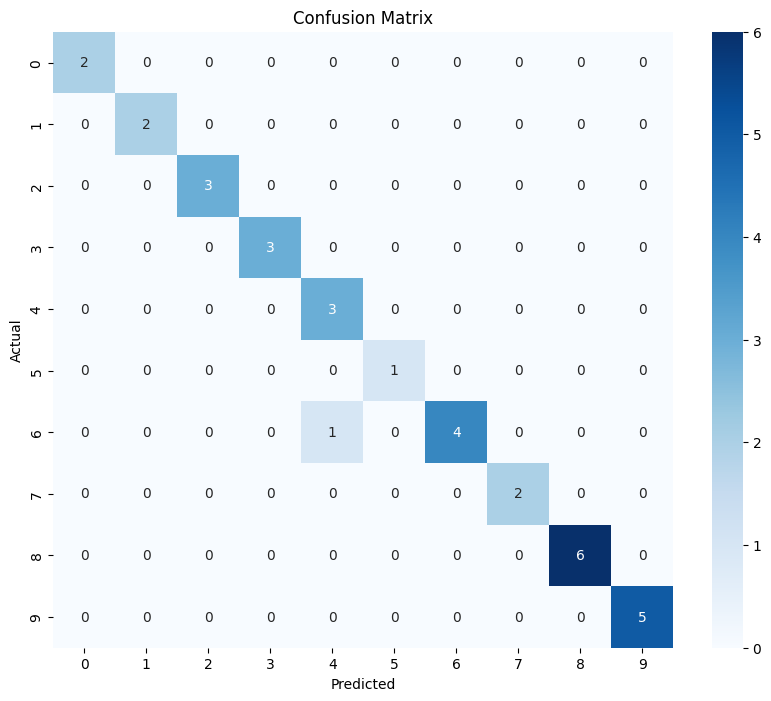

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



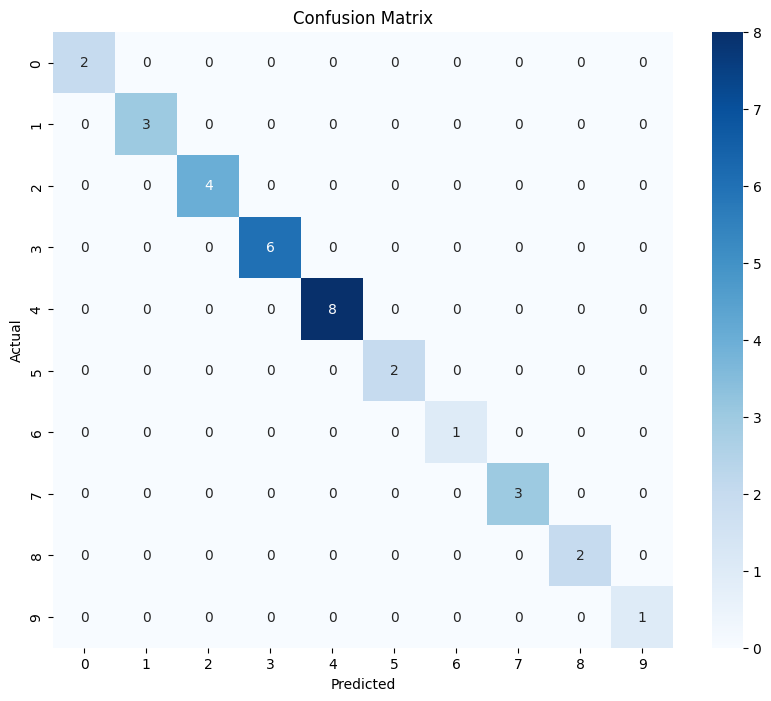

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.98      0.95      0.96        32
weighted avg       0.97      0.97      0.96        32



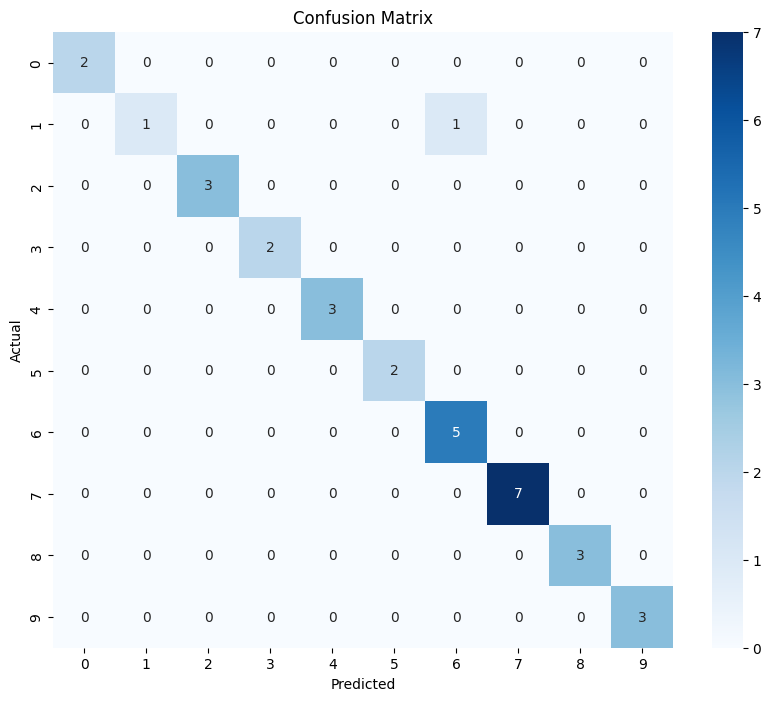

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         6
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.98      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



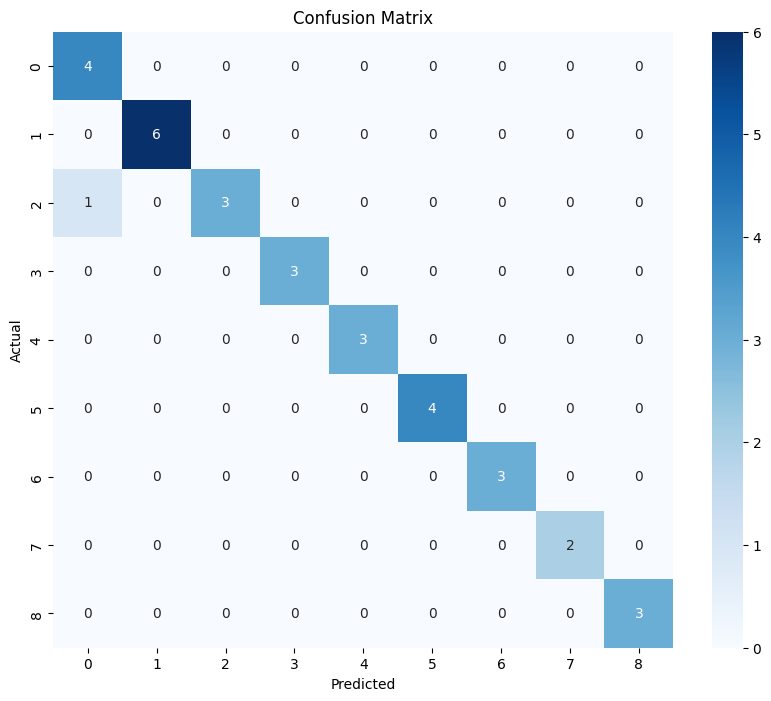

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



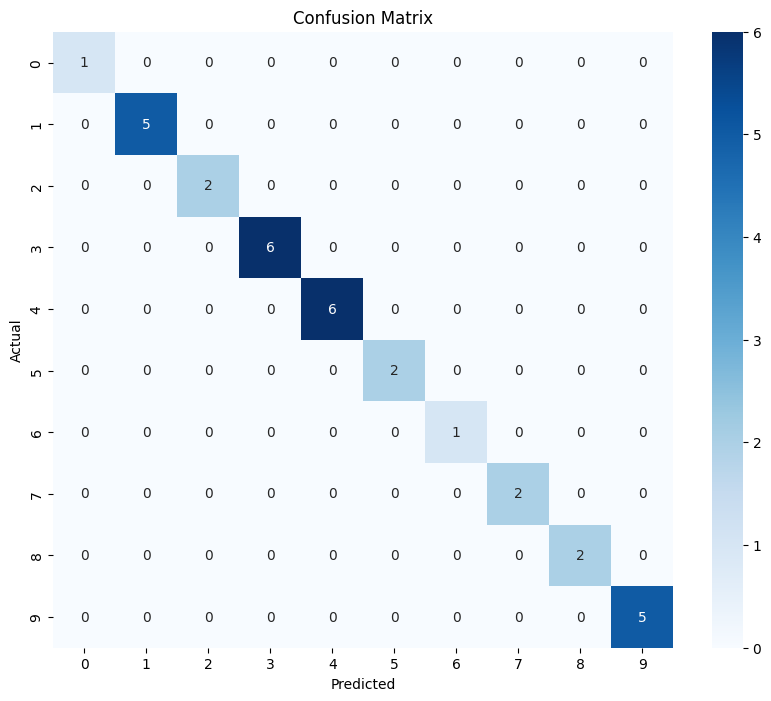

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



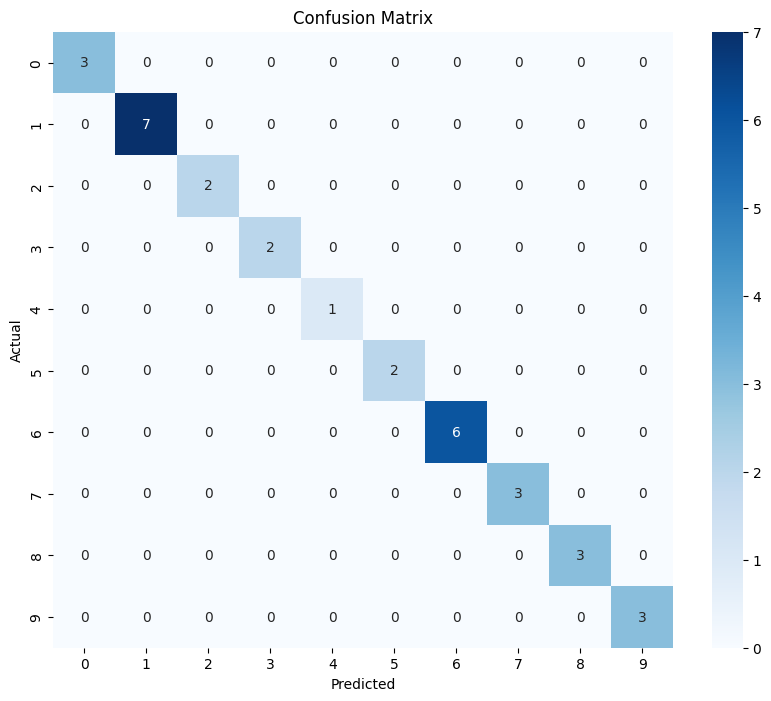

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       0.75      1.00      0.86         3
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.98      0.97      0.97        32



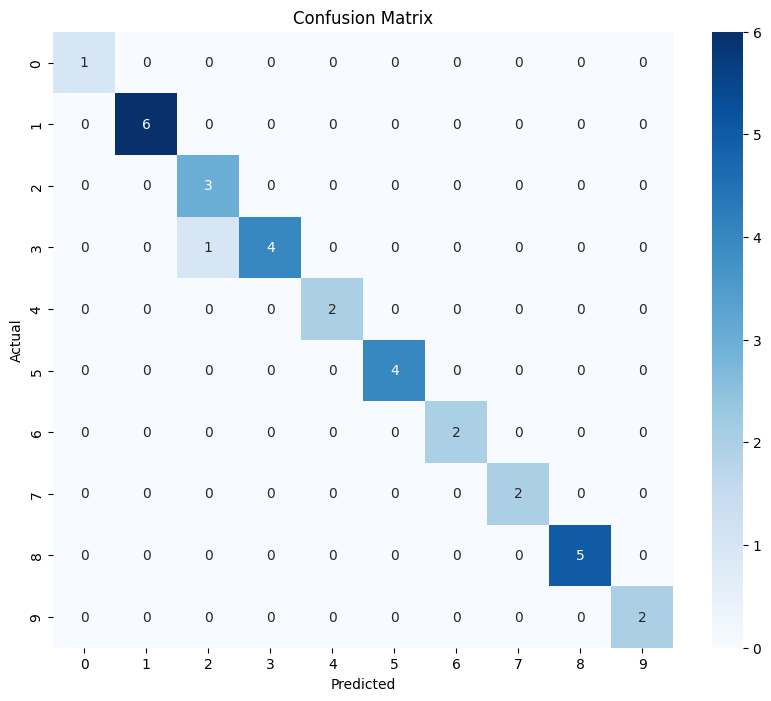

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



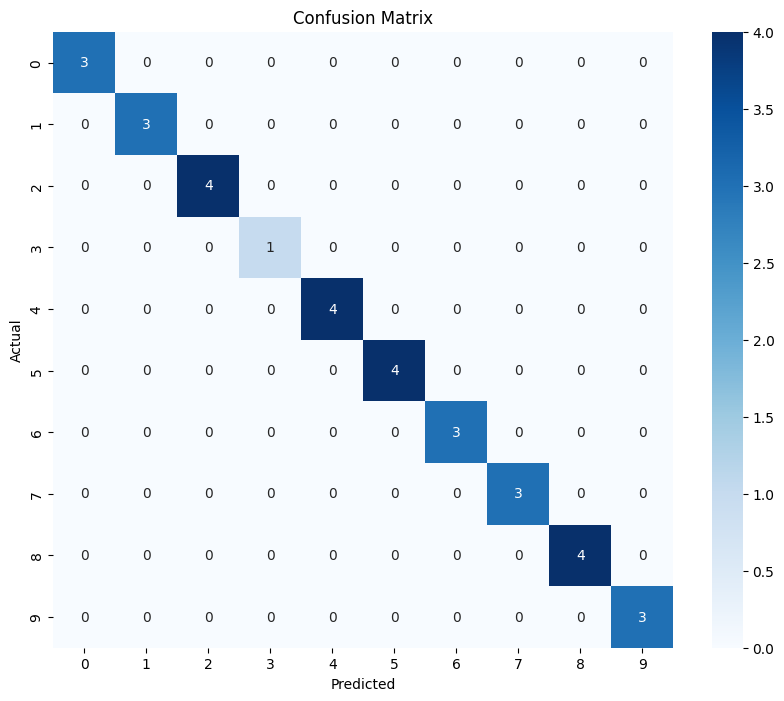

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32



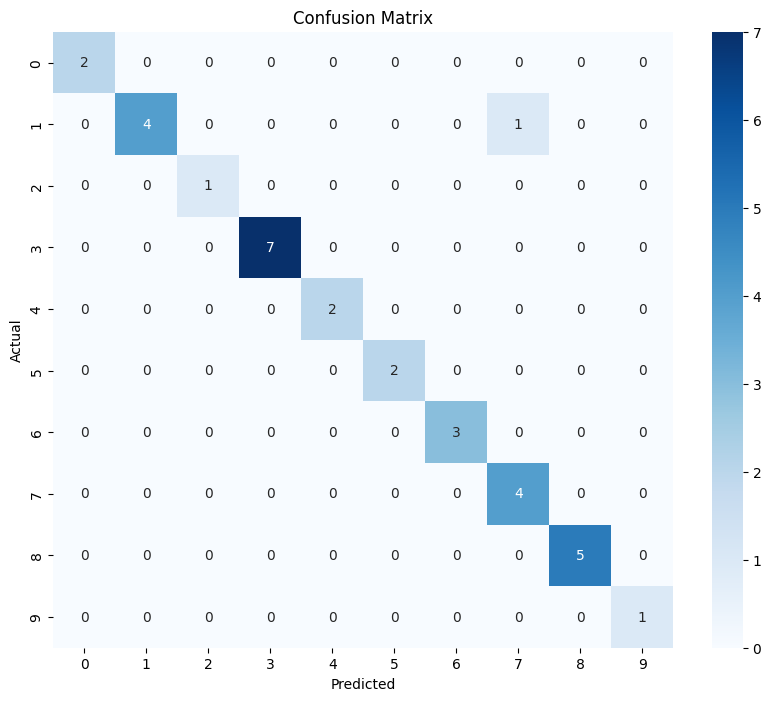

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         1
           9       0.86      1.00      0.92         6

    accuracy                           0.97        32
   macro avg       0.99      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



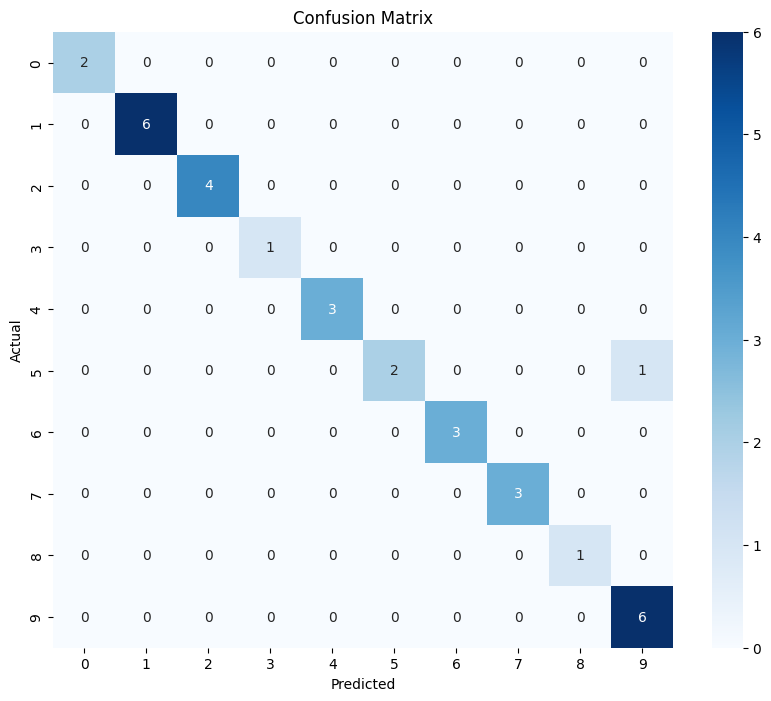

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



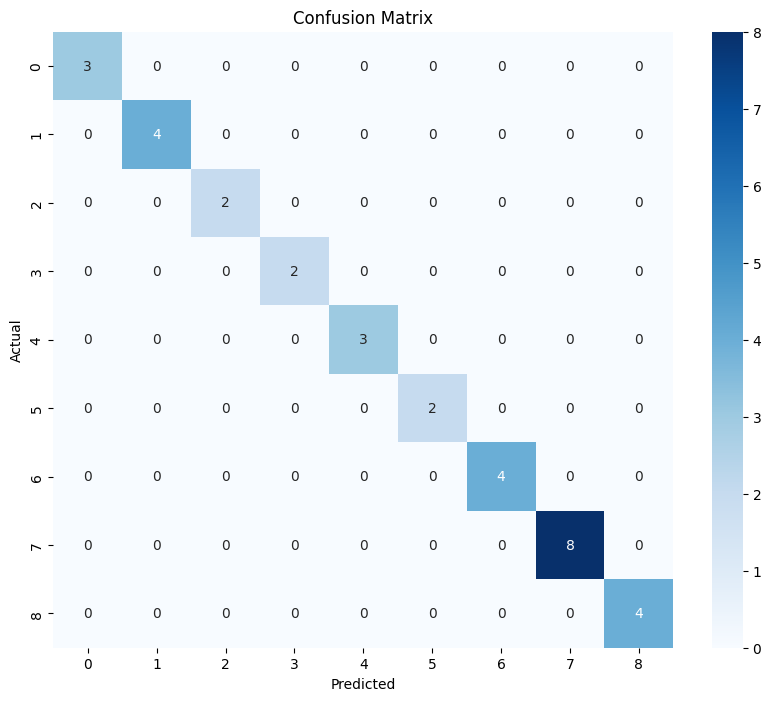

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



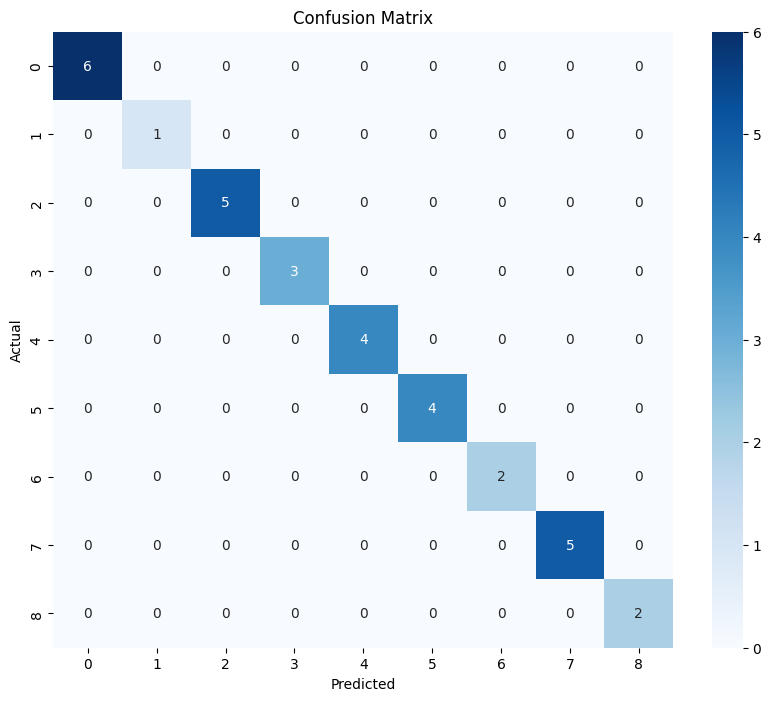

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.67      0.80         3
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.96        32
weighted avg       0.98      0.97      0.97        32



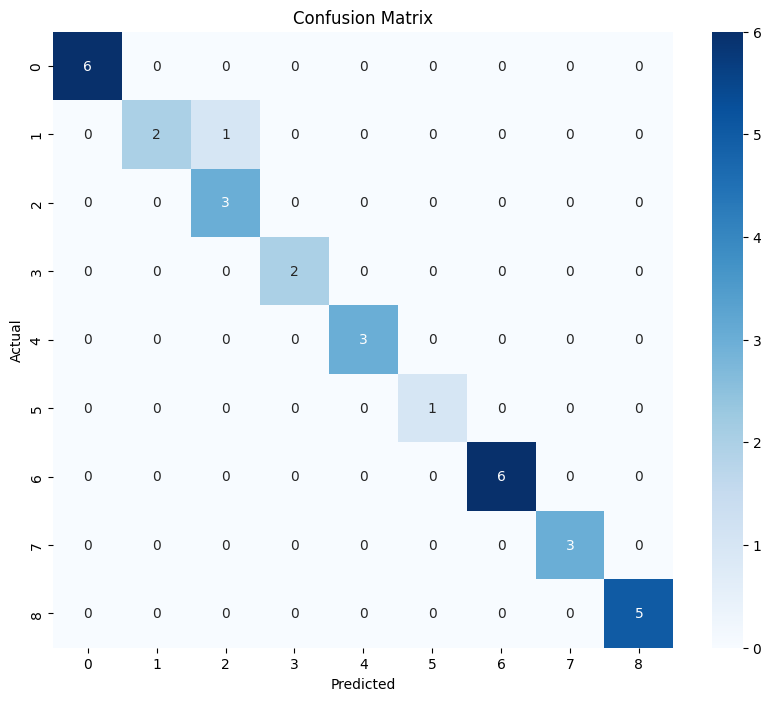

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



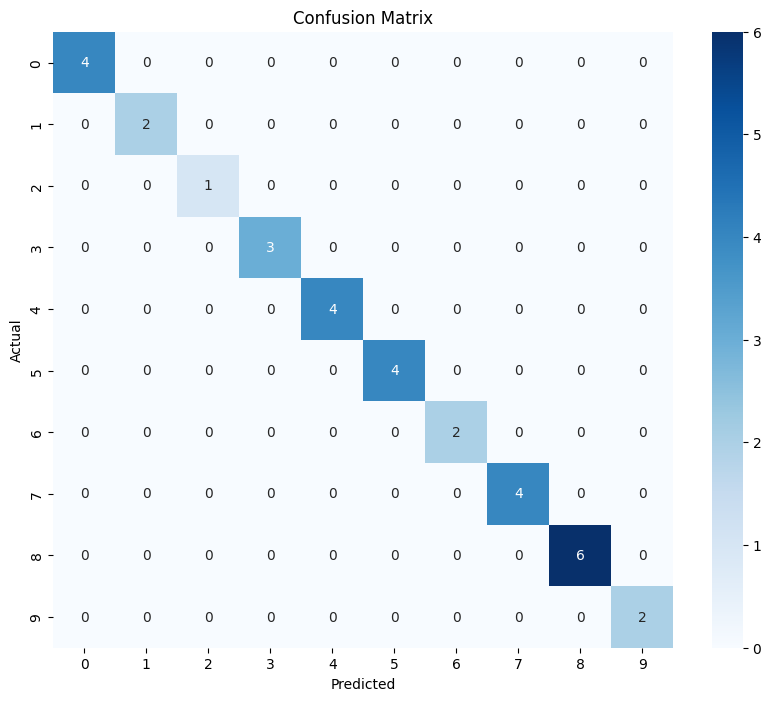

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



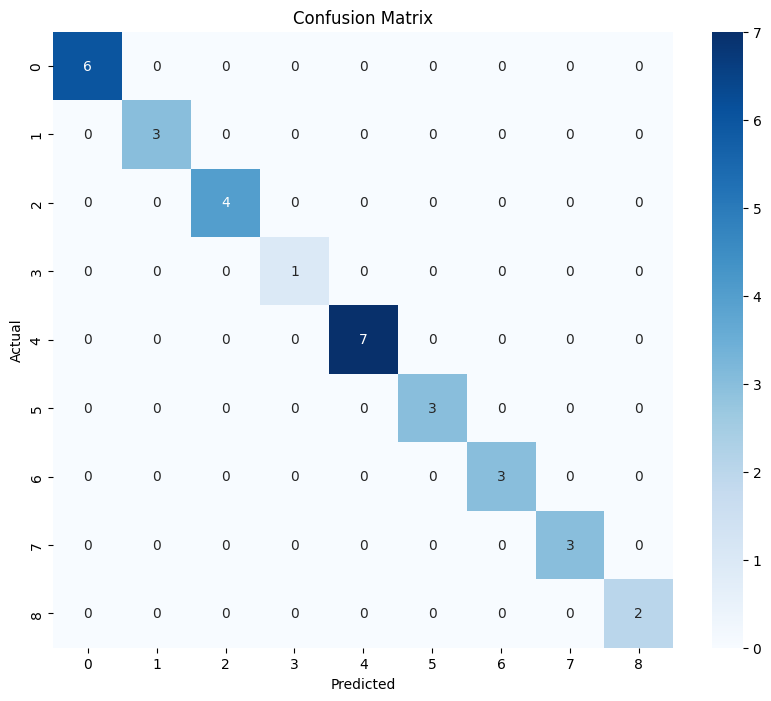

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



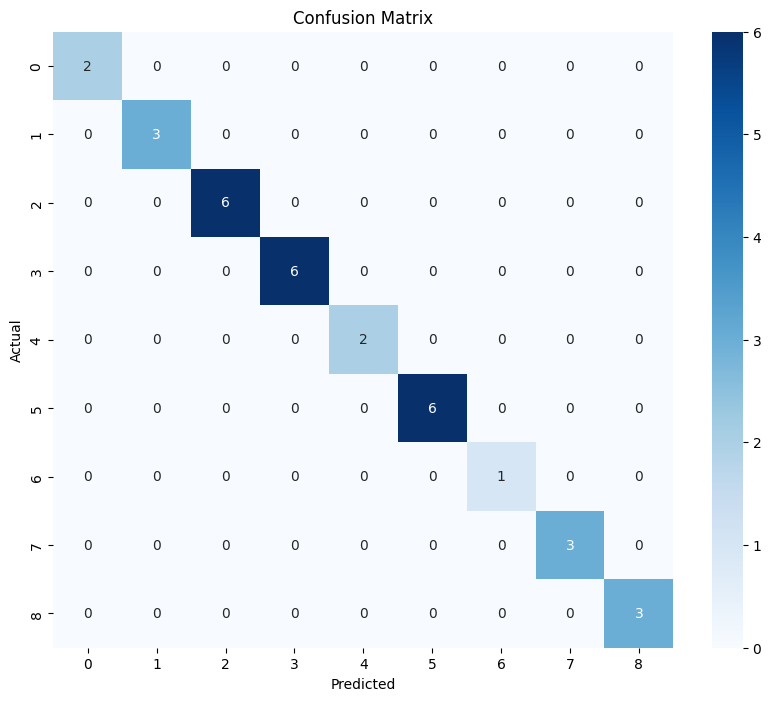

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         9
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.94      0.94      0.93        32
weighted avg       0.98      0.97      0.97        32



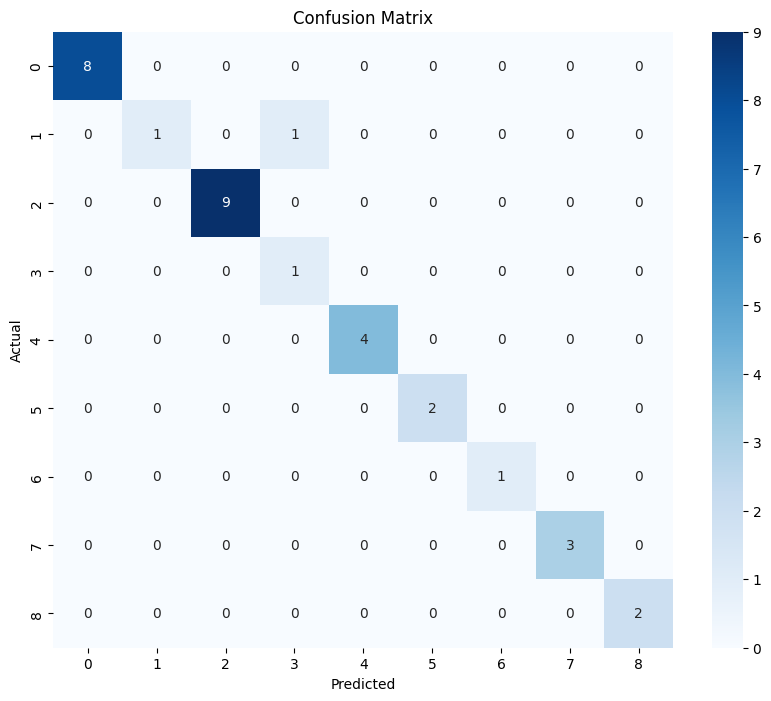

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.50      1.00      0.67         1
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       0.75      0.75      0.75         4

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.93        32
weighted avg       0.95      0.94      0.94        32



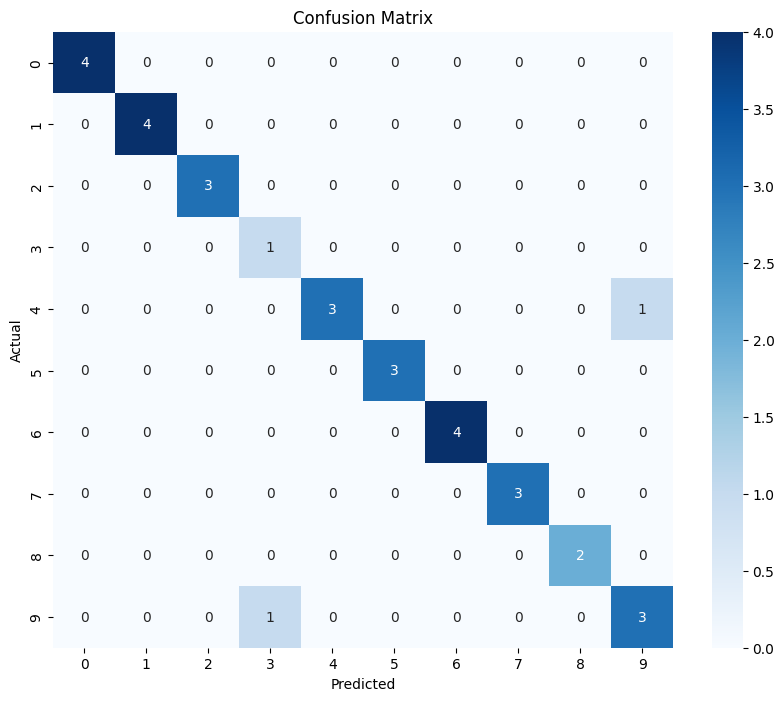

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



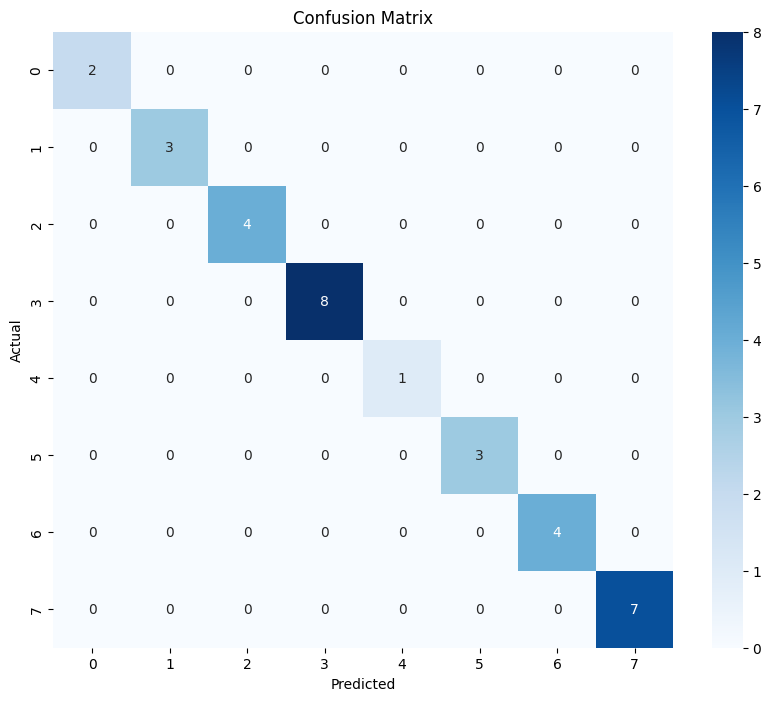

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



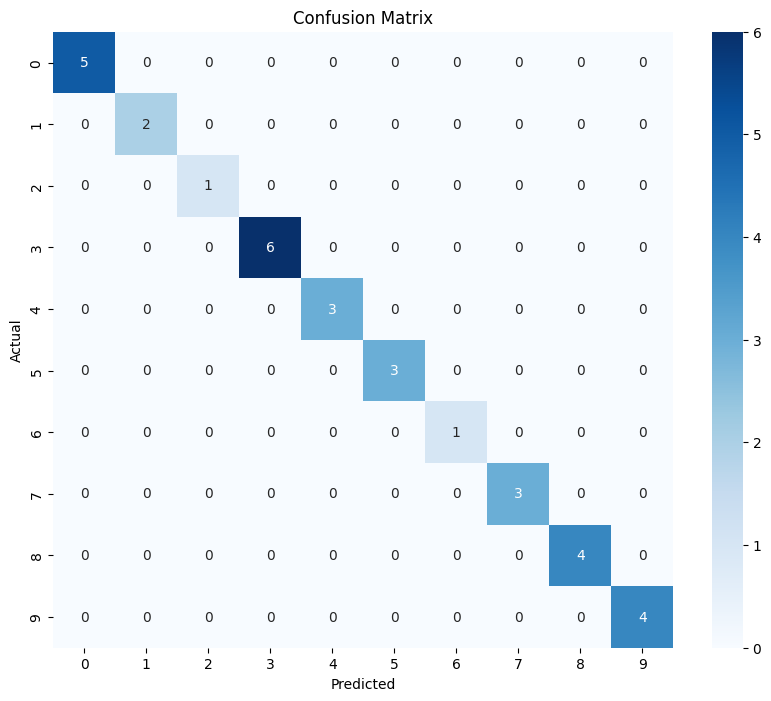

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



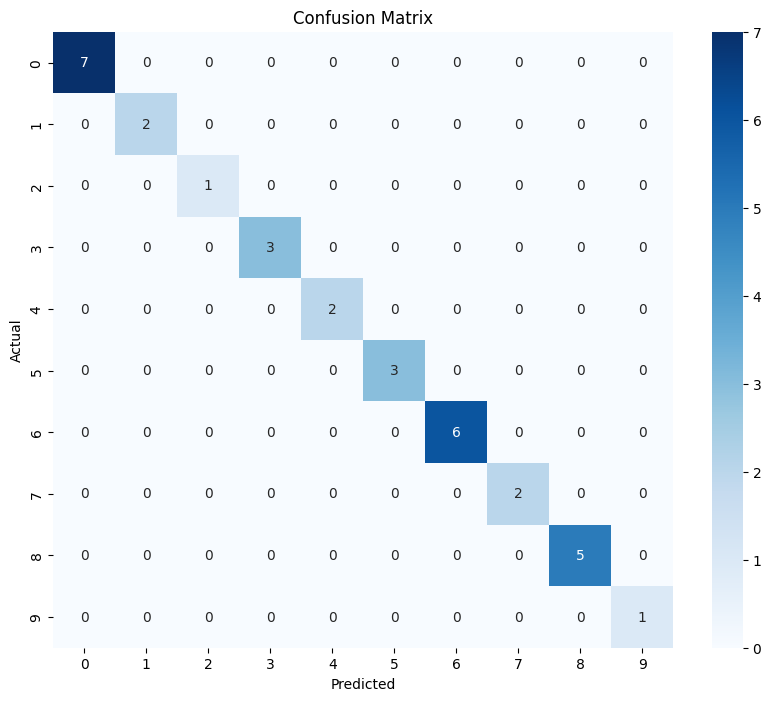

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



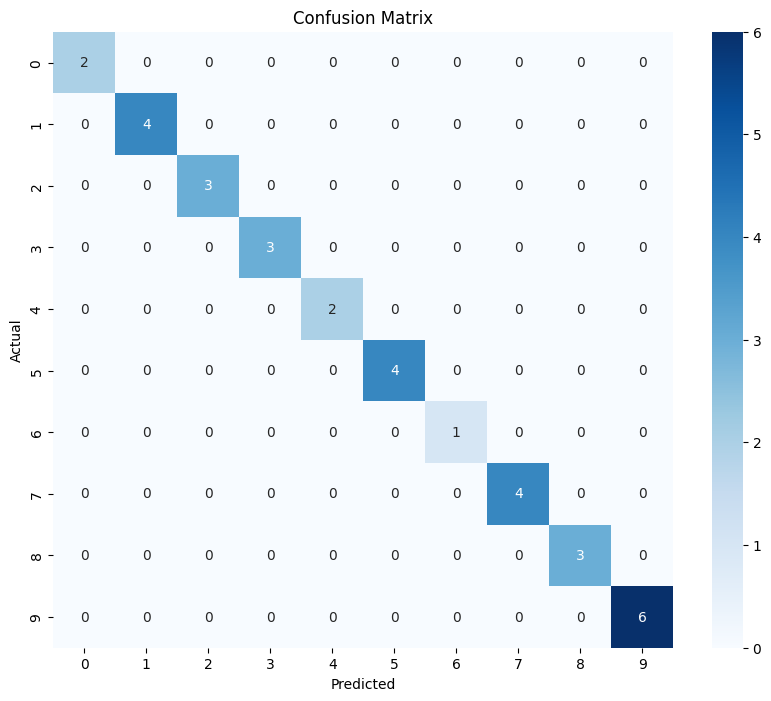

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



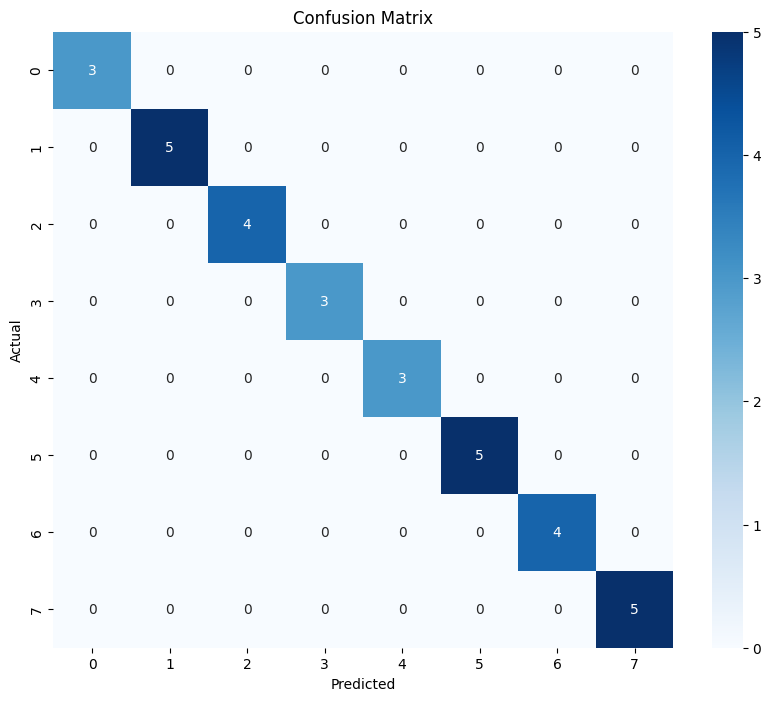

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



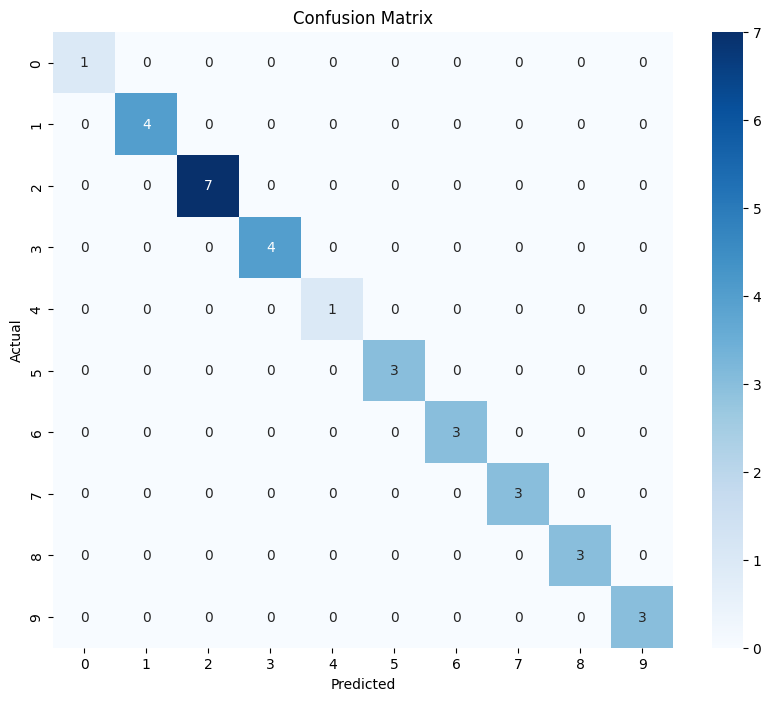

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



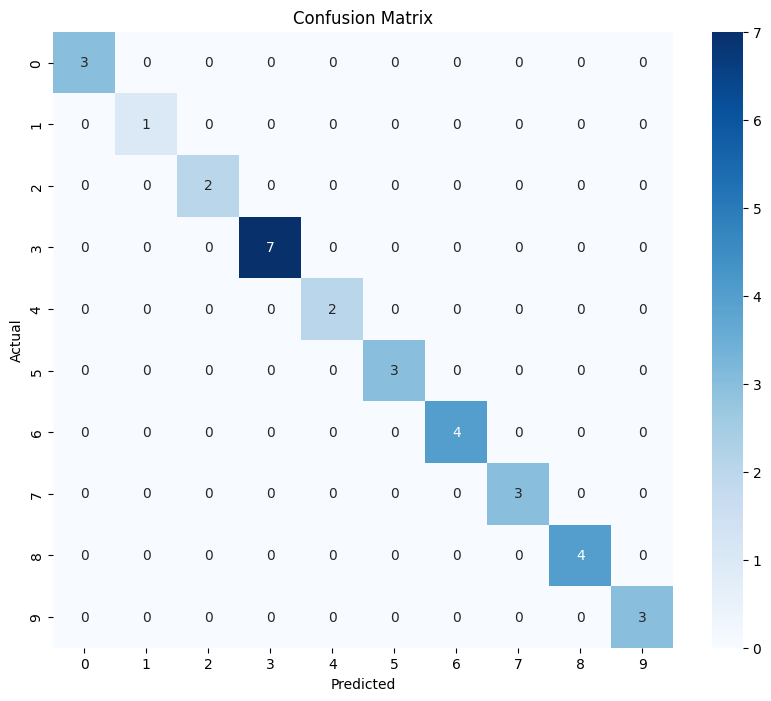

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



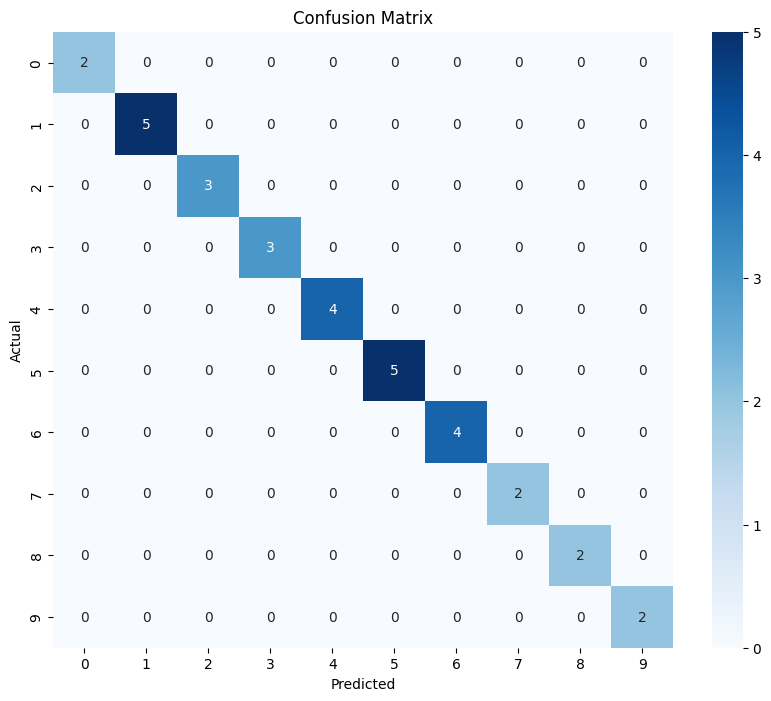

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



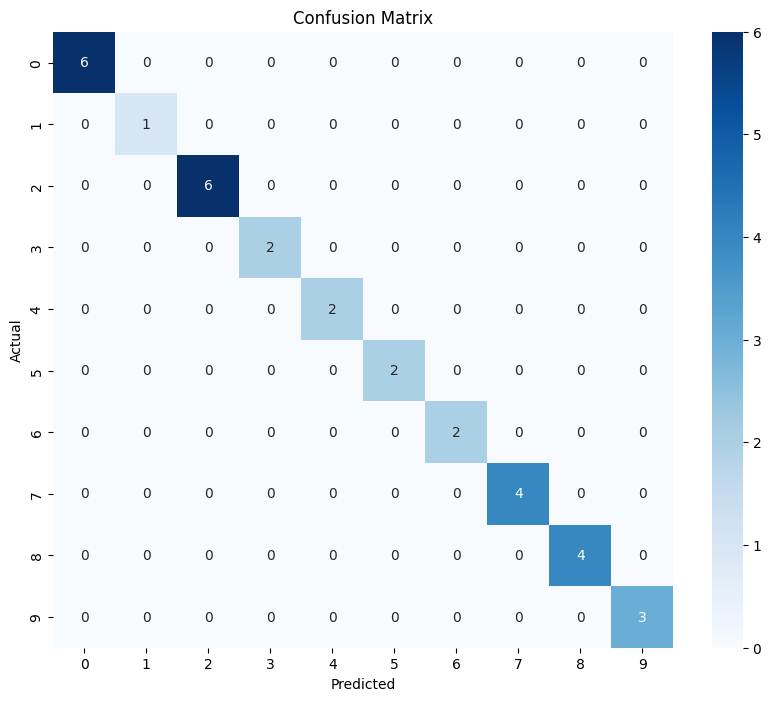

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         3
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         1
           8       1.00      0.86      0.92         7
           9       1.00      1.00      1.00         6

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.98      0.97      0.97        32



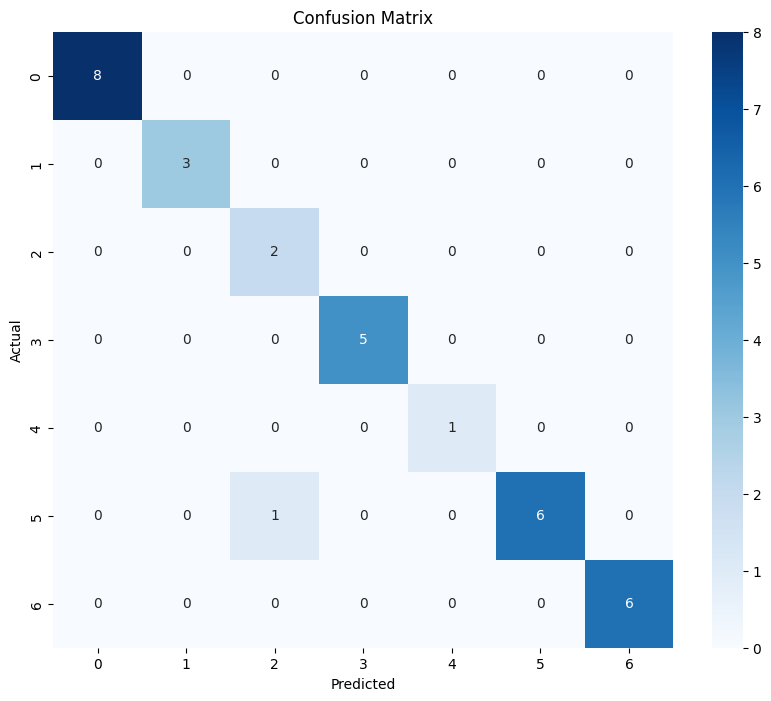

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



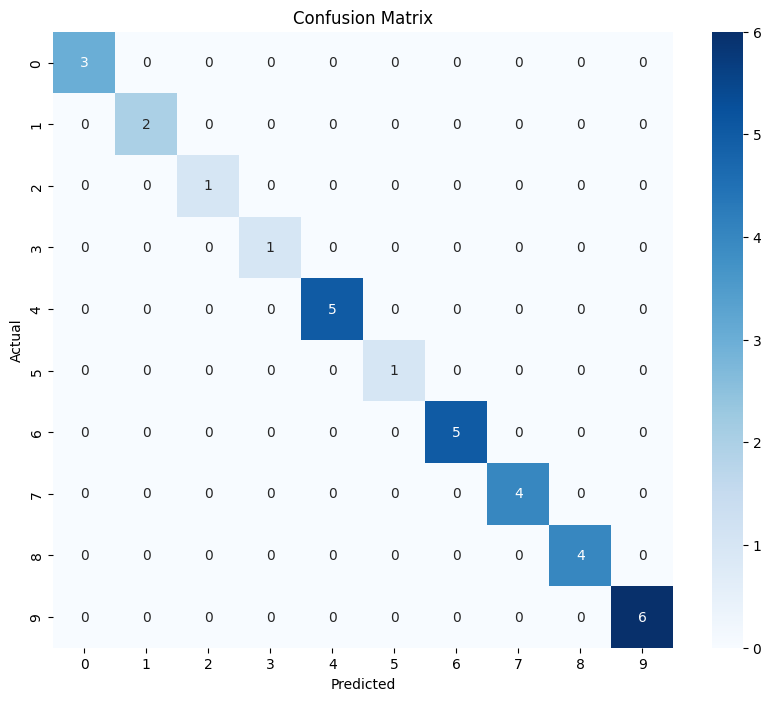

              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5

    accuracy                           0.97        32
   macro avg       0.96      0.94      0.94        32
weighted avg       0.98      0.97      0.97        32



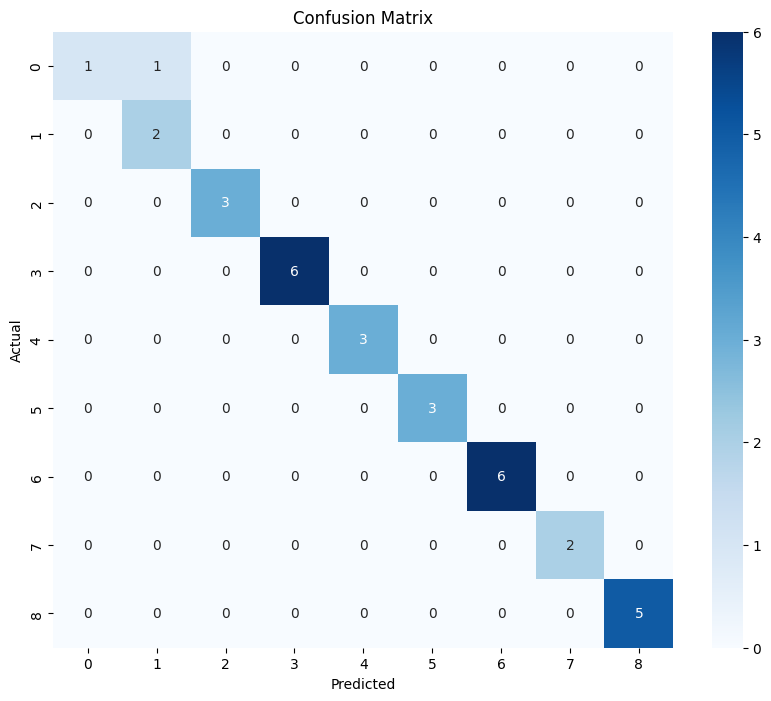

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



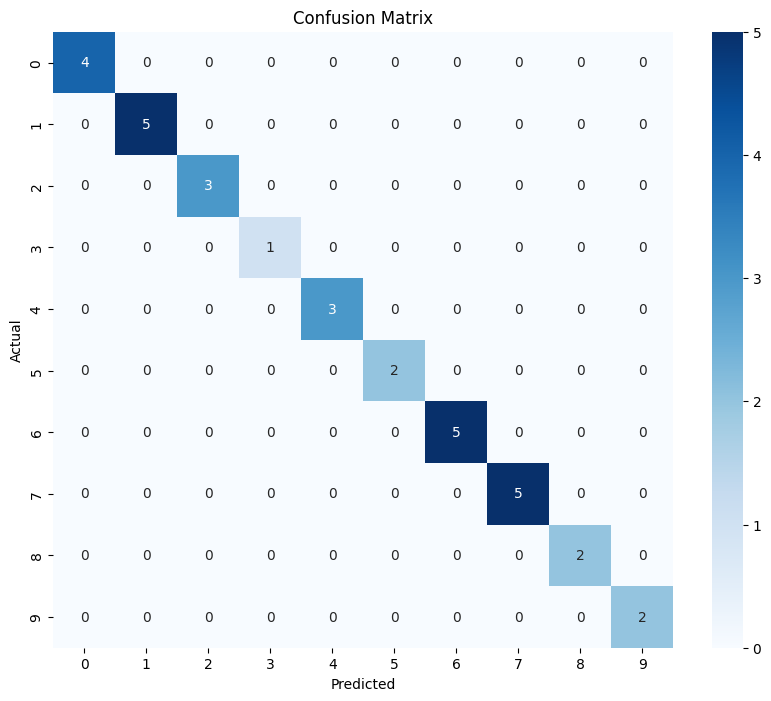

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



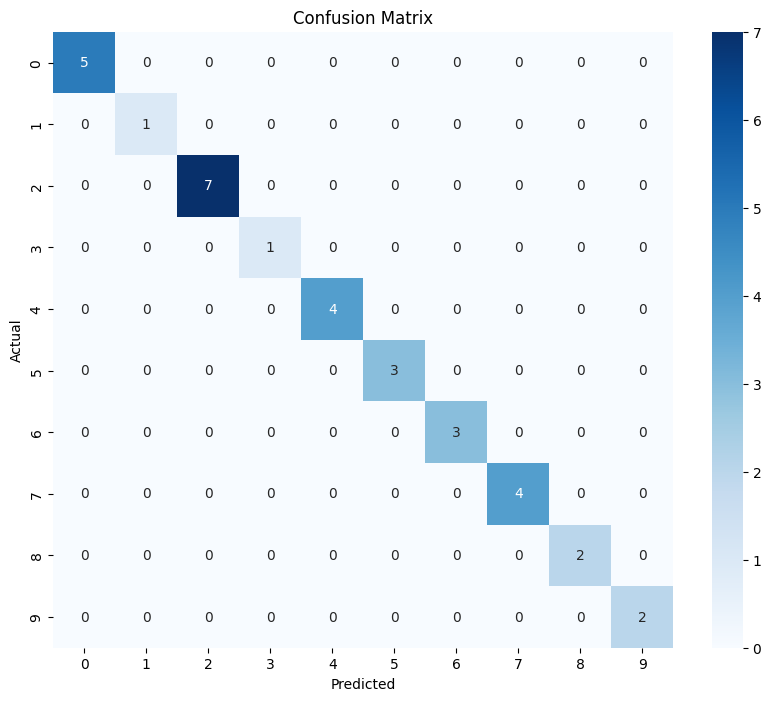

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



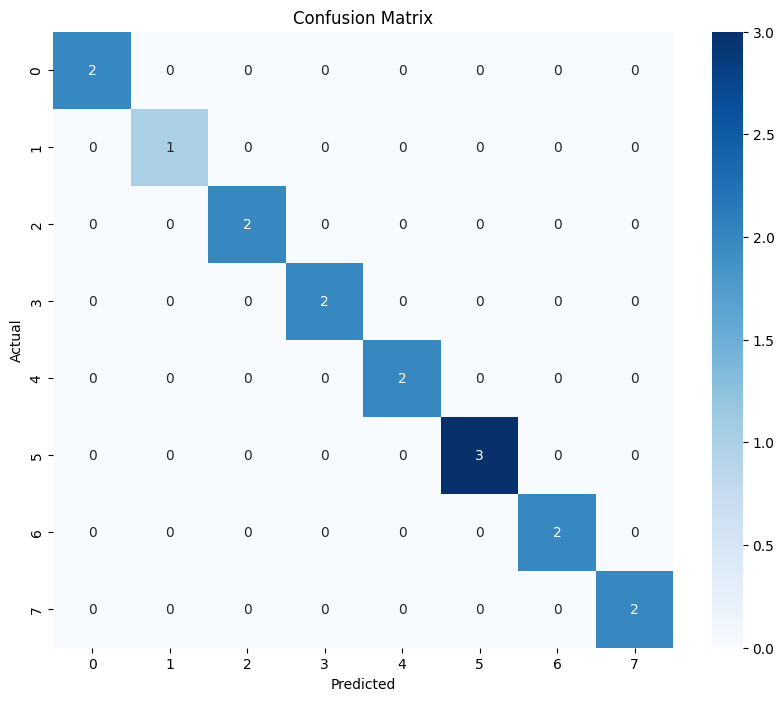

Test Accuracy: 98.41666666666667, Test Loss: 1.4743121799002303


In [12]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_labels=[]
test_predicted=[]
test_loss=0
total_test=0
correct_test=0

for data in testloader:
    inputs, labels = data
    outputs = net(inputs)
    
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

    test_labels.append(labels)
    test_predicted.append(predicted)
    
    class_report = classification_report(labels, predicted)
    print(class_report)

    cm = confusion_matrix(labels, predicted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

test_accuracy = 100 * correct_val / total_val
avg_test_loss = test_loss / len(testloader)

print("Test Accuracy: {}, Test Loss: {}".format(test_accuracy, avg_test_loss))


## 4.5 Train on Noisy Dataset

In [18]:
import scipy.io
from torch.utils.data import DataLoader, random_split, TensorDataset

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)
        self.dropout = nn.Dropout(0.5)
        self.activationlayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activationlayer(x)
        return x


mat = scipy.io.loadmat('./mnist-with-awgn.mat')
train_x = mat['train_x']
test_x = mat['test_x']
train_y = mat['train_y']
test_y = mat['test_y']
x_train = torch.from_numpy(train_x).view(-1, 1, 28, 28).float()
x_test = torch.from_numpy(test_x).view(-1, 1, 28, 28).float()
y_train = torch.from_numpy(train_y).float()
y_test = torch.from_numpy(test_y).float()


# Defining Custom Dataset
train_dataset = TensorDataset(x_train, y_train)
test_data_temp = TensorDataset(x_test, y_test)
test_size = int(0.33 * len(test_data_temp))
val_size = int(len(test_data_temp) - 0.33 * len(test_data_temp))
val_dataset, test_dataset = torch.utils.data.random_split(test_data_temp, [val_size, test_size])


# Defining Data Loaders for Training, validation and Testing Datasets.
batch_size = 64
# testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

net = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        print(len(predicted))
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(trainloader)

    net.eval()  
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(valloader)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    

64


RuntimeError: The size of tensor a (64) must match the size of tensor b (10) at non-singleton dimension 1

## 4.6 AutoEncoders to Save the Day

#### 1. Implement an Autoencoder class which will help you de-noise the noisy mnist dataset from Part 4.5.
#### 2. Visualise the classes and feature space before and after de-noising.

(1) Download the mnist dataset, and generate a noisy version of the dataset by adding noise. <br>
(2) Train autoencoder on own generated clean and noisy pair for denoising. <br>
(3) Use the trained model to denoise the dataset given for the task.

Epoch [1/10], Loss: 0.0080
Epoch [2/10], Loss: 0.0070
Epoch [3/10], Loss: 0.0063
Epoch [4/10], Loss: 0.0063
Epoch [5/10], Loss: 0.0062
Epoch [6/10], Loss: 0.0061
Epoch [7/10], Loss: 0.0058
Epoch [8/10], Loss: 0.0063
Epoch [9/10], Loss: 0.0060
Epoch [10/10], Loss: 0.0059
Training complete


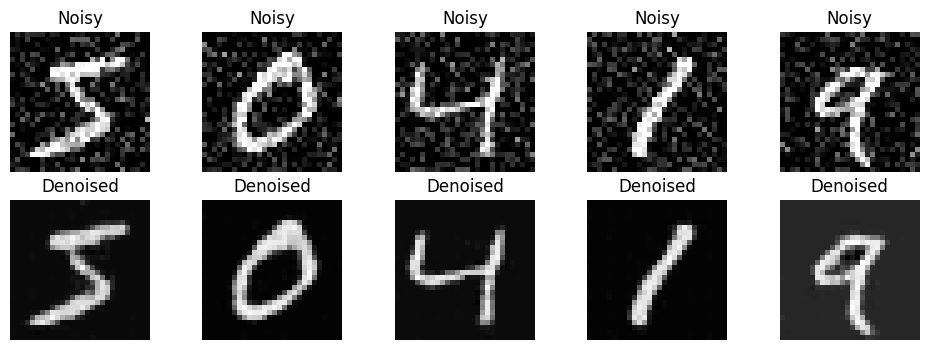

In [2]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Add noise
def add_noise(img, noise_level=0.2):
    noise = noise_level * torch.randn_like(img)
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Clean and noisy pairs
def generate_clean_noisy_pairs(dataset):
    clean_images = []
    noisy_images = []
    for img, _ in dataset:
        clean_images.append(img)
        noisy_images.append(add_noise(img))
    return torch.stack(clean_images), torch.stack(noisy_images)

clean_images, noisy_images = generate_clean_noisy_pairs(mnist_dataset)

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 10
for epoch in range(num_epochs):
    for clean_img, noisy_img in zip(clean_images, noisy_images):
        optimizer.zero_grad()
        outputs = autoencoder(noisy_img.unsqueeze(0))
        loss = criterion(outputs, clean_img.unsqueeze(0))
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

# Denoise MNIST dataset
def denoise_images(autoencoder, noisy_images):
    denoised_images = []
    for noisy_img in noisy_images:
        denoised_img = autoencoder(noisy_img.unsqueeze(0))
        denoised_images.append(denoised_img)
    return torch.stack(denoised_images)

denoised_mnist_images = denoise_images(autoencoder, noisy_images)

def plot_images(noisy_images, denoised_images, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        axes[0, i].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Noisy")
        axes[0, i].axis('off')

        axes[1, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
        axes[1, i].set_title("Denoised")
        axes[1, i].axis('off')

    plt.show()

# Plot the results
plot_images(noisy_images, denoised_mnist_images)

# Best Model 
# learning_rates = 0.001
# batch_sizes = 32
# kernel_sizes = 3
# strides_values = 2
# num_epochs_values = 10
# dropout_rates = 0

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)
        self.dropout = nn.Dropout(0)
        self.activationlayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activationlayer(x)
        return x

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

net = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(trainloader)

    net.eval() 
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(valloader)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


# 5 Some Other Variants

## 5.1 Multi-digit Recognition on Multi-MNIST Dataset

From the Multi-MNIST dataset, images where the same digit appears twice are filtered out and excluded. Model is trained only on images that have distinct digits. So, in the 'test' folder, 00, 11, 33, 44, 77 and 88 were removed. 

#### Splitting the datasets into training and validation sets to evaluate the model’s performance during hyperparameter tuning.

In [5]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.data = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root, class_name)
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                label = int(class_name)
                self.data.append((img_path, label)) 
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index]
        label = torch.tensor(label)
        img = Image.open(img_path).convert("L")

        if self.transform:
            img = self.transform(img)

        return img, label


In [6]:
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

dataset_root = './double_mnist_seed_123_image_size_64_64/train'
custom_dataset = CustomImageFolderDataset(root=dataset_root, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=100)

#### Displaying several images from the filtered dataset to familiarize with the dual-digit nature of the images.

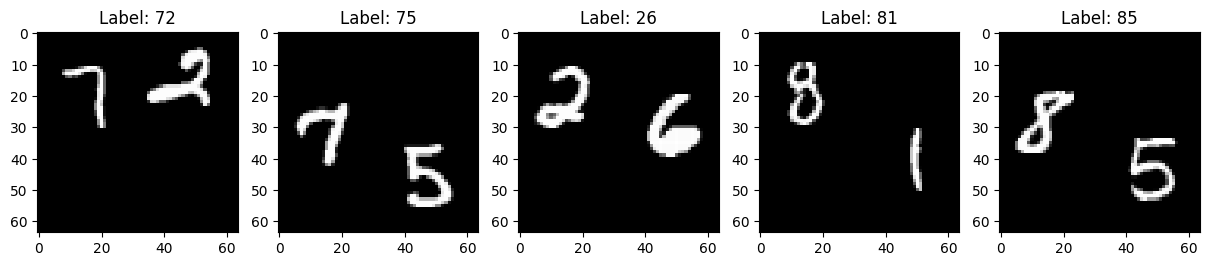

In [12]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(0, num_samples):
    index = random.randint(0, custom_dataset.__len__() + 1)
    image, label = custom_dataset.__getitem__(index)
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0), cmap='gray')
    ax.set_title("Label: {}".format(label))
    

#### 5.1.1 MLP on Multi-MNIST

In [8]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 100)
        self.fc3 = nn.Linear(100, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = (self.fc4(x))
        return x

# Define model parameters
input_size = 64 * 64 
hidden_size = 128 
num_classes = 100 

model = MLPModel(input_size, hidden_size, num_classes)

batch_size = 64

train_path = './double_mnist_seed_123_image_size_64_64/train'
train_dataset = CustomImageFolderDataset(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100)

test_path = './double_mnist_seed_123_image_size_64_64/test'
test_dataset = CustomImageFolderDataset(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100)

val_path = './double_mnist_seed_123_image_size_64_64/val'
val_dataset = CustomImageFolderDataset(root=val_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=100)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(validation_data, batch_size=batch_size)
# test_loader = DataLoader(test_data, batch_size=batch_size)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        #print(labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total = correct = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%')

model.eval()
with torch.no_grad():
    total = correct = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


KeyboardInterrupt: 

#### 5.1.2 CNN on Multi-MNIST

In [ ]:

class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 16 * 16, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

train_path = './double_mnist_seed_123_image_size_64_64/train'
train_dataset = CustomImageFolderDataset(root=train_path, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=100)

test_path = './double_mnist_seed_123_image_size_64_64/test'
test_dataset = CustomImageFolderDataset(root=test_path, transform=transform)
testloader = DataLoader(test_dataset, batch_size=100)

val_path = './double_mnist_seed_123_image_size_64_64/val'
val_dataset = CustomImageFolderDataset(root=val_path, transform=transform)
valloader = DataLoader(val_dataset, batch_size=100)

net = MultiCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(trainloader)

    # Validation
    net.eval()  
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(valloader)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')


#### 5.1.3 Testing on Single digit MNIST (regular MNIST)

## 5.2 Permuted MNIST

In [13]:
from sklearn.model_selection import train_test_split
# To load the dataset, you can use np.load
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]
print(data)

permuted_x_train, permuted_x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.Tensor(permuted_x_train), torch.LongTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(torch.Tensor(permuted_x_val), torch.LongTensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=64)
test_dataset = TensorDataset(torch.Tensor(permuted_x_test), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=64)

NpzFile 'permuted_mnist.npz' with keys: train_images, train_labels, test_images, test_labels


#### 5.2.1 MLP on Permuted-MNIST

In [18]:
# ChatGPT generated

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 28 * 28 
hidden_size = 128
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    print("Epoch ", epoch+1)
    model.train()
    correct=0
    total=0
    for images, labels in train_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch  1
Validation Accuracy: 89.61%
Epoch  2
Validation Accuracy: 94.56%
Epoch  3
Validation Accuracy: 95.62%
Epoch  4
Validation Accuracy: 95.67%
Epoch  5
Validation Accuracy: 96.21%
Epoch  6
Validation Accuracy: 96.27%
Epoch  7
Validation Accuracy: 96.66%
Epoch  8
Validation Accuracy: 96.74%
Epoch  9
Validation Accuracy: 96.85%
Epoch  10
Validation Accuracy: 97.02%
Test Accuracy: 95.26%


#### 5.2.2 CNN on Permuted-MNIST

In [21]:
# ChatGPT generated 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Validation Accuracy: 94.81%
Validation Accuracy: 96.29%
Validation Accuracy: 97.01%
Validation Accuracy: 97.46%
Validation Accuracy: 97.78%
Validation Accuracy: 98.04%
Validation Accuracy: 98.24%
Validation Accuracy: 98.40%
Validation Accuracy: 98.53%
Validation Accuracy: 98.65%
Test Accuracy: 98.42%


## 5.3 Analysis [10 marks]
1. Contrast the performances of MLP vs. CNN for both datasets.
2. Discuss the observed differences and any challenges faced during training
and evaluation.
3. Compare the potential for overfitting between a CNN and an MLP in the
context of datasets in Task 5. Use training vs. validation loss/accuracy
plots to support your observations.


1. CNN performs better than MLP 
2. The most difficult part war to load the dataset and trian the model. And also hyperparameter tuning.
3. In both the cases overfitting is a serious problem. We can use multiple methods like Dropout and Normalisation to prevent ovverfitting of the data. 
But for CNN its is more prone. 